# 1. Data Pre-Processing

In [1]:
import pandas as pd
import numpy as np

#timeseries libraries
from statsmodels import tsa
from statsmodels.graphics import tsaplots
from statsmodels.api import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy import stats
from pmdarima.arima import auto_arima

#machine-learning algorithms
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

#viz
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

#others
from collections import defaultdict
from tqdm import tqdm 
import pickle as pkl
#ignore Future warnings
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

In [3]:
train = pd.read_csv('./train.csv')
train.shape

(577060473, 2)

In [5]:
rows = 150000
segments = int(np.floor(train.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  3847


In [6]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])
train_X.shape, train_y.shape

((3847, 0), (3847, 1))

In [7]:
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()

In [10]:
from tqdm import tqdm_notebook 

for seg_id in tqdm_notebook(range(segments)):
    seg = train.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

/var/folders/yk/fkw6323n01l4qfb_x2dbrdz40000gn/T/ipykernel_17581/628003661.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for seg_id in tqdm_notebook(range(segments)):


  0%|          | 0/3847 [00:00<?, ?it/s]

In [13]:
print(train_X.shape)
print(train_y.shape)

(3847, 4)
(3847, 1)


In [14]:
rseismic = train_X['mean'].diff()
rseismic.dropna(inplace=True)
rseismic.head()

1   -0.158347
2    0.180627
3   -0.004153
4    0.006480
5    0.004793
Name: mean, dtype: float64

In [16]:
train_X.head()

,mean,std,max,min
0,4.884113,5.101106,104.0,-98.0
1,4.725767,6.588824,181.0,-154.0
2,4.906393,6.967397,140.0,-106.0
3,4.902240,6.922305,197.0,-199.0
4,4.908720,7.301110,145.0,-126.0


In [20]:
train_y.head()

,time_to_failure
0,1.430797
1,1.391499
2,1.353196
3,1.313798
4,1.274400


In [23]:
train_y = train_y[1:]
train_y.shape

(3846, 1)

In [24]:
def plot_timeseries(series, title=None,xlabel=None,ylabel=None):
    '''
     Plot the timeseries with a figure size 16,6.
     
    '''
    plt.figure(figsize=(16,6))
    plt.plot(series)
    if title!=None: plt.title(title)
    if xlabel!=None: plt.xlabel(xlabel)
    if ylabel!=None: plt.ylabel(ylabel)
    plt.show()

def plot_autocorrelation(series,nlags,plot=None):
    '''
     Plot auto-correlation functions ACF and PACF.
     Arguments:
         series: time-series object
         nlags: number of lags to show on correlation plots.
         plot: Accecpted values: ['ACF','PACF',None]
             If None then plot both ACF and PACF plots.
    '''
    from statsmodels.graphics import tsaplots
    
    fsize=(12,8)
    subplot=211
    
    if plot!=None: 
        fsize=(12,4)
        subplot=111
    
    fig= plt.figure(figsize=fsize)
    ax=fig.add_subplot(subplot)
    
    if plot==None or 'ACF':
        fig=tsaplots.plot_acf(series,lags=nlags,ax=ax)
        plt.xticks(range(nlags))
    
    if plot==None: 
        ax = fig.add_subplot(212)
    if plot==None or 'PACF':
        fig=tsaplots.plot_pacf(series,lags=nlags,ax=ax)
        plt.xticks(range(nlags))
    
    plt.xlabel('Lag-K')
    plt.show()

In [25]:
def test_ljungbox(series,nlags):
    '''
     Function to conduct ljungbox test.
    '''
    from statsmodels.stats.diagnostic import acorr_ljungbox
    
    s,p=acorr_ljungbox(series,lags=nlags)
    
    print('Ljung-Box test for {}-lags\n\n\tStatistics:\n{}\n\tp-values:\n{}'.format(nlags,s,p))

def test_dickeyFuller(series,reg_method='c',ic='BIC'):
    '''
     Conduct Augmented Dickey-Fuller test.
    '''
    from statsmodels.tsa.stattools import adfuller
    
    results=adfuller(series,regression=reg_method,autolag=ic)
    
    print('Augmented Dickey Fuller test results:')
    print('Test Statistics:',results[0])
    print('p-values:',results[1])
    print('Used lags:',results[2])
    print('Observations used:',results[3])
    print('Significance levels:\n\t{}'.format(results[4]))

In [26]:
def custom_train_test_split(X,y,train_size):
    '''
     Custom function to split the data into train-test
     train_size: [Float] between 0-1
     
     Returns:
         [Xtrain,Xtest,ytrain,ytest]
     
    '''
    
    length = X.shape[0]
    split_size = int(length*train_size)
    
    X_train,X_test = X[:split_size],X[split_size:]
    y_train,y_test = y[:split_size],y[split_size:]
    
    return X_train,X_test,y_train,y_test

In [28]:
X_train,X_test,y_train,y_test = custom_train_test_split(rseismic,train_y,train_size=0.95)

In [29]:
print("X_train : ",X_train.shape)
print("y_train : ",y_train.shape)
print("X_test : ",X_test.shape)
print("y_test : ",y_test.shape)

X_train :  (3653,)
y_train :  (3653, 1)
X_test :  (193,)
y_test :  (193, 1)


In [30]:
auto_arima(X_train,d=1,information_criterion='aic',stepwise=True,trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-376.070, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1714.912, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-378.070, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2373.517, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2746.274, Time=0.28 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-2976.334, Time=0.36 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-3201.633, Time=0.46 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-4128.967, Time=4.53 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.92 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.32 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-4054.658, Time=4.08 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=3.17 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0] intercept
Tota

ARIMA(order=(5, 1, 1), scoring_args={}, suppress_warnings=True)

## Modelling

## **ARIMA**

In [31]:
def backtest_Arima(X,arima_order,test_size):
    '''
     Backtest ARIMA model
    '''
    X = X.values
    results_dict = defaultdict(list)
    length = X.shape[0]
    train_len = int((1-test_size)*length)
    exception_at = []
    
    for idx in tqdm(range(length-train_len)):
        #create train and test set with sliding window = length of train set
        train,test=X[idx:train_len+idx],X[train_len+idx]
        
        #fit ARIMA model on train and forecast next point
        try:
            model = SARIMAX(train,order=arima_order,enforce_stationarity=False,enforce_invertibility=False)
            model_fit = model.fit()
        except np.linalg.LinAlgError as e:
            exception_at.append(idx)
            continue

        #forecast next value of series
        predictions = model_fit.get_forecast(steps=1)
        pred = predictions.predicted_mean.flatten()
        pred_ci = predictions.conf_int(alpha=0.05)
        
        results_dict['actual'].append(test)
        results_dict['prediction'].append(pred[0])
        results_dict['lower_ci'].append(pred_ci[:,0][0])
        results_dict['upper_ci'].append(pred_ci[:,1][0])
        
        err = np.abs(test-pred)
        results_dict['abs_err'].append(err)
        
    if len(exception_at)>0:
        print('LinAlgError exception: SVD unable to converge; encountered at below iterations:\n{}'.format(exception_at))

    return results_dict,model_fit

In [32]:
def save_results(obj, filename):
    '''
     Function to save the results in a pickle object
    '''
    import pickle as pkl
    
    try:
        with open(filename+'.pkl','wb') as file:
            pkl.dump(obj,file)
    except Exception  as e:
        print('An error occurred while saving the file. Please review below msg for further information..\n',e)
        return
    print('File saved successfully as {}.pkl'.format(filename))
    
def load_results(filename):
    '''
     Function to load the results saved in a pickle object
    '''
    import pickle as pkl
    
    try: 
        with open(filename+'.pkl','rb') as file:
            f = pkl.load(file)
    except FileNotFoundError as fe:
        print('Could not find file {}.pkl in the system.'.format(filename))
        return
    except Exception as e:
        print('An error occurred while loading the file. Please review the below message..\n',e)
        return
    
    return f

**ARIMA (1,1,1)**

In [34]:
result,model111 = backtest_Arima(train_X['mean'],arima_order = (1,1,1),test_size=0.05)

/var/folders/yk/fkw6323n01l4qfb_x2dbrdz40000gn/T/ipykernel_17581/2039355372.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm(range(length-train_len)):


  0%|          | 0/193 [00:00<?, ?it/s]

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84985D-01    |proj g|=  2.63959D-01

At iterate    5    f= -5.95533D-01    |proj g|=  1.16015D-01

At iterate   10    f= -5.96536D-01    |proj g|=  4.93340D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   4.933D-05  -5.965D-01
  F = -0.59653563912779306     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f= -5.95980D-01    |proj g|=  1.06892D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   3.765D-06  -5.960D-01
  F = -0.59598018069800718     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84732D-01    |proj g|=  2.62269D-01

At iterate    5    f= -5.94806D-01    |proj g|=  1.42019D-01

At iterate   10    f= -5.96330D-01    |proj g|=  5.11741D-05

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84697D-01    |proj g|=  2.48735D-01

At iterate    5    f= -5.93628D-01    |proj g|=  1.19543D-01

At iterate   10    f= -5.96265D-01    |proj g|=  4.17643D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     24      1     0     0   6.966D-05  -5.963D-01
  F = -0.59626533426276207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f= -5.93701D-01    |proj g|=  1.23068D-01

At iterate   10    f= -5.96435D-01    |proj g|=  3.27330D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     27      1     0     0   5.888D-05  -5.964D-01
  F = -0.59643460566822715     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85232D-01    |proj g|=  2.58805D-01

At iterate    5    f= -5.94578D-01    |proj g|=  1.45486D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85622D-01    |proj g|=  2.62355D-01

At iterate    5    f= -5.95723D-01    |proj g|=  1.38794D-01

At iterate   10    f= -5.97211D-01    |proj g|=  5.52579D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     25      1     0     0   5.526D-05  -5.972D-01
  F = -0.59721095582595973     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -5.96772D-01    |proj g|=  2.39256D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     34      1     0     0   4.727D-05  -5.968D-01
  F = -0.59677166123244330     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85503D-01    |proj g|=  2.57237D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.94580D-01    |proj g|=  1.38671D-01

At iterate   10    f= -5.97173D-01    |proj g|=  1.35013D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   1.446D-05  -5.972D-01
  F = -0.59717293593923260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85515D-01    |proj g|=  2.55864D-01

At iterate    5    f= -5.94466D-01    |proj g|=  1.35792D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     42      2     0     0   1.990D-05  -5.971D-01
  F = -0.59710223880301994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85337D-01    |proj g|=  2.56424D-01

At iterate    5    f= -5.94368D-01    |proj g|=  1.38732D-01

At iterate   10    f= -5.96989D-01    |proj g|=  1.44767D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.95239D-01    |proj g|=  1.47306D-01

At iterate   10    f= -5.97105D-01    |proj g|=  3.75320D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   1.763D-06  -5.971D-01
  F = -0.59710452279740966     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85454D-01    |proj g|=  2.61830D-01

At iterate    5    f= -5.95766D-01    |proj g|=  1.41693D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84954D-01    |proj g|=  2.63033D-01

At iterate    5    f= -5.95740D-01    |proj g|=  1.27420D-01

At iterate   10    f= -5.96737D-01    |proj g|=  8.46943D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   3.235D-06  -5.967D-01
  F = -0.59673734793384892     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f= -5.95191D-01    |proj g|=  1.52430D-01

At iterate   10    f= -5.96626D-01    |proj g|=  3.32721D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     31      1     0     0   3.327D-04  -5.966D-01
  F = -0.59662616323970052     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84716D-01    |proj g|=  2.57112D-01

At iterate    5    f= -5.94099D-01    |proj g|=  1.51486D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84466D-01    |proj g|=  2.57009D-01

At iterate    5    f= -5.93886D-01    |proj g|=  1.49220D-01

At iterate   10    f= -5.96429D-01    |proj g|=  2.31561D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   1.327D-05  -5.964D-01
  F = -0.59642928847518806     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84718D-01    |proj g|=  2.61544D-01

At iterate    5    f= -5.95077D-01    |proj g|=  1.47433D-01

At iterate   10    f= -5.96598D-01    |proj g|=  1.29852D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     20      1     0     0   1.295D-04  -5.966D-01
  F = -0.59659761234092057     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.94416D-01    |proj g|=  1.51406D-01

At iterate   10    f= -5.96765D-01    |proj g|=  1.08588D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   2.128D-07  -5.968D-01
  F = -0.59676464082997382     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84849D-01    |proj g|=  2.54167D-01

At iterate    5    f= -5.94055D-01    |proj g|=  1.41212D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     30      1     0     0   4.301D-05  -5.969D-01
  F = -0.59686409410704344     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84622D-01    |proj g|=  2.48830D-01

At iterate    5    f= -5.93913D-01    |proj g|=  1.34703D-01

At iterate   10    f= -5.96747D-01    |proj g|=  6.91047D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     23      1     0     0   1.021D-04  -5.967D-01
  F = -0.59674740169325924     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85428D-01    |proj g|=  2.59176D-01

At iterate    5    f= -5.95186D-01    |proj g|=  1.51268D-01

At iterate   10    f= -5.97461D-01    |proj g|=  8.13037D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85749D-01    |proj g|=  2.65523D-01

At iterate    5    f= -5.97341D-01    |proj g|=  6.60359D-02

At iterate   10    f= -5.97674D-01    |proj g|=  9.77593D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     27      1     0     0   9.776D-05  -5.977D-01
  F = -0.59767389303747154     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84648D-01    |proj g|=  2.64291D-01

At iterate    5    f= -5.95282D-01    |proj g|=  1.19191D-01

At iterate   10    f= -5.96458D-01    |proj g|=  3.03355D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     22      1     0     0   2.889D-04  -5.965D-01
  F = -0.59645797210082763     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.95820D-01    |proj g|=  1.47436D-01

At iterate   10    f= -5.96081D-01    |proj g|=  7.28424D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     53      2     0     0   7.284D-05  -5.961D-01
  F = -0.59608080978716504     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84201D-01    |proj g|=  2.67939D-01

At iterate    5    f= -5.95648D-01    |proj g|=  2.64697D-02

       


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.95625D-01    |proj g|=  3.01999D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   2.620D-05  -5.958D-01
  F = -0.59579696398364757     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84301D-01    |proj g|=  2.66722D-01

At iterate    5    f= -5.95098D-01    |proj g|=  7.31676D-02

At iterate   10    f= -5.95828D-01    |proj g|=  2.09672D-04

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84198D-01    |proj g|=  2.65651D-01

At iterate    5    f= -5.94696D-01    |proj g|=  9.51532D-02

At iterate   10    f= -5.95724D-01    |proj g|=  2.05880D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     46      2     0     0   2.059D-04  -5.957D-01
  F = -0.59572403109929539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84414D-01    |proj g|=  2.67927D-01

At iterate    5    f= -5.95798D-01    |proj g|=  2.45316D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     30      1     0     0   2.380D-05  -5.959D-01
  F = -0.59589469575013299     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84162D-01    |proj g|=  2.67403D-01

At iterate    5    f= -5.95450D-01    |proj g|=  3.73036D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   2.909D-05  -5.957D-01
  F = -0.59573027317576799     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84125D-01    |proj g|=  2.65592D-01

At iterate    5    f= -5.94609D-01    |proj g|=  1.05238D-01

At iterate   10    f= -5.95790D-01    |proj g|=  2.28013D-04


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     28      1     0     0   2.280D-04  -5.958D-01
  F = -0.59578992166921163     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84066D-01    |proj g|=  2.67243D-01

At iterate    5    f= -5.95070D-01    |proj g|=  6.17233D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -5.95694D-01    |proj g|=  2.93742D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     25      1     0     0   2.937D-04  -5.957D-01
  F = -0.59569442311211718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84005D-01    |proj g|=  2.69328D-01

At iterate    5    f= -5.95555D-01    |proj g|=  4.93084D-02

At iterate   10    f= -5.95573D-01    |proj g|=  1.33887D-04

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.94009D-01    |proj g|=  1.00656D-01

At iterate   10    f= -5.95432D-01    |proj g|=  1.03332D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     30      1     0     0   1.022D-05  -5.954D-01
  F = -0.59543196979944890     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84067D-01    |proj g|=  2.71273D-01

At iterate    5    f= -5.95069D-01    |proj g|=  2.70118D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.83969D-01    |proj g|=  2.71363D-01

At iterate    5    f= -5.94618D-01    |proj g|=  3.43972D-01

At iterate   10    f= -5.95633D-01    |proj g|=  1.27381D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   7.832D-06  -5.956D-01
  F = -0.59563318949043098     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -5.95550D-01    |proj g|=  1.30837D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     17      1     0     0   1.308D-05  -5.956D-01
  F = -0.59555029068159238     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84101D-01    |proj g|=  2.63935D-01

At iterate    5    f= -5.93636D-01    |proj g|=  1.15218D-01

At iterate   10    f= -5.95642D-01    |proj g|=  1.87816D-04

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84261D-01    |proj g|=  2.66598D-01

At iterate    5    f= -5.94075D-01    |proj g|=  9.75022D-02

At iterate   10    f= -5.95571D-01    |proj g|=  5.22447D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     24      1     0     0   5.224D-04  -5.956D-01
  F = -0.59557113935695705     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   2.640D-07  -5.959D-01
  F = -0.59588069196875337     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.83809D-01    |proj g|=  2.59040D-01

At iterate    5    f= -5.92763D-01    |proj g|=  1.10979D-01

At iterate   10    f= -5.95392D-01    |proj g|=  1.29364D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -5.95978D-01    |proj g|=  3.31669D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     28      1     0     0   3.317D-05  -5.960D-01
  F = -0.59597842320230376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84712D-01    |proj g|=  2.70199D-01

At iterate    5    f= -5.95722D-01    |proj g|=  2.91790D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f= -5.95797D-01    |proj g|=  2.21225D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     29      1     0     0   2.212D-05  -5.958D-01
  F = -0.59579708055829506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84268D-01    |proj g|=  2.70148D-01

At iterate    5    f= -5.95655D-01    |proj g|=  1.55961D-01

At iterate   10    f= -5.95834D-01    |proj g|=  3.50535D-05

       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.83869D-01    |proj g|=  2.69779D-01

At iterate    5    f= -5.95236D-01    |proj g|=  1.56986D-01

At iterate   10    f= -5.95444D-01    |proj g|=  3.29413D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     29      1     0     0   3.294D-05  -5.954D-01
  F = -0.59544445985566707     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.83812D-01    |proj g|=  2.69909D-01

At iterate    5    f= -5.95073D-01    |proj g|=  1.84824D-01

At iterate   10    f= -5.95400D-01    |proj g|=  4.60898D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   4.609D-05  -5.954D-01
  F = -0.59540017577660176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.83513D-01    |proj g|=  2.69370D-01

At iterate    5    f= -5.95057D-01    |proj g|=  8.14690D-02

At iterate   10    f= -5.95112D-01    |proj g|=  7.38243D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   7.382D-07  -5.951D-01
  F = -0.59511206606725531     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.83591D-01    |proj g|=  2.73422D-01

At iterate    5    f= -5.94065D-01    |proj g|=  4.67672D-01

At iterate   10    f= -5.95261D-01    |proj g|=  8.69813D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   2.007D-06  -5.953D-01
  F = -0.59526094107173821     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -5.94963D-01    |proj g|=  1.38650D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   1.387D-06  -5.950D-01
  F = -0.59496274896437440     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.83438D-01    |proj g|=  2.71845D-01

At iterate    5    f= -5.94128D-01    |proj g|=  3.27330D-01

At iterate   10    f= -5.94885D-01    |proj g|=  1.09453D-04

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.83428D-01    |proj g|=  2.67323D-01

At iterate    5    f= -5.93726D-01    |proj g|=  8.38299D-02

At iterate   10    f= -5.94861D-01    |proj g|=  1.63356D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     26      1     0     0   1.634D-04  -5.949D-01
  F = -0.59486060354157066     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.82593D-01    |proj g|=  2.67801D-01

At iterate    5    f= -5.92765D-01    |proj g|=  7.86843D-02

At iterate   10    f= -5.93951D-01    |proj g|=  1.20039D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     28      1     0     0   1.200D-04  -5.940D-01
  F = -0.59395059299121322     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.82867D-01    |proj g|=  2.71424D-01

At iterate    5    f= -5.94036D-01    |proj g|=  1.37562D-01

At iterate   10    f= -5.94131D-01    |proj g|=  1.41228D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.93541D-01    |proj g|=  2.97762D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   7.852D-06  -5.939D-01
  F = -0.59391808037795923     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.82975D-01    |proj g|=  2.55851D-01

At iterate    5    f= -5.91400D-01    |proj g|=  7.72157D-02

At iterate   10    f= -5.93782D-01    |proj g|=  1.15379D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     26      1     0     0   1.154D-04  -5.938D-01
  F = -0.59378201849621415     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.83122D-01    |proj g|=  2.58186D-01

At iterate    5    f= -5.91549D-01    |proj g|=  8.30329D-02

At iterate   10    f= -5.93972D-01    |proj g|=  1.05507D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84007D-01    |proj g|=  2.69961D-01

At iterate    5    f= -5.93990D-01    |proj g|=  4.31963D-02

At iterate   10    f= -5.94715D-01    |proj g|=  3.20765D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     26      1     0     0   3.208D-05  -5.947D-01
  F = -0.59471542243311837     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -5.94465D-01    |proj g|=  2.48440D-01

At iterate   10    f= -5.94758D-01    |proj g|=  1.08671D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     22      1     0     0   1.087D-05  -5.948D-01
  F = -0.59475763052095099     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84241D-01    |proj g|=  2.76232D-01

At iterate    5    f= -5.94273D-01    |proj g|=  3.97783D-01


 This problem is unconstrained.



At iterate   10    f= -5.95133D-01    |proj g|=  1.48914D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     23      1     0     0   1.489D-05  -5.951D-01
  F = -0.59513326466425731     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84190D-01    |proj g|=  2.75814D-01

At iterate    5    f= -5.94284D-01    |proj g|=  3.85181D-01

At iterate   10    f= -5.95010D-01    |proj g|=  3.49998D-05

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.94220D-01    |proj g|=  3.90221D-01

At iterate   10    f= -5.95041D-01    |proj g|=  4.15318D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   4.153D-06  -5.950D-01
  F = -0.59504134923306040     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84144D-01    |proj g|=  2.75015D-01

At iterate    5    f= -5.94427D-01    |proj g|=  3.44563D-01

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.94771D-01    |proj g|=  1.87588D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     16      1     0     0   4.651D-04  -5.950D-01
  F = -0.59499676717669125     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84366D-01    |proj g|=  2.76180D-01

At iterate    5    f= -5.94289D-01    |proj g|=  3.91252D-01

At iterate   10    f= -5.95192D-01    |proj g|=  1.25838D-05

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.94047D-01    |proj g|=  3.82802D-01

At iterate   10    f= -5.95184D-01    |proj g|=  1.42294D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   1.666D-06  -5.952D-01
  F = -0.59518381094078199     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84066D-01    |proj g|=  2.70207D-01

At iterate    5    f= -5.93922D-01    |proj g|=  4.63941D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     26      1     0     0   5.785D-05  -5.950D-01
  F = -0.59496615217917925     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84197D-01    |proj g|=  2.71918D-01

At iterate    5    f= -5.94596D-01    |proj g|=  3.86579D-02

At iterate   10    f= -5.95068D-01    |proj g|=  5.12417D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84577D-01    |proj g|=  2.76680D-01

At iterate    5    f= -5.94470D-01    |proj g|=  3.89499D-01

At iterate   10    f= -5.95443D-01    |proj g|=  7.48192D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   5.983D-05  -5.954D-01
  F = -0.59544316637843253     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -5.95296D-01    |proj g|=  6.30328D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   6.303D-06  -5.953D-01
  F = -0.59529552452646595     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84571D-01    |proj g|=  2.77302D-01

At iterate    5    f= -5.94151D-01    |proj g|=  3.77981D-01

At iterate   10    f= -5.95413D-01    |proj g|=  2.95010D-05

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.95189D-01    |proj g|=  1.28823D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   3.843D-06  -5.954D-01
  F = -0.59544238039327524     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84834D-01    |proj g|=  2.76766D-01

At iterate    5    f= -5.94613D-01    |proj g|=  3.85791D-01

At iterate   10    f= -5.95617D-01    |proj g|=  1.05122D-04

       

 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84109D-01    |proj g|=  2.73213D-01

At iterate    5    f= -5.94628D-01    |proj g|=  1.23466D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   4.340D-06  -5.949D-01
  F = -0.59488124270374021     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84345D-01    |proj g|=  2.70743D-01



 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate    5    f= -5.94131D-01    |proj g|=  4.55775D-02

At iterate   10    f= -5.95111D-01    |proj g|=  4.87930D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     26      1     0     0   4.879D-05  -5.951D-01
  F = -0.59511145908468899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84337D-01    |proj g|=  2.75524D-01

At iterate    5    f= -5.94562D-01    |proj g|=  1.82162D-01

        

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84644D-01    |proj g|=  2.80019D-01

At iterate    5    f= -5.93422D-01    |proj g|=  3.04887D-01

At iterate   10    f= -5.95211D-01    |proj g|=  5.57611D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   3.636D-05  -5.952D-01
  F = -0.59521111087651313     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84676D-01    |proj g|=  2.75170D-01

At iterate    5    f= -5.94925D-01    |proj g|=  1.78781D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   4.834D-04  -5.953D-01
  F = -0.59528299946819285     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84810D-01    |proj g|=  2.78264D-01

At iterate    5 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -5.95395D-01    |proj g|=  7.52103D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   7.521D-06  -5.954D-01
  F = -0.59539548084931826     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84904D-01    |proj g|=  2.79743D-01

At iterate    5    f= -5.93589D-01    |proj g|=  2.99471D-01

At iterate   10    f= -5.95386D-01    |proj g|=  2.57489D-04

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -5.95513D-01    |proj g|=  4.32747D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   4.327D-06  -5.955D-01
  F = -0.59551343941489154     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84239D-01    |proj g|=  2.78015D-01

At iterate    5    f= -5.93982D-01    |proj g|=  3.73181D-01

At iterate   10    f= -5.94968D-01    |proj g|=  7.07970D-05

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84270D-01    |proj g|=  2.74819D-01

At iterate    5    f= -5.94625D-01    |proj g|=  1.56711D-01

At iterate   10    f= -5.94954D-01    |proj g|=  2.80553D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   2.806D-07  -5.950D-01
  F = -0.59495369646679985     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f= -5.94102D-01    |proj g|=  4.48188D-02

At iterate   10    f= -5.94936D-01    |proj g|=  3.49431D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     23      1     0     0   3.494D-05  -5.949D-01
  F = -0.59493572590038546     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84552D-01    |proj g|=  2.79340D-01

At iterate    5    f= -5.93593D-01    |proj g|=  3.22782D-01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -5.95541D-01    |proj g|=  6.03633D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   7.797D-06  -5.955D-01
  F = -0.59554071935732789     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84682D-01    |proj g|=  2.81085D-01

At iterate    5    f= -5.93204D-01    |proj g|=  2.25968D-01

At iterate   10    f= -5.95762D-01    |proj g|=  4.23569D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/whs9801/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     56      2     0     0   1.557D-05  -5.958D-01
  F = -0.59576203863293997     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84171D-01    |proj g|=  2.77838D-01

At iterate    5    f= -5.94001D-01    |proj g|=  3.84561D-01

At iterate   10    f= -5.95132D-01    |proj g|=  1.31382D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84383D-01    |proj g|=  2.54762D-01

At iterate    5    f= -5.92961D-01    |proj g|=  6.84828D-02

At iterate   10    f= -5.95329D-01    |proj g|=  1.47615D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     23      1     0     0   1.474D-05  -5.953D-01
  F = -0.59532896116021050     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.93121D-01    |proj g|=  6.71692D-02

At iterate   10    f= -5.95502D-01    |proj g|=  2.54462D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   2.945D-06  -5.955D-01
  F = -0.59550203940196533     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.86409D-01    |proj g|=  2.80974D-01

At iterate    5    f= -5.94688D-01    |proj g|=  2.00940D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.86147D-01    |proj g|=  2.79191D-01

At iterate    5    f= -5.94701D-01    |proj g|=  2.84849D-01

At iterate   10    f= -5.96434D-01    |proj g|=  3.31154D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   7.674D-06  -5.964D-01
  F = -0.59643448408429500     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.95466D-01    |proj g|=  3.66632D-01

At iterate   10    f= -5.96513D-01    |proj g|=  9.67181D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   8.905D-07  -5.965D-01
  F = -0.59651335751775847     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85907D-01    |proj g|=  2.78393D-01

At iterate    5    f= -5.94626D-01    |proj g|=  3.09421D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85947D-01    |proj g|=  2.79859D-01

At iterate    5    f= -5.94116D-01    |proj g|=  2.20467D-01

At iterate   10    f= -5.96404D-01    |proj g|=  3.97966D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     55      2     0     0   2.244D-05  -5.964D-01
  F = -0.59640473866414034     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85927D-01    |proj g|=  2.78930D-01

At iterate    5    f= -5.94342D-01    |proj g|=  2.69994D-01

At iterate   10    f= -5.96329D-01    |proj g|=  3.91013D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85810D-01    |proj g|=  2.80327D-01

At iterate    5    f= -5.93996D-01    |proj g|=  2.21683D-01

At iterate   10    f= -5.96239D-01    |proj g|=  3.01600D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   1.044D-05  -5.962D-01
  F = -0.59623930779576118     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.94704D-01    |proj g|=  3.23149D-01

At iterate   10    f= -5.96070D-01    |proj g|=  1.69715D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   7.895D-08  -5.961D-01
  F = -0.59606970621649569     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85444D-01    |proj g|=  2.73696D-01

At iterate    5    f= -5.95454D-01    |proj g|=  9.88213D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85583D-01    |proj g|=  2.76720D-01

At iterate    5    f= -5.95253D-01    |proj g|=  3.51835D-01

At iterate   10    f= -5.96009D-01    |proj g|=  4.23741D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     47      2     0     0   4.237D-05  -5.960D-01
  F = -0.59600876921579526     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85468D-01    |proj g|=  2.77477D-01

At iterate    5    f= -5.94584D-01    |proj g|=  3.39322D-01

At iterate   10    f= -5.95782D-01    |proj g|=  1.29293D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85515D-01    |proj g|=  2.78124D-01

At iterate    5    f= -5.94442D-01    |proj g|=  3.28247D-01

At iterate   10    f= -5.95926D-01    |proj g|=  1.18678D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     25      1     0     0   1.187D-05  -5.959D-01
  F = -0.59592601020435976     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.94678D-01    |proj g|=  4.02770D-02

At iterate   10    f= -5.95334D-01    |proj g|=  7.61917D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   7.619D-06  -5.953D-01
  F = -0.59533367568698892     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85083D-01    |proj g|=  2.73582D-01

At iterate    5    f= -5.94920D-01    |proj g|=  1.05505D-01

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.93796D-01    |proj g|=  4.30052D-02

At iterate   10    f= -5.94957D-01    |proj g|=  1.45185D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     27      1     0     0   1.452D-05  -5.950D-01
  F = -0.59495703803655531     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84508D-01    |proj g|=  2.65176D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -5.92916D-01    |proj g|=  7.30297D-02

At iterate   10    f= -5.94989D-01    |proj g|=  6.58619D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   1.162D-05  -5.950D-01
  F = -0.59498884671525343     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84631D-01    |proj g|=  2.65873D-01

At iterate    5    f= -5.93311D-01    |proj g|=  7.57904D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   1.151D-05  -5.953D-01
  F = -0.59526065361530289     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85649D-01    |proj g|=  2.80722D-01

At iterate    5    f= -5.94131D-01    |proj g|=  2.54726D-01

At iterate   10    f= -5.96077D-01    |proj g|=  3.73282D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85488D-01    |proj g|=  2.75733D-01

At iterate    5    f= -5.95321D-01    |proj g|=  1.60953D-01

At iterate   10    f= -5.95824D-01    |proj g|=  1.68388D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   1.684D-07  -5.958D-01
  F = -0.59582376181561703     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.95021D-01    |proj g|=  1.43575D-01

At iterate   10    f= -5.95454D-01    |proj g|=  1.94000D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   1.940D-07  -5.955D-01
  F = -0.59545424258692192     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85014D-01    |proj g|=  2.76766D-01

At iterate    5    f= -5.94698D-01    |proj g|=  3.10969D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.94594D-01    |proj g|=  3.16821D-01

At iterate   10    f= -5.95314D-01    |proj g|=  9.88164D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   9.882D-06  -5.953D-01
  F = -0.59531421640360416     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84619D-01    |proj g|=  2.73255D-01

At iterate    5    f= -5.93974D-01    |proj g|=  4.35302D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.94228D-01    |proj g|=  3.36269D-01

At iterate   10    f= -5.95376D-01    |proj g|=  1.49966D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   1.500D-06  -5.954D-01
  F = -0.59537607246325130     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84771D-01    |proj g|=  2.76230D-01

At iterate    5    f= -5.94642D-01    |proj g|=  2.39088D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.94538D-01    |proj g|=  3.63335D-01

At iterate   10    f= -5.95475D-01    |proj g|=  5.92940D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   3.223D-07  -5.955D-01
  F = -0.59547470686935666     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.83948D-01    |proj g|=  2.80714D-01

At iterate    5    f= -5.92557D-01    |proj g|=  2.52973D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.83639D-01    |proj g|=  2.78764D-01

At iterate    5    f= -5.92844D-01    |proj g|=  3.35174D-01

At iterate   10    f= -5.94673D-01    |proj g|=  3.72066D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   3.358D-07  -5.947D-01
  F = -0.59467273904233353     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.94060D-01    |proj g|=  3.74043D-01

At iterate   10    f= -5.94714D-01    |proj g|=  1.29753D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   1.298D-04  -5.947D-01
  F = -0.59471439041433316     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.83375D-01    |proj g|=  2.75276D-01

At iterate    5    f= -5.94012D-01    |proj g|=  3.03716D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.83590D-01    |proj g|=  2.75444D-01

At iterate    5    f= -5.94279D-01    |proj g|=  3.21733D-01

At iterate   10    f= -5.94740D-01    |proj g|=  1.01288D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   1.013D-05  -5.947D-01
  F = -0.59474035553982807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.83824D-01    |proj g|=  2.76903D-01

At iterate    5    f= -5.94292D-01    |proj g|=  3.31166D-01

At iterate   10    f= -5.94866D-01    |proj g|=  3.63303D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     28      1     0     0   3.645D-05  -5.949D-01
  F = -0.59486555601994651     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84182D-01    |proj g|=  2.82535D-01

At iterate    5    f= -5.92572D-01    |proj g|=  1.58729D-01

At iterate   10    f= -5.95160D-01    |proj g|=  2.89673D-03


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     45      2     0     0   2.541D-05  -5.952D-01
  F = -0.59516116864126190     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84023D-01    |proj g|=  2.81417D-01

At iterate    5    f= -5.92674D-01    |proj g|=  2.18884D-01

At iterate   10    f= -5.95037D-01    |proj g|=  4.88753D-03


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     34      1     0     0   2.758D-05  -5.950D-01
  F = -0.59503748383124599     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84068D-01    |proj g|=  2.79020D-01

At iterate    5    f= -5.93840D-01    |proj g|=  3.45260D-01

At iterate   10    f= -5.94880D-01    |proj g|=  8.92044D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84223D-01    |proj g|=  2.78117D-01

At iterate    5    f= -5.94126D-01    |proj g|=  3.23908D-01

At iterate   10    f= -5.94827D-01    |proj g|=  9.91710D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   9.917D-06  -5.948D-01
  F = -0.59482705668073521     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.82776D-01    |proj g|=  2.63687D-01

At iterate    5    f= -5.91352D-01    |proj g|=  7.83867D-02

At iterate   10    f= -5.93500D-01    |proj g|=  5.03923D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   9.033D-06  -5.935D-01
  F = -0.59350022062947916     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.93821D-01    |proj g|=  2.48958D-01

At iterate   10    f= -5.94240D-01    |proj g|=  1.36254D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   1.363D-05  -5.942D-01
  F = -0.59424041613551148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84053D-01    |proj g|=  2.82396D-01

At iterate    5    f= -5.92323D-01    |proj g|=  1.98781D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84031D-01    |proj g|=  2.81611D-01

At iterate    5    f= -5.92487D-01    |proj g|=  2.48818D-01

At iterate   10    f= -5.94457D-01    |proj g|=  4.56092D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   9.007D-07  -5.945D-01
  F = -0.59445732346455060     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     25      1     0     0   3.021D-05  -5.946D-01
  F = -0.59462423927271657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84224D-01    |proj g|=  2.82575D-01

At iterate    5    f= -5.92414D-01    |proj g|=  1.94887D-01

At iterate   10    f= -5.94642D-01    |proj g|=  8.18795D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84132D-01    |proj g|=  2.80670D-01

At iterate    5    f= -5.93029D-01    |proj g|=  3.01828D-01

At iterate   10    f= -5.94620D-01    |proj g|=  2.27665D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   3.860D-06  -5.946D-01
  F = -0.59461959060666103     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.94016D-01    |proj g|=  6.46384D-02

At iterate   10    f= -5.94613D-01    |proj g|=  1.60720D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   1.607D-06  -5.946D-01
  F = -0.59461261324657677     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84112D-01    |proj g|=  2.70389D-01

At iterate    5    f= -5.92760D-01    |proj g|=  6.12514D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.83569D-01    |proj g|=  2.66478D-01

At iterate    5    f= -5.92020D-01    |proj g|=  6.69794D-02

At iterate   10    f= -5.93970D-01    |proj g|=  5.45569D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   1.070D-05  -5.940D-01
  F = -0.59397012992382214     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84769D-01    |proj g|=  2.82488D-01

At iterate    5    f= -5.93205D-01    |proj g|=  2.36223D-01

At iterate   10    f= -5.95099D-01    |proj g|=  1.24228D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   4.943D-07  -5.951D-01
  F = -0.59509875769515042     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -5.95210D-01    |proj g|=  1.58959D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   4.684D-06  -5.952D-01
  F = -0.59521024505742581     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85092D-01    |proj g|=  2.84406D-01

At iterate    5    f= -5.93187D-01    |proj g|=  1.58600D-01

At iterate   10    f= -5.95417D-01    |proj g|=  3.42935D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     29      1     0     0   2.876D-05  -5.954D-01
  F = -0.59541852244282090     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85158D-01    |proj g|=  2.84077D-01

At iterate    5    f= -5.93313D-01    |proj g|=  1.74321D-01

At iterate   10    f= -5.95469D-01    |proj g|=  6.41925D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.94534D-01    |proj g|=  4.06180D-02

At iterate   10    f= -5.95366D-01    |proj g|=  4.83319D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   4.833D-05  -5.954D-01
  F = -0.59536595140177639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85127D-01    |proj g|=  2.79346D-01

At iterate    5    f= -5.94814D-01    |proj g|=  3.12874D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84932D-01    |proj g|=  2.78411D-01

At iterate    5    f= -5.94767D-01    |proj g|=  2.89145D-01

At iterate   10    f= -5.95419D-01    |proj g|=  6.07148D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   6.071D-07  -5.954D-01
  F = -0.59541854401723215     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -5.95707D-01    |proj g|=  2.00211D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   8.335D-06  -5.957D-01
  F = -0.59570670925980274     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85079D-01    |proj g|=  2.79659D-01

At iterate    5    f= -5.94632D-01    |proj g|=  3.30103D-01

At iterate   10    f= -5.95609D-01    |proj g|=  7.34009D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84454D-01    |proj g|=  2.74953D-01

At iterate    5    f= -5.94222D-01    |proj g|=  4.06842D-02

At iterate   10    f= -5.94985D-01    |proj g|=  4.46244D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   4.462D-06  -5.950D-01
  F = -0.59498486155221264     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f= -5.93138D-01    |proj g|=  1.36315D-01

At iterate   10    f= -5.95534D-01    |proj g|=  6.76492D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     28      1     0     0   5.557D-05  -5.955D-01
  F = -0.59553515871227047     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84991D-01    |proj g|=  2.84314D-01

At iterate    5    f= -5.93063D-01    |proj g|=  1.48347D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84653D-01    |proj g|=  2.86994D-01

At iterate    5    f= -5.92605D-01    |proj g|=  7.65337D-02

At iterate   10    f= -5.95146D-01    |proj g|=  7.45057D-02

At iterate   15    f= -5.95180D-01    |proj g|=  2.66667D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     28      1     0     0   2.667D-05  -5.952D-01
  F = -0.59517959594994241     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.92559D-01    |proj g|=  7.66197D-02

At iterate   10    f= -5.95040D-01    |proj g|=  7.21892D-02

At iterate   15    f= -5.95072D-01    |proj g|=  2.36402D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     32      1     0     0   2.364D-05  -5.951D-01
  F = -0.59507229237009474     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84636D-01    |proj g|=  2.85571D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f= -5.92784D-01    |proj g|=  1.39250D-01

At iterate   10    f= -5.95119D-01    |proj g|=  5.92058D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     30      1     0     0   6.389D-05  -5.951D-01
  F = -0.59512024666287500     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84605D-01    |proj g|=  2.80941D-01

At iterate    5    f= -5.94078D-01    |proj g|=  3.20900D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.84594D-01    |proj g|=  2.77942D-01

At iterate    5    f= -5.94477D-01    |proj g|=  1.74685D-01

At iterate   10    f= -5.95137D-01    |proj g|=  2.65852D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   2.659D-06  -5.951D-01
  F = -0.59513650173510280     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -5.93626D-01    |proj g|=  2.29436D-01

At iterate   10    f= -5.95517D-01    |proj g|=  2.27558D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   1.496D-05  -5.955D-01
  F = -0.59551754325420914     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.85445D-01    |proj g|=  2.88002D-01

At iterate    5    f= -5.93499D-01    |proj g|=  8.94112D-02

At iter

In [35]:
print('Mean absolute error for ARIMA(1,1,1) backtesting: ',np.mean(result['abs_err']))

Mean absolute error for ARIMA(1,1,1) backtesting:  0.11062832263299269


**ARIMA (4,1,1)**

In [38]:
results411,model411 = backtest_Arima(train_X['mean'],arima_order=(4,1,1),test_size=0.05)

/var/folders/yk/fkw6323n01l4qfb_x2dbrdz40000gn/T/ipykernel_17581/2039355372.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm(range(length-train_len)):


  0%|          | 0/193 [00:00<?, ?it/s]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.76240D-01    |proj g|=  4.60918D-02

At iterate    5    f= -5.77462D-01    |proj g|=  1.63220D-01

At iterate   10    f= -5.95099D-01    |proj g|=  2.87297D-01

At iterate   15    f= -5.97232D-01    |proj g|=  2.34485D-02

At iterate   20    f= -5.97547D-01    |proj g|=  1.31074D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     37      1     0     0   1.048D-03  -5.975D-01
  F = -0.59754678956521556     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -5.77367D-01    |proj g|=  1.65857D-01

At iterate   10    f= -5.92942D-01    |proj g|=  9.03082D-02

At iterate   15    f= -5.96953D-01    |proj g|=  7.01586D-02

At iterate   20    f= -5.97432D-01    |proj g|=  7.16717D-03

At iterate   25    f= -5.97444D-01    |proj g|=  5.85316D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     43      1     0     0   1.655D-04  -5.974D-01
  F = -0.59744371222735926     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.87372D-01    |proj g|=  1.37475D-01

At iterate   10    f= -5.97482D-01    |proj g|=  4.85147D-02

At iterate   15    f= -5.97635D-01    |proj g|=  2.45182D-02

At iterate   20    f= -5.97644D-01    |proj g|=  3.95260D-03

At iterate   25    f= -5.97644D-01    |proj g|=  8.30437D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     39      1     0     0   8.304D-05  -5.976D-01
  F = -0.59764445059316684     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.78616D-01    |proj g|=  1.64673D-01

At iterate   10    f= -5.93953D-01    |proj g|=  2.17474D-01

At iterate   15    f= -5.96911D-01    |proj g|=  3.82887D-02

At iterate   20    f= -5.97545D-01    |proj g|=  4.78594D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     40      1     0     0   9.424D-06  -5.975D-01
  F = -0.59754506414865960     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.78120D-01    |proj g|=  1.63367D-01

At iterate   10    f= -5.95476D-01    |proj g|=  2.08023D-01

At iterate   15    f= -5.97557D-01    |proj g|=  1.30062D-01

At iterate   20    f= -5.97871D-01    |proj g|=  1.55261D-02

At iterate   25    f= -5.97892D-01    |proj g|=  4.98834D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     41      1     0     0   8.152D-06  -5.979D-01
  F = -0.59789167630937334     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.78924D-01    |proj g|=  1.69748D-01
  ys=-6.484E-04  -gs= 5.460E-03 BFGS update SKIPPED

At iterate   10    f= -5.96731D-01    |proj g|=  3.98888D-02

At iterate   15    f= -5.97922D-01    |proj g|=  9.61950D-03

At iterate   20    f= -5.97960D-01    |proj g|=  4.50768D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     40      1     1     0   4.291D-05  -5.980D-01
  F = -0.59796051884442392     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0   

 This problem is unconstrained.



At iterate    5    f= -5.86581D-01    |proj g|=  1.76898D-01

At iterate   10    f= -5.95771D-01    |proj g|=  5.92535D-02

At iterate   15    f= -5.97541D-01    |proj g|=  3.69998D-02

At iterate   20    f= -5.97984D-01    |proj g|=  8.48054D-03

At iterate   25    f= -5.98015D-01    |proj g|=  1.81243D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     49      1     0     0   2.326D-04  -5.980D-01
  F = -0.59801571471142945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.77305D-01    |proj g|=  4.51208D-02

At iterate    5    f= -5.78612D-01    |proj g|=  1.60742D-01

At iterate   10    f= -5.95863D-01    |proj g|=  1.15299D-01

At iterate   15    f= -5.97883D-01    |proj g|=  1.22560D-02

At iterate   20    f= -5.97897D-01    |proj g|=  3.41401D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   25    f= -5.97897D-01    |proj g|=  8.31116D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     66      2     0     0   8.311D-05  -5.979D-01
  F = -0.59789745860400290     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.77371D-01    |proj g|=  4.35840D-02

At iterate    5    f= -5.79666D-01    |proj g|=  1.82024D-01

At iterate   10    f= -5.96555D-01    |proj g|=  8.56269D-02

At iter

 This problem is unconstrained.



At iterate    5    f= -5.78634D-01    |proj g|=  1.64538D-01

At iterate   10    f= -5.92035D-01    |proj g|=  5.69918D-01

At iterate   15    f= -5.97846D-01    |proj g|=  1.62805D-02

At iterate   20    f= -5.98100D-01    |proj g|=  2.06898D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     43      1     0     0   4.976D-05  -5.981D-01
  F = -0.59810042393292151     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -5.92258D-01    |proj g|=  2.97785D-01

At iterate   15    f= -5.97608D-01    |proj g|=  3.10458D-02

At iterate   20    f= -5.98110D-01    |proj g|=  3.45283D-03

At iterate   25    f= -5.98124D-01    |proj g|=  1.42401D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     80      2     0     0   3.524D-04  -5.981D-01
  F = -0.59812388042304754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.77205D-01    |proj g|=  4.61856D-02

At iterate    5    f= -5.78479D-01    |proj g|=  1.67512D-01

At iterate   10    f= -5.93572D-01    |proj g|=  2.61977D-01

At iterate   15    f= -5.97850D-01    |proj g|=  7.03940D-02

At iter

 This problem is unconstrained.



At iterate    5    f= -5.78377D-01    |proj g|=  1.66885D-01

At iterate   10    f= -5.90895D-01    |proj g|=  5.63406D-01

At iterate   15    f= -5.97671D-01    |proj g|=  3.83487D-02

At iterate   20    f= -5.97984D-01    |proj g|=  3.42108D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     42      1     0     0   1.642D-04  -5.980D-01
  F = -0.59798428770075129     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.78113D-01    |proj g|=  1.61791D-01

At iterate   10    f= -5.92594D-01    |proj g|=  3.20721D-01

At iterate   15    f= -5.97139D-01    |proj g|=  3.15301D-02

At iterate   20    f= -5.97853D-01    |proj g|=  4.18472D-03

At iterate   25    f= -5.97858D-01    |proj g|=  1.56758D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     47      1     0     0   6.566D-04  -5.979D-01
  F = -0.59785803963870521     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.91255D-01    |proj g|=  3.23045D-01

At iterate   15    f= -5.97159D-01    |proj g|=  7.90248D-02

At iterate   20    f= -5.97459D-01    |proj g|=  3.89884D-03

At iterate   25    f= -5.97465D-01    |proj g|=  9.43048D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     45      1     0     0   3.662D-05  -5.975D-01
  F = -0.59746615112279600     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.77776D-01    |proj g|=  1.70367D-01

At iterate   10    f= -5.91761D-01    |proj g|=  5.59737D-01

At iterate   15    f= -5.97402D-01    |proj g|=  1.17756D-02

At iterate   20    f= -5.97438D-01    |proj g|=  4.34833D-04

At iterate   25    f= -5.97438D-01    |proj g|=  4.79969D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     43      1     0     0   4.800D-05  -5.974D-01
  F = -0.59743799187519786     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.79634D-01    |proj g|=  1.74631D-01

At iterate   10    f= -5.96680D-01    |proj g|=  6.77828D-02

At iterate   15    f= -5.97283D-01    |proj g|=  1.23226D-02

At iterate   20    f= -5.97323D-01    |proj g|=  1.67791D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     37      1     0     0   3.466D-05  -5.973D-01
  F = -0.59732333844376595     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.77993D-01    |proj g|=  1.73765D-01

At iterate   10    f= -5.92626D-01    |proj g|=  2.24167D-01

At iterate   15    f= -5.96683D-01    |proj g|=  5.16185D-02

At iterate   20    f= -5.97306D-01    |proj g|=  2.27844D-03

At iterate   25    f= -5.97312D-01    |proj g|=  1.06560D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     43      1     0     0   3.856D-05  -5.973D-01
  F = -0.59731221040109661     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.


At iterate    5    f= -5.77591D-01    |proj g|=  1.60106D-01

At iterate   10    f= -5.90833D-01    |proj g|=  2.42012D-01

At iterate   15    f= -5.97175D-01    |proj g|=  2.19298D-02

At iterate   20    f= -5.97487D-01    |proj g|=  1.61565D-03

At iterate   25    f= -5.97489D-01    |proj g|=  3.90491D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     48      1     0     0   3.904D-05  -5.975D-01
  F = -0.59748914734997172     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 This problem is unconstrained.



At iterate    5    f= -5.77733D-01    |proj g|=  1.77477D-01

At iterate   10    f= -5.89931D-01    |proj g|=  3.45285D-01

At iterate   15    f= -5.96924D-01    |proj g|=  1.50144D-01

At iterate   20    f= -5.97325D-01    |proj g|=  6.21583D-03

At iterate   25    f= -5.97337D-01    |proj g|=  3.61080D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     54      1     0     0   3.793D-05  -5.973D-01
  F = -0.59733667002986346     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.76336D-01    |proj g|=  4.60091D-02

At iterate    5    f= -5.77743D-01    |proj g|=  1.74910D-01

At iterate   10    f= -5.91877D-01    |proj g|=  5.51030D-01

At iterate   15    f= -5.97327D-01    |proj g|=  3.96407D-03

At iterate   20    f= -5.97336D-01    |proj g|=  3.61388D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gr

 This problem is unconstrained.



At iterate    5    f= -5.78659D-01    |proj g|=  1.98004D-01

At iterate   10    f= -5.89939D-01    |proj g|=  3.16340D-01

At iterate   15    f= -5.97134D-01    |proj g|=  1.80577D-02

At iterate   20    f= -5.97375D-01    |proj g|=  5.85037D-03

At iterate   25    f= -5.97384D-01    |proj g|=  1.54866D-03

At iterate   30    f= -5.97385D-01    |proj g|=  1.01857D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/whs9801/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     80      2     0     0   1.019D-04  -5.974D-01
  F = -0.59738473982665197     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.76554D-01    |proj g|=  4.00840D-02


 This problem is unconstrained.



At iterate    5    f= -5.80894D-01    |proj g|=  1.53078D-01

At iterate   10    f= -5.91939D-01    |proj g|=  2.35180D-01

At iterate   15    f= -5.97368D-01    |proj g|=  1.15439D-02

At iterate   20    f= -5.97451D-01    |proj g|=  1.15420D-02

At iterate   25    f= -5.97459D-01    |proj g|=  3.52283D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     44      1     0     0   3.523D-05  -5.975D-01
  F = -0.59745856362950500     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.76945D-01    |proj g|=  4.27455D-02

At iterate    5    f= -5.79864D-01    |proj g|=  1.98037D-01

At iterate   10    f= -5.95519D-01    |proj g|=  6.39917D-02

At iterate   15    f= -5.97815D-01    |proj g|=  8.63750D-03

At iterate   20    f= -5.97887D-01    |proj g|=  3.99416D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     32      1     0     0   3.994D-06  -5.979D-01
  F = -0.59788695196667851     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -5.78765D-01    |proj g|=  1.88293D-01

At iterate   10    f= -5.90837D-01    |proj g|=  2.58361D-01

At iterate   15    f= -5.97756D-01    |proj g|=  2.42962D-02

At iterate   20    f= -5.98057D-01    |proj g|=  1.11281D-02

At iterate   25    f= -5.98062D-01    |proj g|=  1.28505D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     40      1     0     0   6.328D-05  -5.981D-01
  F = -0.59806246628714643     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.78688D-01    |proj g|=  1.79820D-01

At iterate   10    f= -5.89419D-01    |proj g|=  4.27450D-01

At iterate   15    f= -5.97784D-01    |proj g|=  1.43248D-01

At iterate   20    f= -5.98397D-01    |proj g|=  2.61568D-03

At iterate   25    f= -5.98402D-01    |proj g|=  3.46195D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     49      1     0     0   1.273D-04  -5.984D-01
  F = -0.59840183695629889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.78442D-01    |proj g|=  1.74266D-01

At iterate   10    f= -5.92085D-01    |proj g|=  1.42010D-01

At iterate   15    f= -5.98069D-01    |proj g|=  3.75851D-02

At iterate   20    f= -5.98182D-01    |proj g|=  3.78556D-03

At iterate   25    f= -5.98184D-01    |proj g|=  2.21639D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     42      1     0     0   2.216D-05  -5.982D-01
  F = -0.59818358895458967     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.77268D-01    |proj g|=  1.64401D-01

At iterate   10    f= -5.89840D-01    |proj g|=  2.22430D-01

At iterate   15    f= -5.96876D-01    |proj g|=  1.94085D-02

At iterate   20    f= -5.97036D-01    |proj g|=  1.15452D-03

At iterate   25    f= -5.97038D-01    |proj g|=  6.93357D-04

At iterate   30    f= -5.97038D-01    |proj g|=  1.88492D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     44      1     0     0   1.885D-05  -5.970D-01
  F = -0.59703809272302821     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.76805D-01    |proj g|=  1.66653D-01

At iterate   10    f= -5.91675D-01    |proj g|=  2.40944D-01

At iterate   15    f= -5.96466D-01    |proj g|=  1.22239D-02

At iterate   20    f= -5.96637D-01    |proj g|=  5.54352D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     38      1     0     0   7.443D-05  -5.966D-01
  F = -0.59663859505753680     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.76895D-01    |proj g|=  1.74794D-01

At iterate   10    f= -5.84623D-01    |proj g|=  5.13945D-01

At iterate   15    f= -5.95187D-01    |proj g|=  4.76274D-01

At iterate   20    f= -5.96585D-01    |proj g|=  3.97918D-03

At iterate   25    f= -5.96588D-01    |proj g|=  3.48015D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     42      1     0     0   3.809D-04  -5.966D-01
  F = -0.59658806911572027     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.76755D-01    |proj g|=  1.76650D-01

At iterate   10    f= -5.87766D-01    |proj g|=  4.02068D-01

At iterate   15    f= -5.95732D-01    |proj g|=  6.39499D-02

At iterate   20    f= -5.96303D-01    |proj g|=  9.02453D-03

At iterate   25    f= -5.96317D-01    |proj g|=  1.99198D-03

At iterate   30    f= -5.96318D-01    |proj g|=  5.63315D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     45      1     0     0   6.776D-06  -5.963D-01
  F = -0.59631797934694253     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.77214D-01    |proj g|=  1.89256D-01

At iterate   10    f= -5.89843D-01    |proj g|=  1.36455D-01

At iterate   15    f= -5.95760D-01    |proj g|=  5.40386D-02

At iterate   20    f= -5.96344D-01    |proj g|=  1.12502D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     37      1     0     0   1.606D-05  -5.963D-01
  F = -0.59634557053207460     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -5.92740D-01    |proj g|=  4.99147D-01

At iterate   15    f= -5.96338D-01    |proj g|=  1.11073D-01

At iterate   20    f= -5.96436D-01    |proj g|=  3.52797D-02

At iterate   25    f= -5.96450D-01    |proj g|=  1.19597D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     42      1     0     0   7.038D-05  -5.964D-01
  F = -0.59644982297870874     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.77010D-01    |proj g|=  1.78762D-01

At iterate   10    f= -5.89246D-01    |proj g|=  3.30562D-01

At iterate   15    f= -5.95967D-01    |proj g|=  2.54704D-02

At iterate   20    f= -5.96436D-01    |proj g|=  2.01788D-03

At iterate   25    f= -5.96442D-01    |proj g|=  1.01525D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     38      1     0     0   5.231D-05  -5.964D-01
  F = -0.59644248324617610     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75571D-01    |proj g|=  4.74126D-02

At iterate    5    f= -5.76724D-01    |proj g|=  1.63858D-01

At iterate   10    f= -5.91177D-01    |proj g|=  2.48331D-01

At iterate   15    f= -5.96222D-01    |proj g|=  1.30888D-02

At iterate   20    f= -5.96395D-01    |proj g|=  9.62258D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     38      1     0     0   8.287D-06  -5.964D-01
  F = -0.59639560368560252     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.



At iterate   10    f= -5.88398D-01    |proj g|=  2.99328D-01

At iterate   15    f= -5.96393D-01    |proj g|=  2.12952D-02

At iterate   20    f= -5.96448D-01    |proj g|=  7.15204D-04

At iterate   25    f= -5.96448D-01    |proj g|=  1.33187D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     33      1     0     0   5.203D-06  -5.964D-01
  F = -0.59644788386030367     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -5.91921D-01    |proj g|=  3.74957D-01

At iterate   15    f= -5.96406D-01    |proj g|=  5.52643D-02

At iterate   20    f= -5.96459D-01    |proj g|=  6.58630D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     39      1     0     0   1.345D-06  -5.965D-01
  F = -0.59645859652436839     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75263D-01    |proj g|=  4.47111D-02

At iter

 This problem is unconstrained.



At iterate   10    f= -5.92747D-01    |proj g|=  1.34969D-01

At iterate   15    f= -5.96117D-01    |proj g|=  2.15753D-02

At iterate   20    f= -5.96372D-01    |proj g|=  8.76573D-03

At iterate   25    f= -5.96387D-01    |proj g|=  1.54501D-03

At iterate   30    f= -5.96387D-01    |proj g|=  2.39311D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     40      1     0     0   2.393D-04  -5.964D-01
  F = -0.59638705410653947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.76577D-01    |proj g|=  1.63944D-01

At iterate   10    f= -5.90519D-01    |proj g|=  3.11252D-01

At iterate   15    f= -5.96061D-01    |proj g|=  3.29214D-02

At iterate   20    f= -5.96585D-01    |proj g|=  1.57339D-02

At iterate   25    f= -5.96597D-01    |proj g|=  3.38515D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     42      1     0     0   1.756D-04  -5.966D-01
  F = -0.59659706152757375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.76960D-01    |proj g|=  1.85819D-01

At iterate   10    f= -5.85831D-01    |proj g|=  5.31765D-01

At iterate   15    f= -5.96388D-01    |proj g|=  1.44806D-02

At iterate   20    f= -5.96441D-01    |proj g|=  1.35161D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     43      1     0     0   3.186D-05  -5.964D-01
  F = -0.59644386402667060     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -5.94611D-01    |proj g|=  2.58093D-01

At iterate   15    f= -5.96078D-01    |proj g|=  1.16111D-02

At iterate   20    f= -5.96091D-01    |proj g|=  3.16132D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     36      1     0     0   9.494D-05  -5.961D-01
  F = -0.59609132557750599     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75289D-01    |proj g|=  4.74476D-02

At iter

 This problem is unconstrained.



At iterate   10    f= -5.89639D-01    |proj g|=  1.99761D-01

At iterate   15    f= -5.96156D-01    |proj g|=  1.43364D-02

At iterate   20    f= -5.96312D-01    |proj g|=  2.61249D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     67      2     0     0   1.998D-04  -5.963D-01
  F = -0.59631351284743594     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75136D-01    |proj g|=  4.75552D-02

At iterate    5    f= -5.76366D-01    |proj g|=  1.69005D-01

At iterate   10    f= -5.89776D-01    |proj g|=  2.34611D-01

At iterate   15    f= -5.96122D-01    |proj g|=  1.38603D-02

At iter

 This problem is unconstrained.



At iterate    5    f= -5.77013D-01    |proj g|=  1.99619D-01

At iterate   10    f= -5.87082D-01    |proj g|=  1.25612D-01

At iterate   15    f= -5.95965D-01    |proj g|=  6.48127D-02

At iterate   20    f= -5.96128D-01    |proj g|=  1.06505D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     31      1     0     0   6.906D-06  -5.961D-01
  F = -0.59612808363115810     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -5.83965D-01    |proj g|=  5.02583D-01

At iterate   15    f= -5.95192D-01    |proj g|=  3.32005D-01

At iterate   20    f= -5.95984D-01    |proj g|=  9.63028D-03

At iterate   25    f= -5.95998D-01    |proj g|=  3.18163D-03

At iterate   30    f= -5.95998D-01    |proj g|=  3.06548D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     43      1     0     0   3.065D-04  -5.960D-01
  F = -0.59599827836268071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.81256D-01    |proj g|=  1.31869D-01

At iterate   10    f= -5.90341D-01    |proj g|=  1.43974D-01

At iterate   15    f= -5.95763D-01    |proj g|=  3.50788D-02

At iterate   20    f= -5.96035D-01    |proj g|=  3.55482D-02

At iterate   25    f= -5.96047D-01    |proj g|=  2.98750D-03

At iterate   30    f= -5.96049D-01    |proj g|=  3.51967D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     46      1     0     0   1.606D-05  -5.960D-01
  F = -0.59604858437791619     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.76703D-01    |proj g|=  1.58232D-01

At iterate   10    f= -5.88609D-01    |proj g|=  1.26941D-01

At iterate   15    f= -5.95860D-01    |proj g|=  1.03537D-01

At iterate   20    f= -5.95996D-01    |proj g|=  2.97952D-03

At iterate   25    f= -5.96003D-01    |proj g|=  3.32366D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     36      1     0     0   1.095D-04  -5.960D-01
  F = -0.59600305622110772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.80508D-01    |proj g|=  2.00597D-01

At iterate   10    f= -5.91880D-01    |proj g|=  2.26561D-01

At iterate   15    f= -5.96594D-01    |proj g|=  4.89215D-03

At iterate   20    f= -5.96638D-01    |proj g|=  2.75039D-03

At iterate   25    f= -5.96639D-01    |proj g|=  1.38747D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     54      1     0     0   2.223D-04  -5.966D-01
  F = -0.59663932020074295     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.77208D-01    |proj g|=  1.60337D-01

At iterate   10    f= -5.89339D-01    |proj g|=  1.69720D-01

At iterate   15    f= -5.96429D-01    |proj g|=  1.73158D-02

At iterate   20    f= -5.96659D-01    |proj g|=  1.02150D-03

At iterate   25    f= -5.96661D-01    |proj g|=  9.36580D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     41      1     0     0   1.507D-05  -5.967D-01
  F = -0.59666074537465652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75604D-01    |proj g|=  4.61408D-02

At iterate    5    f= -5.77402D-01    |proj g|=  1.92853D-01

At iterate   10    f= -5.90192D-01    |proj g|=  3.18470D-01

At iterate   15    f= -5.96323D-01    |proj g|=  1.82220D-02

At iterate   20    f= -5.96587D-01    |proj g|=  1.81703D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     33      1     0     0   5.550D-04  -5.966D-01
  F = -0.59659150995263721     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -5.77336D-01    |proj g|=  1.95128D-01

At iterate   10    f= -5.95178D-01    |proj g|=  8.33386D-02

At iterate   15    f= -5.96403D-01    |proj g|=  1.26865D-02

At iterate   20    f= -5.96448D-01    |proj g|=  9.95004D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     35      1     0     0   9.950D-06  -5.964D-01
  F = -0.59644762228877468     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.77477D-01    |proj g|=  1.94299D-01

At iterate   10    f= -5.86706D-01    |proj g|=  4.88958D-01

At iterate   15    f= -5.96393D-01    |proj g|=  5.11005D-02

At iterate   20    f= -5.96683D-01    |proj g|=  3.67818D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -5.96687D-01    |proj g|=  2.84974D-03

At iterate   30    f= -5.96690D-01    |proj g|=  3.55286D-02

At iterate   35    f= -5.96691D-01    |proj g|=  2.71538D-03

At iterate   40    f= -5.96691D-01    |proj g|=  1.46582D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     83      2     0     0   1.466D-04  -5.967D-01
  F = -0.59669142520774932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.76812D-01    |proj g|=  1.71646D-01

At iterate   10    f= -5.85511D-01    |proj g|=  4.79127D-01

At iterate   15    f= -5.96208D-01    |proj g|=  1.38954D-01

At iterate   20    f= -5.96484D-01    |proj g|=  7.75710D-03

At iterate   25    f= -5.96491D-01    |proj g|=  5.78285D-04

At iterate   30    f= -5.96491D-01    |proj g|=  8.42381D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     43      1     0     0   5.323D-05  -5.965D-01
  F = -0.59649127422661119     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.76711D-01    |proj g|=  1.80355D-01

At iterate   10    f= -5.89478D-01    |proj g|=  3.36218D-01

At iterate   15    f= -5.95937D-01    |proj g|=  2.83112D-02

At iterate   20    f= -5.96307D-01    |proj g|=  2.85787D-03

At iterate   25    f= -5.96317D-01    |proj g|=  1.48643D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     40      1     0     0   3.361D-05  -5.963D-01
  F = -0.59631678355828199     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.76510D-01    |proj g|=  1.59882D-01

At iterate   10    f= -5.88989D-01    |proj g|=  1.68518D-01

At iterate   15    f= -5.95924D-01    |proj g|=  1.87803D-02

At iterate   20    f= -5.96267D-01    |proj g|=  3.66949D-03

At iterate   25    f= -5.96271D-01    |proj g|=  4.10091D-03

At iterate   30    f= -5.96272D-01    |proj g|=  7.99407D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     38      1     0     0   7.994D-05  -5.963D-01
  F = -0.59627159998608692     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.76229D-01    |proj g|=  1.76292D-01

At iterate   10    f= -5.89755D-01    |proj g|=  2.16534D-01

At iterate   15    f= -5.95864D-01    |proj g|=  1.55947D-02

At iterate   20    f= -5.96009D-01    |proj g|=  9.32919D-04

At iterate   25    f= -5.96010D-01    |proj g|=  2.23429D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     38      1     0     0   2.234D-04  -5.960D-01
  F = -0.59600974508646876     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.76170D-01    |proj g|=  1.77446D-01

At iterate   10    f= -5.88467D-01    |proj g|=  4.61789D-01

At iterate   15    f= -5.95590D-01    |proj g|=  2.73737D-02

At iterate   20    f= -5.95969D-01    |proj g|=  2.63525D-03

At iterate   25    f= -5.95979D-01    |proj g|=  9.46874D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     45      1     0     0   1.284D-04  -5.960D-01
  F = -0.59597859000862707     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.89021D-01    |proj g|=  5.35532D-01

At iterate   15    f= -5.96052D-01    |proj g|=  1.19573D-02

At iterate   20    f= -5.96133D-01    |proj g|=  4.11132D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     31      1     0     0   8.097D-05  -5.961D-01
  F = -0.59613314311685417     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74546D-01    |proj g|=  4.70731D-02

At iterate    5    f= -5.76067D-01    |proj g|=  1.85668D-01

At iterate   10    f= -5.90633D-01    |proj g|=  2.61570D-01

At iterate   15    f= -5.95728D-01    |proj g|=  1.08285D-02

At iterate   20    f= -5.95811D-01    |proj g|=  4.10121D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     45      1     0     0   6.733D-05  -5.958D-01
  F = -0.59581143896393784     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -5.89762D-01    |proj g|=  4.07826D-01

At iterate   15    f= -5.95803D-01    |proj g|=  1.70099D-02

At iterate   20    f= -5.95854D-01    |proj g|=  3.72182D-04

At iterate   25    f= -5.95854D-01    |proj g|=  5.92030D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     36      1     0     0   1.136D-05  -5.959D-01
  F = -0.59585434355701228     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -5.83369D-01    |proj g|=  5.63217D-01

At iterate   15    f= -5.95311D-01    |proj g|=  1.72807D-02

At iterate   20    f= -5.95853D-01    |proj g|=  1.92305D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     36      1     0     0   7.006D-05  -5.959D-01
  F = -0.59585689355050575     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74433D-01    |proj g|=  4.70656D-02


 This problem is unconstrained.



At iterate    5    f= -5.76133D-01    |proj g|=  1.94722D-01

At iterate   10    f= -5.85693D-01    |proj g|=  2.43169D-01

At iterate   15    f= -5.95627D-01    |proj g|=  3.96827D-02

At iterate   20    f= -5.95700D-01    |proj g|=  2.04340D-02

At iterate   25    f= -5.95714D-01    |proj g|=  5.07948D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     48      1     0     0   3.586D-04  -5.957D-01
  F = -0.59571375443243990     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.75948D-01    |proj g|=  1.93483D-01

At iterate   10    f= -5.86881D-01    |proj g|=  3.03910D-01

At iterate   15    f= -5.95309D-01    |proj g|=  1.88948D-02

At iterate   20    f= -5.95329D-01    |proj g|=  1.05700D-03

At iterate   25    f= -5.95330D-01    |proj g|=  2.57646D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     42      1     0     0   3.526D-04  -5.953D-01
  F = -0.59532990479335679     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.


At iterate    5    f= -5.75817D-01    |proj g|=  1.82139D-01

At iterate   10    f= -5.86267D-01    |proj g|=  3.13265D-01

At iterate   15    f= -5.95314D-01    |proj g|=  1.05461D-02

At iterate   20    f= -5.95361D-01    |proj g|=  2.91149D-03

At iterate   25    f= -5.95362D-01    |proj g|=  2.29376D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     36      1     0     0   4.082D-05  -5.954D-01
  F = -0.59536216174699608     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 This problem is unconstrained.



At iterate   10    f= -5.88328D-01    |proj g|=  1.20591D-01

At iterate   15    f= -5.95292D-01    |proj g|=  4.43861D-02

At iterate   20    f= -5.95400D-01    |proj g|=  2.64867D-03

At iterate   25    f= -5.95401D-01    |proj g|=  1.35388D-03

At iterate   30    f= -5.95401D-01    |proj g|=  5.20666D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     40      1     0     0   5.207D-05  -5.954D-01
  F = -0.59540136955292466     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.77216D-01    |proj g|=  2.17004D-01

At iterate   10    f= -5.90209D-01    |proj g|=  8.94166D-02

At iterate   15    f= -5.95379D-01    |proj g|=  6.80989D-03

At iterate   20    f= -5.95433D-01    |proj g|=  5.15154D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     33      1     0     0   6.040D-05  -5.954D-01
  F = -0.59543286542805440     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.75822D-01    |proj g|=  1.76631D-01

At iterate   10    f= -5.92685D-01    |proj g|=  3.09606D-01

At iterate   15    f= -5.95371D-01    |proj g|=  8.86767D-02

At iterate   20    f= -5.95433D-01    |proj g|=  6.04225D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     39      1     0     0   9.260D-05  -5.954D-01
  F = -0.59543329436758818     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.75561D-01    |proj g|=  1.97606D-01

At iterate   10    f= -5.83808D-01    |proj g|=  5.34596D-01

At iterate   15    f= -5.94614D-01    |proj g|=  1.43321D-02

At iterate   20    f= -5.94688D-01    |proj g|=  4.07175D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     37      1     0     0   4.913D-05  -5.947D-01
  F = -0.59468773560816734     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.73776D-01    |proj g|=  4.76559D-02

At iterate    5    f= -5.75235D-01    |proj g|=  1.81673D-01

At iterate   10    f= -5.86980D-01    |proj g|=  2.00576D-01

At iterate   15    f= -5.93669D-01    |proj g|=  4.60211D-02

At iterate   20    f= -5.94564D-01    |proj g|=  5.92004D-04

At iterate   25    f= -5.94564D-01    |proj g|=  5.58500D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     40      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -5.75251D-01    |proj g|=  1.85539D-01

At iterate   10    f= -5.88941D-01    |proj g|=  5.33524D-01

At iterate   15    f= -5.93634D-01    |proj g|=  1.09002D-01

At iterate   20    f= -5.94545D-01    |proj g|=  3.07861D-03

At iterate   25    f= -5.94556D-01    |proj g|=  4.07662D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     48      1     0     0   1.688D-05  -5.946D-01
  F = -0.59455626746480816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.


At iterate    5    f= -5.75044D-01    |proj g|=  1.72117D-01

At iterate   10    f= -5.88701D-01    |proj g|=  1.51528D-01

At iterate   15    f= -5.94122D-01    |proj g|=  6.41341D-02

At iterate   20    f= -5.94648D-01    |proj g|=  3.10745D-02

At iterate   25    f= -5.94655D-01    |proj g|=  7.06095D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     48      1     0     0   8.054D-06  -5.947D-01
  F = -0.59465477537312084     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 This problem is unconstrained.



At iterate   10    f= -5.93230D-01    |proj g|=  3.62359D-02

At iterate   15    f= -5.94655D-01    |proj g|=  3.30763D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     38      1     0     0   7.520D-06  -5.947D-01
  F = -0.59466582940049306     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74778D-01    |proj g|=  4.64156D-02

At iterate    5    f= -5.76279D-01    |proj g|=  1.79744D-01


 This problem is unconstrained.



At iterate   10    f= -5.92625D-01    |proj g|=  8.61545D-02

At iterate   15    f= -5.94242D-01    |proj g|=  4.86568D-02

At iterate   20    f= -5.94408D-01    |proj g|=  3.14152D-03

At iterate   25    f= -5.94411D-01    |proj g|=  4.32428D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     43      1     0     0   1.421D-05  -5.944D-01
  F = -0.59441089848074014     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.76476D-01    |proj g|=  1.87091D-01

At iterate   10    f= -5.90271D-01    |proj g|=  1.79974D-01

At iterate   15    f= -5.95403D-01    |proj g|=  9.71603D-03

At iterate   20    f= -5.95562D-01    |proj g|=  7.85138D-03

At iterate   25    f= -5.95573D-01    |proj g|=  9.54411D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     39      1     0     0   8.503D-05  -5.956D-01
  F = -0.59557337810418887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.76280D-01    |proj g|=  1.76400D-01

At iterate   10    f= -5.91867D-01    |proj g|=  6.43502D-02

At iterate   15    f= -5.95361D-01    |proj g|=  1.65096D-02

At iterate   20    f= -5.95579D-01    |proj g|=  7.80411D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     37      1     0     0   2.289D-04  -5.956D-01
  F = -0.59557885610130712     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74727D-01    |proj g|=  4.73203D-02

At iterate    5    f= -5.76051D-01    |proj g|=  1.72759D-01

At iterate   10    f= -5.89398D-01    |proj g|=  5.77623D-01

At iterate   15    f= -5.94788D-01    |proj g|=  9.53085D-02

At iterate   20    f= -5.95546D-01    |proj g|=  2.65763D-03

At iterate   25    f= -5.95551D-01    |proj g|=  4.24486D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     48      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74777D-01    |proj g|=  4.74272D-02

At iterate    5    f= -5.76155D-01    |proj g|=  1.77503D-01

At iterate   10    f= -5.90676D-01    |proj g|=  3.34558D-01

At iterate   15    f= -5.94861D-01    |proj g|=  5.85612D-02

At iterate   20    f= -5.95560D-01    |proj g|=  2.64111D-03

At iterate   25    f= -5.95568D-01    |proj g|=  6.95264D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     45      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -5.75914D-01    |proj g|=  1.65469D-01

At iterate   10    f= -5.89205D-01    |proj g|=  5.68050D-01

At iterate   15    f= -5.95091D-01    |proj g|=  4.25186D-02

At iterate   20    f= -5.95459D-01    |proj g|=  3.51240D-03

At iterate   25    f= -5.95460D-01    |proj g|=  6.98117D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     43      1     0     0   1.327D-04  -5.955D-01
  F = -0.59545977648239423     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.76299D-01    |proj g|=  1.83476D-01

At iterate   10    f= -5.93286D-01    |proj g|=  1.08822D-01

At iterate   15    f= -5.95568D-01    |proj g|=  5.81812D-02

At iterate   20    f= -5.95655D-01    |proj g|=  5.14883D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     33      1     0     0   5.149D-06  -5.957D-01
  F = -0.59565520229410140     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -5.90456D-01    |proj g|=  3.55564D-01

At iterate   15    f= -5.95099D-01    |proj g|=  3.32408D-02

At iterate   20    f= -5.95598D-01    |proj g|=  9.54699D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     41      1     0     0   1.823D-04  -5.956D-01
  F = -0.59559912237002066     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74887D-01    |proj g|=  4.78713D-02


 This problem is unconstrained.



At iterate    5    f= -5.76243D-01    |proj g|=  1.77097D-01

At iterate   10    f= -5.91605D-01    |proj g|=  3.34064D-01

At iterate   15    f= -5.95204D-01    |proj g|=  2.18751D-02

At iterate   20    f= -5.95548D-01    |proj g|=  2.29014D-03

At iterate   25    f= -5.95549D-01    |proj g|=  1.08262D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     44      1     0     0   1.277D-04  -5.955D-01
  F = -0.59554916967232119     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.86733D-01    |proj g|=  5.69988D-01

At iterate   15    f= -5.94731D-01    |proj g|=  5.60075D-02

At iterate   20    f= -5.95541D-01    |proj g|=  2.83216D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     43      1     0     0   1.421D-05  -5.955D-01
  F = -0.59554169111384869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74874D-01    |proj g|=  4.07707D-02

At iterate    5    f= -5.79913D-01    |proj g|=  1.61920D-01

At iterate   10    f= -5.93921D-01    |proj g|=  9.54216D-02

At iterate   15    f= -5.95402D-01    |proj g|=  1.82385D-02

At iterate   20    f= -5.95550D-01    |proj g|=  3.96070D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     41      1     0     0   2.417D-06  -5.956D-01
  F = -0.59555143589971171     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -5.76291D-01    |proj g|=  1.70484D-01

At iterate   10    f= -5.87599D-01    |proj g|=  2.69705D-01

At iterate   15    f= -5.94973D-01    |proj g|=  2.53460D-02

At iterate   20    f= -5.95441D-01    |proj g|=  1.44914D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     36      1     0     0   4.147D-04  -5.954D-01
  F = -0.59544124090798800     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75130D-01    |proj g|=  4.78859D-02

At iterate    5    f= -5.76478D-01    |proj g|=  1.76455D-01

At iterate   10    f= -5.87324D-01    |proj g|=  4.53002D-01

At iterate   15    f= -5.94989D-01    |proj g|=  1.00810D-01

At iterate   20    f= -5.95830D-01    |proj g|=  3.89828D-03

At iterate   25    f= -5.95836D-01    |proj g|=  5.24253D-03

At iterate   30    f= -5.95837D-01    |proj g|=  1.65482D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   10    f= -5.89324D-01    |proj g|=  2.39363D-01

At iterate   15    f= -5.95648D-01    |proj g|=  1.58938D-02

At iterate   20    f= -5.95829D-01    |proj g|=  2.62135D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     36      1     0     0   1.258D-06  -5.958D-01
  F = -0.59582851614699306     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75147D-01    |proj g|=  4.86145D-02


 This problem is unconstrained.



At iterate    5    f= -5.76259D-01    |proj g|=  1.58117D-01

At iterate   10    f= -5.85987D-01    |proj g|=  1.03836D-01

At iterate   15    f= -5.95765D-01    |proj g|=  7.05788D-03

At iterate   20    f= -5.95832D-01    |proj g|=  8.82670D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     30      1     0     0   9.483D-06  -5.958D-01
  F = -0.59583233028981331     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -5.92552D-01    |proj g|=  1.07327D-01

At iterate   15    f= -5.95503D-01    |proj g|=  4.57232D-02

At iterate   20    f= -5.95802D-01    |proj g|=  4.21334D-03

At iterate   25    f= -5.95813D-01    |proj g|=  8.16292D-04

At iterate   30    f= -5.95814D-01    |proj g|=  1.48959D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     79      2     0     0   1.490D-05  -5.958D-01
  F = -0.59581383624309592     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75403D-01    |proj g|=  4.83678D-02

At iterate    5    f= -5.76582D-01    |proj g|=  1.62416D-01


 This problem is unconstrained.



At iterate   10    f= -5.90902D-01    |proj g|=  3.84956D-01

At iterate   15    f= -5.94818D-01    |proj g|=  3.32023D-02

At iterate   20    f= -5.95787D-01    |proj g|=  4.05125D-03

At iterate   25    f= -5.95806D-01    |proj g|=  2.01360D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     38      1     0     0   2.157D-05  -5.958D-01
  F = -0.59580591972584251     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.76850D-01    |proj g|=  1.79473D-01

At iterate   10    f= -5.84928D-01    |proj g|=  5.49208D-01

At iterate   15    f= -5.94388D-01    |proj g|=  1.72315D-01

At iterate   20    f= -5.96093D-01    |proj g|=  4.77981D-03

At iterate   25    f= -5.96099D-01    |proj g|=  4.46037D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     49      1     0     0   1.099D-04  -5.961D-01
  F = -0.59609907073536228     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.85198D-01    |proj g|=  5.48880D-01

At iterate   15    f= -5.89929D-01    |proj g|=  1.73660D-01

At iterate   20    f= -5.96028D-01    |proj g|=  3.51703D-02

At iterate   25    f= -5.96082D-01    |proj g|=  1.23944D-02

At iterate   30    f= -5.96084D-01    |proj g|=  2.78981D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     48      1     0     0   2.790D-05  -5.961D-01
  F = -0.59608433814323403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.79022D-01    |proj g|=  1.91957D-01

At iterate   10    f= -5.93551D-01    |proj g|=  2.89558D-01

At iterate   15    f= -5.95290D-01    |proj g|=  6.19253D-02

At iterate   20    f= -5.95499D-01    |proj g|=  1.75460D-02

At iterate   25    f= -5.95504D-01    |proj g|=  5.43290D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     44      1     0     0   1.384D-05  -5.955D-01
  F = -0.59550438706610909     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.76435D-01    |proj g|=  1.69608D-01

At iterate   10    f= -5.88842D-01    |proj g|=  5.61121D-01

At iterate   15    f= -5.95123D-01    |proj g|=  2.56057D-02

At iterate   20    f= -5.95564D-01    |proj g|=  6.78048D-03

At iterate   25    f= -5.95572D-01    |proj g|=  1.87503D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     46      1     0     0   5.737D-06  -5.956D-01
  F = -0.59557218852618499     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.91082D-01    |proj g|=  5.45158D-01

At iterate   15    f= -5.95610D-01    |proj g|=  3.29242D-03

At iterate   20    f= -5.95616D-01    |proj g|=  3.65626D-04

At iterate   25    f= -5.95616D-01    |proj g|=  1.01493D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     50      1     0     0   1.283D-04  -5.956D-01
  F = -0.59561580682257931     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74900D-01    |proj g|=  4.19482D-02

At iterate    5    f= -5.79333D-01    |proj g|=  1.78715D-01

At iterate   10    f= -5.94084D-01    |proj g|=  7.55457D-02

At iterate   15    f= -5.95543D-01    |proj g|=  7.23781D-02

At iterate   20    f= -5.95602D-01    |proj g|=  4.12693D-03

At iterate   25    f= -5.95608D-01    |proj g|=  1.62905D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     47      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -5.76639D-01    |proj g|=  1.75371D-01

At iterate   10    f= -5.90528D-01    |proj g|=  2.78401D-01

At iterate   15    f= -5.95281D-01    |proj g|=  7.28918D-02

At iterate   20    f= -5.95610D-01    |proj g|=  1.05016D-02

At iterate   25    f= -5.95614D-01    |proj g|=  6.84063D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     44      1     0     0   6.841D-05  -5.956D-01
  F = -0.59561382159886922     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.76734D-01    |proj g|=  1.81142D-01

At iterate   10    f= -5.89493D-01    |proj g|=  5.01284D-01

At iterate   15    f= -5.95144D-01    |proj g|=  3.61975D-02

At iterate   20    f= -5.96052D-01    |proj g|=  3.29811D-03

At iterate   25    f= -5.96065D-01    |proj g|=  2.30440D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     49      1     0     0   1.940D-05  -5.961D-01
  F = -0.59606515140847849     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.76421D-01    |proj g|=  1.70310D-01

At iterate   10    f= -5.90294D-01    |proj g|=  3.33219D-01

At iterate   15    f= -5.95396D-01    |proj g|=  2.90771D-02

At iterate   20    f= -5.95914D-01    |proj g|=  1.25179D-03

At iterate   25    f= -5.95916D-01    |proj g|=  3.01352D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     43      1     0     0   3.014D-05  -5.959D-01
  F = -0.59591609256085032     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.76458D-01    |proj g|=  1.72924D-01

At iterate   10    f= -5.90104D-01    |proj g|=  5.35227D-01

At iterate   15    f= -5.95988D-01    |proj g|=  5.04550D-03

At iterate   20    f= -5.95995D-01    |proj g|=  5.30883D-04

At iterate   25    f= -5.95995D-01    |proj g|=  5.42233D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     42      1     0     0   2.449D-05  -5.960D-01
  F = -0.59599503231644357     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.76674D-01    |proj g|=  1.82514D-01

At iterate   10    f= -5.89980D-01    |proj g|=  4.11996D-01

At iterate   15    f= -5.95286D-01    |proj g|=  2.91596D-02

At iterate   20    f= -5.95979D-01    |proj g|=  2.51570D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     44      1     0     0   4.776D-05  -5.960D-01
  F = -0.59598725853120460     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.76760D-01    |proj g|=  1.82935D-01

At iterate   10    f= -5.94458D-01    |proj g|=  1.02061D-01

At iterate   15    f= -5.96039D-01    |proj g|=  3.33512D-03

At iterate   20    f= -5.96051D-01    |proj g|=  2.30073D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     38      1     0     0   5.651D-06  -5.961D-01
  F = -0.59605098109814580     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -5.94624D-01    |proj g|=  5.98422D-02

At iterate   15    f= -5.95631D-01    |proj g|=  3.14830D-02

At iterate   20    f= -5.95713D-01    |proj g|=  1.71860D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     37      1     0     0   2.310D-04  -5.957D-01
  F = -0.59571313091121880     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74900D-01    |proj g|=  4.74255D-02

At iter

 This problem is unconstrained.



At iterate   10    f= -5.89402D-01    |proj g|=  7.91136D-02

At iterate   15    f= -5.95999D-01    |proj g|=  6.22749D-03

At iterate   20    f= -5.96047D-01    |proj g|=  2.45843D-02

At iterate   25    f= -5.96052D-01    |proj g|=  2.93622D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     45      1     0     0   2.936D-04  -5.961D-01
  F = -0.59605232865769797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.76095D-01    |proj g|=  1.66035D-01

At iterate   10    f= -5.84516D-01    |proj g|=  5.54392D-01

At iterate   15    f= -5.95424D-01    |proj g|=  3.83072D-02

At iterate   20    f= -5.96026D-01    |proj g|=  1.56364D-02

At iterate   25    f= -5.96042D-01    |proj g|=  5.36696D-03

At iterate   30    f= -5.96044D-01    |proj g|=  2.66135D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     45      1     0     0   2.661D-05  -5.960D-01
  F = -0.59604358100046140     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.76149D-01    |proj g|=  1.70200D-01

At iterate   10    f= -5.89677D-01    |proj g|=  5.58896D-01

At iterate   15    f= -5.95234D-01    |proj g|=  5.90137D-02

At iterate   20    f= -5.96202D-01    |proj g|=  3.45980D-03

At iterate   25    f= -5.96207D-01    |proj g|=  8.60891D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     50      1     0     0   4.297D-06  -5.962D-01
  F = -0.59620740087730262     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.76183D-01    |proj g|=  1.71582D-01

At iterate   10    f= -5.91071D-01    |proj g|=  4.87359D-01

At iterate   15    f= -5.95197D-01    |proj g|=  3.50247D-02

At iterate   20    f= -5.96319D-01    |proj g|=  9.37001D-03

At iterate   25    f= -5.96326D-01    |proj g|=  4.83616D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     57      1     0     0   4.413D-05  -5.963D-01
  F = -0.59632561416521668     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.84262D-01    |proj g|=  3.59097D-01

At iterate   15    f= -5.94922D-01    |proj g|=  3.69396D-02

At iterate   20    f= -5.96096D-01    |proj g|=  9.04787D-03

At iterate   25    f= -5.96133D-01    |proj g|=  1.24569D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     44      1     0     0   6.777D-06  -5.961D-01
  F = -0.59613366564369485     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -5.86655D-01    |proj g|=  4.32669D-01

At iterate   15    f= -5.93456D-01    |proj g|=  1.48106D-01

At iterate   20    f= -5.96481D-01    |proj g|=  4.44400D-03

At iterate   25    f= -5.96501D-01    |proj g|=  1.69196D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     41      1     0     0   1.519D-04  -5.965D-01
  F = -0.59650134542504918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.76591D-01    |proj g|=  4.71767D-02

At iterate    5    f= -5.78382D-01    |proj g|=  1.98589D-01

At iterate   10    f= -5.93814D-01    |proj g|=  2.19030D-01

At iterate   15    f= -5.97440D-01    |proj g|=  1.00842D-02

At iterate   20    f= -5.97492D-01    |proj g|=  1.18828D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     35      1     0     0   5.866D-05  -5.975D-01
  F = -0.59749218841084561     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -5.77861D-01    |proj g|=  1.61095D-01

At iterate   10    f= -5.91257D-01    |proj g|=  1.49669D-01

At iterate   15    f= -5.97449D-01    |proj g|=  8.20600D-03

At iterate   20    f= -5.97495D-01    |proj g|=  8.46593D-04

At iterate   25    f= -5.97496D-01    |proj g|=  4.51789D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     40      1     0     0   7.791D-05  -5.975D-01
  F = -0.59749567706846485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.


At iterate    5    f= -5.80506D-01    |proj g|=  1.93306D-01

At iterate   10    f= -5.95512D-01    |proj g|=  1.08696D-01

At iterate   15    f= -5.96995D-01    |proj g|=  1.62751D-02

At iterate   20    f= -5.97224D-01    |proj g|=  1.68752D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     36      1     0     0   4.659D-06  -5.972D-01
  F = -0.59722364714465237     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate   10    f= -5.94140D-01    |proj g|=  1.52404D-01

At iterate   15    f= -5.97073D-01    |proj g|=  4.93915D-02

At iterate   20    f= -5.97221D-01    |proj g|=  1.59212D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     35      1     0     0   5.499D-05  -5.972D-01
  F = -0.59722120678636459     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.76712D-01    |proj g|=  4.90352D-02


 This problem is unconstrained.



At iterate    5    f= -5.77792D-01    |proj g|=  1.56142D-01

At iterate   10    f= -5.93170D-01    |proj g|=  1.21557D-01

At iterate   15    f= -5.97063D-01    |proj g|=  5.25162D-03

At iterate   20    f= -5.97105D-01    |proj g|=  1.62849D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/whs9801/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     72      2     0     0   1.428D-04  -5.971D-01
  F = -0.59710528709408994     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.76606D-01    |proj g|=  4.88371D-02

At iterate    5    f= -5.77733D-01    |proj g|=  1.59469D-01

At iterate   10    f= -5.91715D-01    |proj g|=  1.56737D-01

At iterate   15    f= -5.96928D-01    |proj g|=  1.19952D-02

At iter

 This problem is unconstrained.


At iterate    5    f= -5.77583D-01    |proj g|=  1.55943D-01

At iterate   10    f= -5.88471D-01    |proj g|=  2.59839D-01
  ys=-2.009E-03  -gs= 1.835E-02 BFGS update SKIPPED

At iterate   15    f= -5.94861D-01    |proj g|=  4.81233D-02

At iterate   20    f= -5.96857D-01    |proj g|=  3.57771D-03

At iterate   25    f= -5.96871D-01    |proj g|=  6.47863D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     42      1     1     0   1.560D-05  -5.969D-01
  F = -0.59687244828278363     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.76447D-01    |proj g|=  4.78287D-02

At iterate    5    f= -5.77830D-01    |proj g|=  1.78595D-01

At iterate   10    f= -5.92730D-01    |proj g|=  1.78042D-01

At iterate   15    f= -5.96668D-01    |proj g|=  7.27478D-03

At iterate   20    f= -5.96690D-01    |proj g|=  9.12297D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     39      1     0     0   9.590D-05  -5.967D-01
  F = -0.59669043716592929     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -5.77609D-01    |proj g|=  1.56983D-01

At iterate   10    f= -5.88906D-01    |proj g|=  3.98598D-01

At iterate   15    f= -5.96550D-01    |proj g|=  1.57087D-02

At iterate   20    f= -5.96632D-01    |proj g|=  5.00192D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     30      1     0     0   3.720D-04  -5.966D-01
  F = -0.59663199746173545     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.77492D-01    |proj g|=  1.70770D-01

At iterate   10    f= -5.91568D-01    |proj g|=  2.37292D-01

At iterate   15    f= -5.96097D-01    |proj g|=  3.84806D-02

At iterate   20    f= -5.96547D-01    |proj g|=  1.59038D-03

At iterate   25    f= -5.96549D-01    |proj g|=  1.26401D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     44      1     0     0   3.962D-05  -5.965D-01
  F = -0.59654947635516087     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.78206D-01    |proj g|=  1.99286D-01

At iterate   10    f= -5.95628D-01    |proj g|=  7.70869D-02

At iterate   15    f= -5.96547D-01    |proj g|=  9.09217D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     35      1     0     0   8.543D-05  -5.965D-01
  F = -0.59654842648693263     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.76428D-01    |proj g|=  4.54821D-02

At iterate    5    f= -5.79187D-01    |proj g|=  2.11032D-01

At iterate   10    f= -5.93620D-01    |proj g|=  9.06918D-02

At iterate   15    f= -5.96056D-01    |proj g|=  3.48707D-02

At iterate   20    f= -5.96407D-01    |proj g|=  5.89540D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     35      1     0     0   3.851D-04  -5.964D-01
  F = -0.59640712899863202     

CONVERG

 This problem is unconstrained.


At iterate    5    f= -5.77456D-01    |proj g|=  1.57215D-01

At iterate   10    f= -5.92063D-01    |proj g|=  3.32874D-01

At iterate   15    f= -5.95702D-01    |proj g|=  6.19188D-02

At iterate   20    f= -5.96349D-01    |proj g|=  4.65577D-03

At iterate   25    f= -5.96360D-01    |proj g|=  1.29826D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     38      1     0     0   2.364D-06  -5.964D-01
  F = -0.59636018577217897     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 This problem is unconstrained.



At iterate    5    f= -5.77367D-01    |proj g|=  1.58159D-01

At iterate   10    f= -5.86368D-01    |proj g|=  3.11579D-01

At iterate   15    f= -5.96255D-01    |proj g|=  1.24460D-01

At iterate   20    f= -5.96501D-01    |proj g|=  1.32266D-02

At iterate   25    f= -5.96535D-01    |proj g|=  1.13529D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     44      1     0     0   2.533D-05  -5.965D-01
  F = -0.59653608750897402     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.77237D-01    |proj g|=  1.60024D-01

At iterate   10    f= -5.90315D-01    |proj g|=  1.84672D-01

At iterate   15    f= -5.95933D-01    |proj g|=  1.83435D-02

At iterate   20    f= -5.96509D-01    |proj g|=  1.08599D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     50      1     0     0   1.043D-04  -5.965D-01
  F = -0.59650928030074690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.76102D-01    |proj g|=  4.67365D-02

At iterate    5    f= -5.77911D-01    |proj g|=  1.97078D-01

At iterate   10    f= -5.91183D-01    |proj g|=  4.53544D-01

At iterate   15    f= -5.96145D-01    |proj g|=  3.16640D-02

At iterate   20    f= -5.96491D-01    |proj g|=  2.10237D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     34      1     0     0   1.455D-05  -5.965D-01
  F = -0.59649152410372108     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -5.77345D-01    |proj g|=  1.72918D-01

At iterate   10    f= -5.91294D-01    |proj g|=  2.21454D-01

At iterate   15    f= -5.95989D-01    |proj g|=  6.68852D-02

At iterate   20    f= -5.96257D-01    |proj g|=  1.26606D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     35      1     0     0   9.090D-05  -5.963D-01
  F = -0.59625696060421873     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.76997D-01    |proj g|=  1.57338D-01

At iterate   10    f= -5.90667D-01    |proj g|=  9.23564D-02

At iterate   15    f= -5.95480D-01    |proj g|=  2.41205D-02

At iterate   20    f= -5.96036D-01    |proj g|=  8.84104D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     29      1     0     0   1.322D-05  -5.960D-01
  F = -0.59603597518412677     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.79796D-01    |proj g|=  1.95331D-01

At iterate   10    f= -5.91916D-01    |proj g|=  1.62770D-01

At iterate   15    f= -5.95711D-01    |proj g|=  1.07948D-02

At iterate   20    f= -5.95804D-01    |proj g|=  1.03813D-03

At iterate   25    f= -5.95804D-01    |proj g|=  3.38510D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     43      1     0     0   3.173D-05  -5.958D-01
  F = -0.59580434951135886     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.77273D-01    |proj g|=  1.77858D-01

At iterate   10    f= -5.84963D-01    |proj g|=  5.68619D-01

At iterate   15    f= -5.92467D-01    |proj g|=  8.41121D-02

At iterate   20    f= -5.95503D-01    |proj g|=  1.56627D-02

At iterate   25    f= -5.95558D-01    |proj g|=  4.10891D-03

At iterate   30    f= -5.95562D-01    |proj g|=  1.92485D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     48      1     0     0   1.969D-05  -5.956D-01
  F = -0.59556235408090386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.81931D-01    |proj g|=  1.44060D-01

At iterate   10    f= -5.93477D-01    |proj g|=  8.87423D-02

At iterate   15    f= -5.95639D-01    |proj g|=  3.56512D-02

At iterate   20    f= -5.95903D-01    |proj g|=  1.08722D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/whs9801/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     71      2     0     0   1.087D-04  -5.959D-01
  F = -0.59590280150047958     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75399D-01    |proj g|=  4.03675D-02

At iterate    5    f= -5.79989D-01    |proj g|=  1.64323D-01

At iterate   10    f= -5.92402D-01    |proj g|=  1.58083D-01

At iterate   15    f= -5.94543D-01    |proj g|=  5.65367D-02

At iter

 This problem is unconstrained.



At iterate    5    f= -5.77989D-01    |proj g|=  2.03227D-01

At iterate   10    f= -5.91372D-01    |proj g|=  5.79460D-01

At iterate   15    f= -5.95692D-01    |proj g|=  8.42026D-02
  ys=-7.582E-06  -gs= 6.605E-05 BFGS update SKIPPED

At iterate   20    f= -5.96152D-01    |proj g|=  7.45462D-02

At iterate   25    f= -5.96230D-01    |proj g|=  2.51066D-02

At iterate   30    f= -5.96251D-01    |proj g|=  2.32045D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     47      1     1     0   2.311D-04  -5.963D-01
  F = -0.59625075692061258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.



At iterate    5    f= -5.77166D-01    |proj g|=  1.68570D-01

At iterate   10    f= -5.85577D-01    |proj g|=  4.91106D-01

At iterate   15    f= -5.95821D-01    |proj g|=  6.35413D-02

At iterate   20    f= -5.96253D-01    |proj g|=  2.89015D-03

At iterate   25    f= -5.96254D-01    |proj g|=  2.69596D-03

At iterate   30    f= -5.96254D-01    |proj g|=  1.11290D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     43      1     0     0   1.113D-04  -5.963D-01
  F = -0.59625372885697159     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.78701D-01    |proj g|=  2.14272D-01

At iterate   10    f= -5.95571D-01    |proj g|=  5.63158D-02

At iterate   15    f= -5.96377D-01    |proj g|=  1.34392D-02

At iterate   20    f= -5.96410D-01    |proj g|=  4.50374D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     32      1     0     0   4.504D-05  -5.964D-01
  F = -0.59641017143075936     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.77511D-01    |proj g|=  1.90511D-01

At iterate   10    f= -5.93938D-01    |proj g|=  4.66287D-01

At iterate   15    f= -5.96030D-01    |proj g|=  1.57453D-02

At iterate   20    f= -5.96189D-01    |proj g|=  2.15554D-03

At iterate   25    f= -5.96193D-01    |proj g|=  1.32516D-03

At iterate   30    f= -5.96193D-01    |proj g|=  9.29371D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     46      1     0     0   9.294D-06  -5.962D-01
  F = -0.59619291645179862     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75879D-01    |proj g|=  4.65548D-02

At iterate    5    f= -5.77586D-01    |proj g|=  1.88585D-01

At iterate   10    f= -5.91588D-01    |proj g|=  4.34747D-01

At iterate   15    f= -5.95849D-01    |proj g|=  4.99482D-02

At iterate   20    f= -5.96322D-01    |proj g|=  1.57798D-02

At iterate   25    f= -5.96355D-01    |proj g|=  1.83901D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     45      1     0     0   9.320D-05  -5.964D-01
  F = -0.59635554902699

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75507D-01    |proj g|=  4.50897D-02

At iterate    5    f= -5.77658D-01    |proj g|=  1.93909D-01

At iterate   10    f= -5.94738D-01    |proj g|=  1.46093D-01

At iterate   15    f= -5.95914D-01    |proj g|=  1.52502D-02

At iterate   20    f= -5.95961D-01    |proj g|=  6.22077D-03

At iterate   25    f= -5.95962D-01    |proj g|=  2.75938D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     37      1     0     0   2.055D-05  -5.960D-01
  F = -0.59596237474610

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75550D-01    |proj g|=  4.69795D-02

At iterate    5    f= -5.76928D-01    |proj g|=  1.75101D-01

At iterate   10    f= -5.92560D-01    |proj g|=  5.78620D-02

At iterate   15    f= -5.95747D-01    |proj g|=  1.63331D-02

At iterate   20    f= -5.95923D-01    |proj g|=  4.60262D-03

At iterate   25    f= -5.95933D-01    |proj g|=  9.91025D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     44      1     0     0   2.298D-05  -5.959D-01
  F = -0.59593310981416

 This problem is unconstrained.



At iterate    5    f= -5.79383D-01    |proj g|=  1.67306D-01

At iterate   10    f= -5.94138D-01    |proj g|=  3.70780D-01

At iterate   15    f= -5.95778D-01    |proj g|=  3.96863D-02

At iterate   20    f= -5.95845D-01    |proj g|=  4.62672D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     41      1     0     0   8.898D-05  -5.958D-01
  F = -0.59584543146199542     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.77617D-01    |proj g|=  2.00132D-01

At iterate   10    f= -5.93866D-01    |proj g|=  7.58404D-02

At iterate   15    f= -5.95481D-01    |proj g|=  3.54426D-02

At iterate   20    f= -5.95567D-01    |proj g|=  6.59014D-03

At iterate   25    f= -5.95572D-01    |proj g|=  7.16729D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     40      1     0     0   1.116D-05  -5.956D-01
  F = -0.59557237343151637     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.92746D-01    |proj g|=  1.44352D-01

At iterate   15    f= -5.95657D-01    |proj g|=  1.48637D-02

At iterate   20    f= -5.95820D-01    |proj g|=  2.39345D-03

At iterate   25    f= -5.95826D-01    |proj g|=  6.44810D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     44      1     0     0   5.811D-05  -5.958D-01
  F = -0.59582636810276557     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -5.92452D-01    |proj g|=  1.03545D-01

At iterate   15    f= -5.96089D-01    |proj g|=  2.37317D-02

At iterate   20    f= -5.96270D-01    |proj g|=  1.31473D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     37      1     0     0   9.162D-06  -5.963D-01
  F = -0.59627041729447905     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75297D-01    |proj g|=  4.72928D-02

At iter

 This problem is unconstrained.



At iterate   10    f= -5.93148D-01    |proj g|=  1.74356D-01

At iterate   15    f= -5.95952D-01    |proj g|=  3.97233D-02

At iterate   20    f= -5.96258D-01    |proj g|=  2.67570D-03

At iterate   25    f= -5.96267D-01    |proj g|=  5.40506D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     42      1     0     0   4.226D-05  -5.963D-01
  F = -0.59626772745031431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -5.93780D-01    |proj g|=  3.39062D-01

At iterate   15    f= -5.95913D-01    |proj g|=  2.28222D-02

At iterate   20    f= -5.96125D-01    |proj g|=  6.76582D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     39      1     0     0   3.062D-06  -5.961D-01
  F = -0.59612596355669500     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74105D-01    |proj g|=  4.71919D-02


 This problem is unconstrained.



At iterate    5    f= -5.75669D-01    |proj g|=  1.87096D-01

At iterate   10    f= -5.92549D-01    |proj g|=  1.50348D-01

At iterate   15    f= -5.94650D-01    |proj g|=  3.94146D-02

At iterate   20    f= -5.95188D-01    |proj g|=  2.65400D-03

At iterate   25    f= -5.95197D-01    |proj g|=  3.43788D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     41      1     0     0   3.438D-05  -5.952D-01
  F = -0.59519677995232434     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.93726D-01    |proj g|=  1.87990D-01

At iterate   15    f= -5.95133D-01    |proj g|=  2.50343D-02

At iterate   20    f= -5.95164D-01    |proj g|=  2.06487D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     37      1     0     0   2.841D-05  -5.952D-01
  F = -0.59516401468378277     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74150D-01    |proj g|=  4.67487D-02


 This problem is unconstrained.



At iterate    5    f= -5.75914D-01    |proj g|=  1.94514D-01

At iterate   10    f= -5.91928D-01    |proj g|=  1.32681D-01

At iterate   15    f= -5.95102D-01    |proj g|=  1.76768D-02

At iterate   20    f= -5.95140D-01    |proj g|=  2.50602D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     36      1     0     0   3.294D-05  -5.951D-01
  F = -0.59514034564139007     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.76653D-01    |proj g|=  2.08210D-01

At iterate   10    f= -5.94312D-01    |proj g|=  2.26319D-01

At iterate   15    f= -5.94851D-01    |proj g|=  1.28619D-02

At iterate   20    f= -5.94866D-01    |proj g|=  6.13258D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     37      1     0     0   3.899D-06  -5.949D-01
  F = -0.59486638544176762     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.75628D-01    |proj g|=  1.85563D-01

At iterate   10    f= -5.90671D-01    |proj g|=  7.96505D-02

At iterate   15    f= -5.95032D-01    |proj g|=  5.69202D-02

At iterate   20    f= -5.95160D-01    |proj g|=  2.50075D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     46      1     0     0   2.814D-05  -5.952D-01
  F = -0.59516038745056132     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.83941D-01    |proj g|=  1.93365D-01

At iterate   10    f= -5.94805D-01    |proj g|=  5.82239D-02

At iterate   15    f= -5.94918D-01    |proj g|=  1.42538D-03

At iterate   20    f= -5.94918D-01    |proj g|=  7.20310D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     37      1     0     0   2.497D-05  -5.949D-01
  F = -0.59491767483599667     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.76024D-01    |proj g|=  1.82453D-01

At iterate   10    f= -5.90625D-01    |proj g|=  2.83651D-01

At iterate   15    f= -5.95008D-01    |proj g|=  6.31887D-02

At iterate   20    f= -5.95079D-01    |proj g|=  4.58626D-03

At iterate   25    f= -5.95080D-01    |proj g|=  8.80954D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     43      1     0     0   8.810D-05  -5.951D-01
  F = -0.59508021680449197     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.75787D-01    |proj g|=  1.75180D-01

At iterate   10    f= -5.89840D-01    |proj g|=  5.57779D-01

At iterate   15    f= -5.94563D-01    |proj g|=  1.40906D-01

At iterate   20    f= -5.95298D-01    |proj g|=  4.33909D-04

At iterate   25    f= -5.95298D-01    |proj g|=  2.70772D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     49      1     0     0   3.474D-06  -5.953D-01
  F = -0.59529781937315818     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.76399D-01    |proj g|=  2.00534D-01

At iterate   10    f= -5.91801D-01    |proj g|=  2.19929D-01

At iterate   15    f= -5.95175D-01    |proj g|=  1.34401D-02

At iterate   20    f= -5.95309D-01    |proj g|=  1.22154D-03

At iterate   25    f= -5.95311D-01    |proj g|=  4.06848D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     41      1     0     0   1.439D-04  -5.953D-01
  F = -0.59531064713474380     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.89230D-01    |proj g|=  4.61511D-01

At iterate   15    f= -5.95062D-01    |proj g|=  2.82930D-02

At iterate   20    f= -5.95236D-01    |proj g|=  1.05434D-03

At iterate   25    f= -5.95237D-01    |proj g|=  1.91288D-03

At iterate   30    f= -5.95238D-01    |proj g|=  7.61787D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     42      1     0     0   7.618D-05  -5.952D-01
  F = -0.59523758396803317     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.93334D-01    |proj g|=  1.17858D-01

At iterate   15    f= -5.95007D-01    |proj g|=  1.68134D-02

At iterate   20    f= -5.95212D-01    |proj g|=  1.27435D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     35      1     0     0   8.425D-06  -5.952D-01
  F = -0.59521172189251836     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74711D-01    |proj g|=  4.70272D-02

At iterate    5    f= -5.76846D-01    |proj g|=  2.09011D-01

At iterate   10    f= -5.92564D-01    |proj g|=  1.11034D-01

At iterate   15    f= -5.94614D-01    |proj g|=  3.26822D-02

At iterate   20    f= -5.94907D-01    |proj g|=  2.72232D-03

At iterate   25    f= -5.94909D-01    |proj g|=  3.77321D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     35      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -5.79154D-01    |proj g|=  2.11305D-01

At iterate   10    f= -5.92928D-01    |proj g|=  9.91895D-02

At iterate   15    f= -5.95153D-01    |proj g|=  1.77109D-02

At iterate   20    f= -5.95514D-01    |proj g|=  7.79745D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     39      1     0     0   3.239D-05  -5.955D-01
  F = -0.59551476658282165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.77076D-01    |proj g|=  2.05984D-01

At iterate   10    f= -5.95023D-01    |proj g|=  5.42919D-02

At iterate   15    f= -5.95963D-01    |proj g|=  2.27942D-03

At iterate   20    f= -5.95968D-01    |proj g|=  2.12729D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     39      1     0     0   7.453D-05  -5.960D-01
  F = -0.59596833063497168     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.76034D-01    |proj g|=  2.02691D-01

At iterate   10    f= -5.86372D-01    |proj g|=  3.21179D-01

At iterate   15    f= -5.94675D-01    |proj g|=  1.75300D-02

At iterate   20    f= -5.94831D-01    |proj g|=  3.60196D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     37      1     0     0   7.426D-05  -5.948D-01
  F = -0.59483124300199064     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f= -5.94725D-01    |proj g|=  1.36496D-02

At iterate   20    f= -5.94868D-01    |proj g|=  1.40680D-03

At iterate   25    f= -5.94870D-01    |proj g|=  1.16440D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     46      1     0     0   4.603D-05  -5.949D-01
  F = -0.59487059339234516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74067D-01    |proj g|=  4.72064D-02

At iter

 This problem is unconstrained.



At iterate   10    f= -5.90983D-01    |proj g|=  3.01811D-01

At iterate   15    f= -5.94850D-01    |proj g|=  6.39036D-03

At iterate   20    f= -5.94872D-01    |proj g|=  2.64284D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     33      1     0     0   5.058D-06  -5.949D-01
  F = -0.59487158799655215     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74193D-01    |proj g|=  4.73582D-02

At iterate    5    f= -5.76006D-01    |proj g|=  2.00213D-01

At iterate   10    f= -5.84360D-01    |proj g|=  4.21785D-01

At iterate   15    f= -5.94102D-01    |proj g|=  3.69393D-02

At iterate   20    f= -5.94885D-01    |proj g|=  3.83338D-03

At iterate   25    f= -5.94894D-01    |proj g|=  1.17893D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     38      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -5.75692D-01    |proj g|=  1.80999D-01

At iterate   10    f= -5.86531D-01    |proj g|=  4.63471D-01

At iterate   15    f= -5.94636D-01    |proj g|=  2.42749D-02

At iterate   20    f= -5.94835D-01    |proj g|=  1.83173D-02

At iterate   25    f= -5.94854D-01    |proj g|=  1.36256D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     39      1     0     0   1.213D-04  -5.949D-01
  F = -0.59485434379738000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.75558D-01    |proj g|=  1.73322D-01

At iterate   10    f= -5.91951D-01    |proj g|=  3.60829D-01

At iterate   15    f= -5.94844D-01    |proj g|=  4.96530D-03

At iterate   20    f= -5.94855D-01    |proj g|=  4.47246D-03

At iterate   25    f= -5.94855D-01    |proj g|=  4.53759D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     41      1     0     0   4.538D-06  -5.949D-01
  F = -0.59485493389100352     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.87676D-01    |proj g|=  3.06734D-01

At iterate   15    f= -5.94569D-01    |proj g|=  4.64051D-02

At iterate   20    f= -5.94815D-01    |proj g|=  1.90325D-03

At iterate   25    f= -5.94818D-01    |proj g|=  1.79193D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     38      1     0     0   5.806D-05  -5.948D-01
  F = -0.59481837149416095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.78088D-01    |proj g|=  2.11430D-01

At iterate   10    f= -5.93214D-01    |proj g|=  3.47391D-01

At iterate   15    f= -5.94680D-01    |proj g|=  2.46959D-02

At iterate   20    f= -5.94809D-01    |proj g|=  3.23651D-03

At iterate   25    f= -5.94812D-01    |proj g|=  1.01236D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     41      1     0     0   2.389D-05  -5.948D-01
  F = -0.59481162849426206     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.82510D-01    |proj g|=  1.62421D-01

At iterate   10    f= -5.92879D-01    |proj g|=  5.61752D-02

At iterate   15    f= -5.95010D-01    |proj g|=  5.17927D-03

At iterate   20    f= -5.95073D-01    |proj g|=  2.32844D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     36      1     0     0   4.216D-06  -5.951D-01
  F = -0.59507328119641212     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


At iterate    5    f= -5.76439D-01    |proj g|=  1.89258D-01

At iterate   10    f= -5.89364D-01    |proj g|=  4.16935D-01

At iterate   15    f= -5.94764D-01    |proj g|=  3.02618D-02

At iterate   20    f= -5.95505D-01    |proj g|=  5.13067D-03

At iterate   25    f= -5.95516D-01    |proj g|=  6.05723D-03

At iterate   30    f= -5.95517D-01    |proj g|=  1.06046D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     44      1     0     0   1.060D-05  -5.955D-01
  F = -0.59551719959693394     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate    5    f= -5.76235D-01    |proj g|=  1.85261D-01

At iterate   10    f= -5.85839D-01    |proj g|=  3.55688D-01

At iterate   15    f= -5.95053D-01    |proj g|=  5.48389D-02

At iterate   20    f= -5.95283D-01    |proj g|=  4.93007D-03

At iterate   25    f= -5.95283D-01    |proj g|=  3.52437D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     40      1     0     0   2.556D-05  -5.953D-01
  F = -0.59528321029758657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74707D-01    |proj g|=  4.72900D-02

At iterate    5    f= -5.76289D-01    |proj g|=  1.89265D-01

At iterate   10    f= -5.89938D-01    |proj g|=  3.59797D-01

At iterate   15    f= -5.95136D-01    |proj g|=  2.67832D-02

At iterate   20    f= -5.95397D-01    |proj g|=  2.17643D-03

At iterate   25    f= -5.95400D-01    |proj g|=  6.31736D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     45      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -5.76320D-01    |proj g|=  1.85915D-01

At iterate   10    f= -5.88796D-01    |proj g|=  2.80089D-01

At iterate   15    f= -5.95527D-01    |proj g|=  1.06474D-02

At iterate   20    f= -5.95711D-01    |proj g|=  2.65683D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     39      1     0     0   3.638D-04  -5.957D-01
  F = -0.59571189344707687     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -5.92595D-01    |proj g|=  1.83622D-01

At iterate   15    f= -5.95347D-01    |proj g|=  2.18985D-02

At iterate   20    f= -5.95681D-01    |proj g|=  8.45307D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     33      1     0     0   6.042D-06  -5.957D-01
  F = -0.59568081276328988     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74966D-01    |proj g|=  4.83687D-02


 This problem is unconstrained.



At iterate    5    f= -5.76388D-01    |proj g|=  1.82868D-01

At iterate   10    f= -5.89391D-01    |proj g|=  3.34473D-01

At iterate   15    f= -5.95012D-01    |proj g|=  6.35114D-02

At iterate   20    f= -5.95583D-01    |proj g|=  4.05606D-04

At iterate   25    f= -5.95584D-01    |proj g|=  6.78849D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     41      1     0     0   2.985D-05  -5.956D-01
  F = -0.59558364869673608     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.77206D-01    |proj g|=  2.10005D-01

At iterate   10    f= -5.89843D-01    |proj g|=  2.32711D-01

At iterate   15    f= -5.95235D-01    |proj g|=  1.88592D-02

At iterate   20    f= -5.95566D-01    |proj g|=  9.51208D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     35      1     0     0   7.796D-05  -5.956D-01
  F = -0.59556694593112558     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.83490D-01    |proj g|=  2.39489D-01

At iterate   10    f= -5.94379D-01    |proj g|=  4.13216D-02

At iterate   15    f= -5.95498D-01    |proj g|=  8.78432D-03

At iterate   20    f= -5.95560D-01    |proj g|=  4.58303D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     37      1     0     0   4.583D-06  -5.956D-01
  F = -0.59556019772689406     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75399D-01    |proj g|=  4.49372D-02

At iterate    5    f= -5.77645D-01    |proj g|=  2.01906D-01

At iterate   10    f= -5.94174D-01    |proj g|=  2.84487D-01

At iterate   15    f= -5.95542D-01    |proj g|=  7.10333D-03

At iterate   20    f= -5.95554D-01    |proj g|=  1.44491D-03

At iterate   25    f= -5.95554D-01    |proj g|=  8.21128D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     37      1     0     0   

 This problem is unconstrained.



At iterate   10    f= -5.93449D-01    |proj g|=  1.00528D-01

At iterate   15    f= -5.95988D-01    |proj g|=  2.23641D-02

At iterate   20    f= -5.96246D-01    |proj g|=  3.02229D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     34      1     0     0   1.412D-04  -5.962D-01
  F = -0.59624604770296719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75303D-01    |proj g|=  4.72332D-02


 This problem is unconstrained.



At iterate    5    f= -5.76897D-01    |proj g|=  1.90967D-01

At iterate   10    f= -5.85943D-01    |proj g|=  4.64651D-01

At iterate   15    f= -5.95536D-01    |proj g|=  8.88644D-02

At iterate   20    f= -5.95975D-01    |proj g|=  2.05627D-03

At iterate   25    f= -5.95979D-01    |proj g|=  8.41350D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     44      1     0     0   7.340D-05  -5.960D-01
  F = -0.59597886934890787     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.90733D-01    |proj g|=  2.28780D-01

At iterate   15    f= -5.95796D-01    |proj g|=  1.23181D-02

At iterate   20    f= -5.95929D-01    |proj g|=  2.17690D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     34      1     0     0   1.687D-04  -5.959D-01
  F = -0.59592884946741187     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75253D-01    |proj g|=  4.12230D-02

At iterate    5    f= -5.80561D-01    |proj g|=  1.61924D-01

At iterate   10    f= -5.92117D-01    |proj g|=  2.24425D-01

At iterate   15    f= -5.95801D-01    |proj g|=  1.16135D-02

At iterate   20    f= -5.96003D-01    |proj g|=  1.08942D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     39      1     0     0   1.016D-04  -5.960D-01
  F = -0.59600310387690336     

CONVERG

 This problem is unconstrained.



At iterate   10    f= -5.91707D-01    |proj g|=  3.55262D-01

At iterate   15    f= -5.95511D-01    |proj g|=  1.80228D-02

At iterate   20    f= -5.95747D-01    |proj g|=  1.58886D-03

At iterate   25    f= -5.95750D-01    |proj g|=  1.54544D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     45      1     0     0   4.267D-05  -5.957D-01
  F = -0.59574992984361252     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.78186D-01    |proj g|=  1.97927D-01

At iterate   10    f= -5.95492D-01    |proj g|=  1.32366D-01

At iterate   15    f= -5.95761D-01    |proj g|=  6.55835D-03

At iterate   20    f= -5.95787D-01    |proj g|=  2.97480D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     39      1     0     0   1.806D-05  -5.958D-01
  F = -0.59578658279937768     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -5.92033D-01    |proj g|=  1.02578D-01

At iterate   15    f= -5.95144D-01    |proj g|=  5.16294D-02

At iterate   20    f= -5.95499D-01    |proj g|=  1.34261D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     34      1     0     0   3.230D-04  -5.955D-01
  F = -0.59550172561386505     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75261D-01    |proj g|=  4.83817D-02


 This problem is unconstrained.



At iterate    5    f= -5.76596D-01    |proj g|=  1.74983D-01

At iterate   10    f= -5.87302D-01    |proj g|=  4.44088D-01

At iterate   15    f= -5.95525D-01    |proj g|=  3.28491D-02

At iterate   20    f= -5.95654D-01    |proj g|=  3.83174D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     53      1     0     0   1.394D-04  -5.957D-01
  F = -0.59565437749278494     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -5.76725D-01    |proj g|=  1.83403D-01

At iterate   10    f= -5.90755D-01    |proj g|=  8.28997D-02

At iterate   15    f= -5.95460D-01    |proj g|=  2.85998D-02

At iterate   20    f= -5.95778D-01    |proj g|=  1.13721D-02

At iterate   25    f= -5.95805D-01    |proj g|=  2.41667D-03

At iterate   30    f= -5.95805D-01    |proj g|=  3.31794D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     44      1     0     0   3.318D-05  -5.958D-01
  F = -0.59580497513308761     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.76538D-01    |proj g|=  1.74756D-01

At iterate   10    f= -5.91713D-01    |proj g|=  1.36173D-01

At iterate   15    f= -5.95683D-01    |proj g|=  4.83179D-02

At iterate   20    f= -5.95733D-01    |proj g|=  3.64304D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     41      1     0     0   1.252D-05  -5.957D-01
  F = -0.59573263509410845     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -5.92169D-01    |proj g|=  1.10370D-01

At iterate   15    f= -5.95051D-01    |proj g|=  2.05357D-02

At iterate   20    f= -5.95374D-01    |proj g|=  4.54659D-03

At iterate   25    f= -5.95377D-01    |proj g|=  4.39941D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     43      1     0     0   3.497D-04  -5.954D-01
  F = -0.59537714390297680     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.76073D-01    |proj g|=  1.74440D-01

At iterate   10    f= -5.91147D-01    |proj g|=  3.66371D-01

At iterate   15    f= -5.94661D-01    |proj g|=  3.75670D-02

At iterate   20    f= -5.95330D-01    |proj g|=  1.91088D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     50      1     0     0   1.975D-04  -5.953D-01
  F = -0.59532991670194779     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f= -5.94024D-01    |proj g|=  1.06953D-01

At iterate   15    f= -5.95244D-01    |proj g|=  9.21387D-03

At iterate   20    f= -5.95251D-01    |proj g|=  1.06573D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     34      1     0     0   1.066D-05  -5.953D-01
  F = -0.59525097068215049     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.74811D-01    |proj g|=  4.34015D-02


 This problem is unconstrained.



At iterate    5    f= -5.78549D-01    |proj g|=  1.98137D-01

At iterate   10    f= -5.94123D-01    |proj g|=  4.67293D-02

At iterate   15    f= -5.95090D-01    |proj g|=  1.54704D-02

At iterate   20    f= -5.95275D-01    |proj g|=  6.25009D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     36      1     0     0   3.321D-05  -5.953D-01
  F = -0.59527472035239559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.78346D-01    |proj g|=  1.99219D-01

At iterate   10    f= -5.94647D-01    |proj g|=  2.73665D-01

At iterate   15    f= -5.95494D-01    |proj g|=  3.26349D-02

At iterate   20    f= -5.95682D-01    |proj g|=  4.87673D-03

At iterate   25    f= -5.95686D-01    |proj g|=  7.36657D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     40      1     0     0   1.734D-04  -5.957D-01
  F = -0.59568649376801985     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75353D-01    |proj g|=  4.79083D-02

At iterate    5    f= -5.76971D-01    |proj g|=  1.88933D-01

At iterate   10    f= -5.91989D-01    |proj g|=  3.89006D-01

At iterate   15    f= -5.95691D-01    |proj g|=  6.54292D-03

At iterate   20    f= -5.95726D-01    |proj g|=  7.63598D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     38      1     0     0   4.493D-05  -5.957D-01
  F = -0.59572564451347199     

CONVERG

 This problem is unconstrained.



At iterate   10    f= -5.92632D-01    |proj g|=  3.46555D-01

At iterate   15    f= -5.95957D-01    |proj g|=  2.11967D-02

At iterate   20    f= -5.96214D-01    |proj g|=  8.03953D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     40      1     0     0   1.932D-05  -5.962D-01
  F = -0.59621418077694599     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75460D-01    |proj g|=  4.83080D-02


 This problem is unconstrained.



At iterate    5    f= -5.76944D-01    |proj g|=  1.83393D-01

At iterate   10    f= -5.93378D-01    |proj g|=  1.52292D-01

At iterate   15    f= -5.96108D-01    |proj g|=  6.93592D-02

At iterate   20    f= -5.96582D-01    |proj g|=  6.33509D-03

At iterate   25    f= -5.96596D-01    |proj g|=  2.45901D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     41      1     0     0   2.320D-05  -5.966D-01
  F = -0.59659638630257372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [39]:
print('Mean Absolute Error for ARIMA(4,1,1) backtesting: ',np.mean(results411['abs_err']))

Mean Absolute Error for ARIMA(4,1,1) backtesting:  0.11118722867966525


**ARIMA (2,1,2)**

In [40]:
results212,model212 = backtest_Arima(train_X['mean'],arima_order = (2,1,2),test_size=0.05)

/var/folders/yk/fkw6323n01l4qfb_x2dbrdz40000gn/T/ipykernel_17581/2039355372.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm(range(length-train_len)):


  0%|          | 0/193 [00:00<?, ?it/s]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91387D-01    |proj g|=  1.41407D-01

At iterate    5    f= -5.94710D-01    |proj g|=  8.33802D-02

At iterate   10    f= -5.96342D-01    |proj g|=  7.05332D-02

At iterate   15    f= -5.96381D-01    |proj g|=  2.80102D-04

At iterate   20    f= -5.96451D-01    |proj g|=  1.93993D-02

At iterate   25    f= -5.96652D-01    |proj g|=  7.58723D-03

At iterate   30    f= -5.96710D-01    |proj g|=  5.72051D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91010D-01    |proj g|=  1.39316D-01

At iterate    5    f= -5.94344D-01    |proj g|=  8.56545D-02

At iterate   10    f= -5.96059D-01    |proj g|=  7.09904D-02

At iterate   15    f= -5.96102D-01    |proj g|=  1.40230D-04

At iterate   20    f= -5.96115D-01    |proj g|=  2.28729D-03

At iterate   25    f= -5.96265D-01    |proj g|=  3.03826D-02

At iterate   30    f= -5.96319D-01    |proj g|=  5.58621D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   10    f= -5.96250D-01    |proj g|=  5.26558D-02

At iterate   15    f= -5.96277D-01    |proj g|=  8.41931D-05

At iterate   20    f= -5.96281D-01    |proj g|=  3.82894D-03

At iterate   25    f= -5.96415D-01    |proj g|=  2.36725D-02

At iterate   30    f= -5.96552D-01    |proj g|=  1.27342D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     43      1     0     0   7.507D-05  -5.966D-01
  F = -0.59655347034492023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91145D-01    |proj g|=  1.28536D-01

At iterate    5    f= -5.94718D-01    |proj g|=  1.19968D-01

At iterate   10    f= -5.96360D-01    |proj g|=  6.62422D-02

At iterate   15    f= -5.96415D-01    |proj g|=  1.32473D-02

At iterate   20    f= -5.96525D-01    |proj g|=  9.65237D-02

At iterate   25    f= -5.96604D-01    |proj g|=  8.23503D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     41      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -5.95382D-01    |proj g|=  7.89589D-02

At iterate   10    f= -5.97042D-01    |proj g|=  8.73919D-02

At iterate   15    f= -5.97092D-01    |proj g|=  1.47460D-04

At iterate   20    f= -5.97121D-01    |proj g|=  4.01843D-02

At iterate   25    f= -5.97244D-01    |proj g|=  1.06881D-02

At iterate   30    f= -5.97291D-01    |proj g|=  1.05262D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/whs9801/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     79      2     0     0   2.713D-05  -5.973D-01
  F = -0.59729143418619390     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92055D-01    |proj g|=  1.42639D-01

At iterate    5    f= -5.95379D-01    |proj g|=  7.66235D-02

At iterate   10    f= -5.97007D-01    |proj g|=  8.93887D-02

At iterate   15    f= -5.97065D-01    |proj g|=  2.30404D-04

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -5.97009D-01    |proj g|=  9.26652D-02

At iterate   15    f= -5.97064D-01    |proj g|=  5.92865D-05

At iterate   20    f= -5.97065D-01    |proj g|=  1.60363D-03

At iterate   25    f= -5.97138D-01    |proj g|=  1.51446D-02

At iterate   30    f= -5.97158D-01    |proj g|=  2.07987D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     48      1     0     0   7.371D-06  -5.972D-01
  F = -0.59715795334379207     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.95368D-01    |proj g|=  8.22215D-02

At iterate   10    f= -5.97013D-01    |proj g|=  7.44052D-02

At iterate   15    f= -5.97059D-01    |proj g|=  4.88739D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   1.822D-05  -5.971D-01
  F = -0.59705919271506125     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92428D-01    |proj g|=  1.51483D-01


 This problem is unconstrained.



At iterate    5    f= -5.95794D-01    |proj g|=  6.98760D-02

At iterate   10    f= -5.97413D-01    |proj g|=  1.00786D-01

At iterate   15    f= -5.97465D-01    |proj g|=  1.46400D-04

At iterate   20    f= -5.97465D-01    |proj g|=  3.85928D-03

At iterate   25    f= -5.97534D-01    |proj g|=  9.28499D-02

At iterate   30    f= -5.97738D-01    |proj g|=  2.32643D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   35    f= -5.97739D-01    |proj g|=  1.97995D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     59      1     0     0   1.980D-05  -5.977D-01
  F = -0.59773899691533317     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92076D-01    |proj g|=  1.48211D-01

At iterate    5    f= -5.95421D-01    |proj g|=  7.46928D-02

At iterate   10    f= -5.97021D-01    |proj g|=  9.15277D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate    5    f= -5.95640D-01    |proj g|=  5.88673D-02

At iterate   10    f= -5.97004D-01    |proj g|=  3.04273D-02

At iterate   15    f= -5.97310D-01    |proj g|=  7.80746D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   7.807D-05  -5.973D-01
  F = -0.59731012699602803     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92274D-01    |proj g|=  1.53764D-01



 This problem is unconstrained.


At iterate    5    f= -5.95481D-01    |proj g|=  5.90371D-02

At iterate   10    f= -5.96742D-01    |proj g|=  3.38083D-02

At iterate   15    f= -5.97142D-01    |proj g|=  8.03957D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   8.040D-05  -5.971D-01
  F = -0.59714201496785468     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92271D-01    |proj g|=  1.54222D-01

At itera

 This problem is unconstrained.



At iterate   10    f= -5.96800D-01    |proj g|=  3.33946D-02

At iterate   15    f= -5.97177D-01    |proj g|=  3.52459D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   3.525D-05  -5.972D-01
  F = -0.59717686931609826     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92239D-01    |proj g|=  1.52247D-01


 This problem is unconstrained.



At iterate    5    f= -5.95496D-01    |proj g|=  6.61725D-02

At iterate   10    f= -5.97080D-01    |proj g|=  9.46054D-02

At iterate   15    f= -5.97129D-01    |proj g|=  6.07368D-05

At iterate   20    f= -5.97129D-01    |proj g|=  4.18925D-03

At iterate   25    f= -5.97170D-01    |proj g|=  1.58591D-01

At iterate   30    f= -5.97339D-01    |proj g|=  5.72717D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     51      1     0     0   3.158D-05  -5.973D-01
  F = -0.59734985527985318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.95166D-01    |proj g|=  6.65214D-02

At iterate   10    f= -5.96708D-01    |proj g|=  9.64809D-02

At iterate   15    f= -5.96754D-01    |proj g|=  1.31549D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   7.950D-05  -5.968D-01
  F = -0.59675401209660073     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91845D-01    |proj g|=  1.52831D-01

At iterate    5    f= -5.95141D-01    |proj g|=  6.82408D-02

At iterate   10    f= -5.96675D-01    |proj g|=  9.66033D-02

At iterate   15    f= -5.96723D-01    |proj g|=  8.47879D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   5.944D-05  -5.967D-01
  F = -0.59672271047824510     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine 

 This problem is unconstrained.


At iterate    5    f= -5.94945D-01    |proj g|=  7.20773D-02

At iterate   10    f= -5.96509D-01    |proj g|=  9.40835D-02

At iterate   15    f= -5.96559D-01    |proj g|=  5.90312D-05

At iterate   20    f= -5.96574D-01    |proj g|=  1.77415D-02

At iterate   25    f= -5.96623D-01    |proj g|=  2.79462D-02

At iterate   30    f= -5.96797D-01    |proj g|=  5.35796D-03

At iterate   35    f= -5.96799D-01    |proj g|=  8.99898D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     55      1     0     0   8.999D-05  -5.968D-01
  F = -0.59679861561781167     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH    

 This problem is unconstrained.



At iterate   10    f= -5.96540D-01    |proj g|=  9.43223D-02

At iterate   15    f= -5.96589D-01    |proj g|=  9.61499D-05

At iterate   20    f= -5.96591D-01    |proj g|=  1.77009D-03

At iterate   25    f= -5.96680D-01    |proj g|=  9.77010D-02

At iterate   30    f= -5.96835D-01    |proj g|=  5.57078D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     64      1     0     0   2.183D-04  -5.968D-01
  F = -0.59683642630583555     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -5.96719D-01    |proj g|=  9.46601D-02

At iterate   15    f= -5.96766D-01    |proj g|=  7.75023D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   7.750D-06  -5.968D-01
  F = -0.59676641234058780     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91674D-01    |proj g|=  1.45925D-01

At iterate    5    f= -5.94987D-01    |proj g|=  7.84260D-02

At iter

 This problem is unconstrained.



At iterate   15    f= -5.96472D-01    |proj g|=  1.42737D-04

At iterate   20    f= -5.96478D-01    |proj g|=  4.22241D-03

At iterate   25    f= -5.98264D-01    |proj g|=  3.05863D-01

At iterate   30    f= -5.99234D-01    |proj g|=  3.10146D-02

At iterate   35    f= -5.99240D-01    |proj g|=  1.74259D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     67      1     0     0   5.450D-06  -5.992D-01
  F = -0.59924029965880710     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.


At iterate    5    f= -5.95130D-01    |proj g|=  8.33768D-02

At iterate   10    f= -5.96588D-01    |proj g|=  5.29772D-02

At iterate   15    f= -5.96614D-01    |proj g|=  3.59189D-04

At iterate   20    f= -5.96639D-01    |proj g|=  1.49381D-02

At iterate   25    f= -5.98097D-01    |proj g|=  3.51450D-01

At iterate   30    f= -5.98959D-01    |proj g|=  5.99506D-02

At iterate   35    f= -5.99005D-01    |proj g|=  4.55810D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     81      1     0     0   1.923D-05  -5.990D-01
  F = -0.59900906843036594     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH    

 This problem is unconstrained.



At iterate    5    f= -5.95306D-01    |proj g|=  8.97356D-02

At iterate   10    f= -5.96694D-01    |proj g|=  2.82009D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   8.633D-05  -5.967D-01
  F = -0.59670139305469272     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91957D-01    |proj g|=  1.44569D-01


 This problem is unconstrained.



At iterate    5    f= -5.95396D-01    |proj g|=  9.16034D-02

At iterate   10    f= -5.96770D-01    |proj g|=  2.39173D-02

At iterate   15    f= -5.96777D-01    |proj g|=  2.07685D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   2.077D-05  -5.968D-01
  F = -0.59677670400272442     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92201D-01    |proj g|=  1.47503D-01

At iter

 This problem is unconstrained.



At iterate   10    f= -5.96964D-01    |proj g|=  4.03193D-02

At iterate   15    f= -5.96979D-01    |proj g|=  4.65780D-04

At iterate   20    f= -5.97164D-01    |proj g|=  3.38918D-02

At iterate   25    f= -5.97359D-01    |proj g|=  7.28083D-03

At iterate   30    f= -5.97373D-01    |proj g|=  1.44129D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     45      1     0     0   5.210D-05  -5.974D-01
  F = -0.59737266679651868     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.97347D-01    |proj g|=  9.06516D-02

At iterate   15    f= -5.97392D-01    |proj g|=  1.38349D-04

At iterate   20    f= -5.97396D-01    |proj g|=  3.27576D-03

At iterate   25    f= -5.97452D-01    |proj g|=  1.05654D-02

At iterate   30    f= -5.97527D-01    |proj g|=  4.80146D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     41      1     0     0   3.519D-05  -5.975D-01
  F = -0.59752680939683422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.96266D-01    |proj g|=  6.28699D-02

At iterate   10    f= -5.97699D-01    |proj g|=  8.97325D-02

At iterate   15    f= -5.97741D-01    |proj g|=  3.16541D-04

At iterate   20    f= -5.97741D-01    |proj g|=  5.37460D-03

At iterate   25    f= -5.98350D-01    |proj g|=  3.29872D-02
  ys=-8.003E-03  -gs= 1.052E-04 BFGS update SKIPPED

At iterate   30    f= -5.99826D-01    |proj g|=  2.43728D-01

At iterate   35    f= -6.00168D-01    |proj g|=  9.40020D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     96      2     1     0   3.158D-03  -6.002D-01
  F = -0.60018759836863089     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92712D-01    |proj g|=  1.57551D-01

At iterate    5    f= -5.95994D-01    |proj g|=  6.36437D-02

At iterate   10    f= -5.97391D-01    |proj g|=  9.19306D-02

At iterate   15    f= -5.97433D-01    |proj g|=  2.06750D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -5.98130D-01    |proj g|=  1.86276D-02

At iterate   35    f= -5.98297D-01    |proj g|=  6.39306D-03

At iterate   40    f= -5.98299D-01    |proj g|=  2.68606D-03

At iterate   45    f= -5.98356D-01    |proj g|=  3.28765D-02
  ys=-2.955E-03  -gs= 2.529E-04 BFGS update SKIPPED

At iterate   50    f= -5.99983D-01    |proj g|=  1.41814D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     86      2     1     0   1.418D-01  -6.000D-01
  F = -0.59998335179390916     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

/Users/whs9801/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f= -5.95160D-01    |proj g|=  6.17914D-02

At iterate   10    f= -5.96477D-01    |proj g|=  8.89167D-02

At iterate   15    f= -5.96516D-01    |proj g|=  1.60319D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   8.815D-06  -5.965D-01
  F = -0.59651644960288108     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91451D-01    |proj g|=  1.58079D-01

At iterate    5    f= -5.94708D-01    |proj g|=  6.29931D-02

At iterate   10    f= -5.96026D-01    |proj g|=  8.89100D-02

At iterate   15    f= -5.96066D-01    |proj g|=  1.09226D-04

At iterate   20    f= -5.96067D-01    |proj g|=  4.61602D-03

At iterate   25    f= -5.96125D-01    |proj g|=  9.18126D-02

At iterate   30    f= -5.96340D-01    |proj g|=  1.87346D-02

At iterate   35    f= -5.96379D-01    |proj g|=  5.11522D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf 

 This problem is unconstrained.



At iterate   10    f= -5.95980D-01    |proj g|=  8.87754D-02

At iterate   15    f= -5.96019D-01    |proj g|=  1.60578D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   2.057D-04  -5.960D-01
  F = -0.59601880435983468     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91058D-01    |proj g|=  1.56359D-01

At iterate    5    f= -5.94312D-01    |proj g|=  6.22978D-02


 This problem is unconstrained.



At iterate   10    f= -5.95700D-01    |proj g|=  9.02711D-02

At iterate   15    f= -5.95741D-01    |proj g|=  6.95197D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     35      1     0     0   6.952D-05  -5.957D-01
  F = -0.59574145090662389     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91029D-01    |proj g|=  1.56085D-01

At iterate    5    f= -5.94282D-01    |proj g|=  6.28584D-02

At iterate   10    f= -5.95668D-01    |proj g|=  9.09337D-02

At iterate   15    f= -5.95709D-01    |proj g|=  1.26096D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   8.160D-06  -5.957D-01
  F = -0.59570936996404011     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91118D-01    |proj g|=  1.57445D-01

At iterate    5    f= -5.94350D-01    |proj g|=  6.07869D-02

At iterate   10    f= -5.95712D-01    |proj g|=  8.69812D-02

At iterate   15    f= -5.95752D-01    |proj g|=  2.28886D-04

At iterate   20    f= -5.95779D-01    |proj g|=  5.83411D-02

At iterate   25    f= -5.96043D-01    |proj g|=  3.17359D-02

At iterate   30    f= -5.96087D-01    |proj g|=  1.79879D-03

At iterate   35    f= -5.96088D-01    |proj g|=  7.48825D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf 

 This problem is unconstrained.


At iterate    5    f= -5.94456D-01    |proj g|=  5.88822D-02

At iterate   10    f= -5.95796D-01    |proj g|=  7.79509D-02

At iterate   15    f= -5.95842D-01    |proj g|=  4.92077D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   4.871D-05  -5.958D-01
  F = -0.59584226010861319     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91157D-01    |proj g|=  1.54873D-01



 This problem is unconstrained.


At iterate    5    f= -5.94363D-01    |proj g|=  6.28665D-02

At iterate   10    f= -5.95715D-01    |proj g|=  9.07517D-02

At iterate   15    f= -5.95756D-01    |proj g|=  1.17552D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   2.176D-06  -5.958D-01
  F = -0.59575582508270453     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91201D-01    |proj g|=  1.58027D-01


 This problem is unconstrained.



At iterate    5    f= -5.94407D-01    |proj g|=  5.98175D-02

At iterate   10    f= -5.95769D-01    |proj g|=  8.14788D-02

At iterate   15    f= -5.95813D-01    |proj g|=  1.16270D-04

At iterate   20    f= -5.95814D-01    |proj g|=  3.76859D-03

At iterate   25    f= -5.95966D-01    |proj g|=  3.09330D-02

At iterate   30    f= -5.96108D-01    |proj g|=  3.28034D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     42      1     0     0   1.505D-04  -5.961D-01
  F = -0.59611049130120042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f= -5.95662D-01    |proj g|=  9.01956D-02

At iterate   15    f= -5.95702D-01    |proj g|=  1.24589D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   1.012D-04  -5.957D-01
  F = -0.59570249845765955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91007D-01    |proj g|=  1.50970D-01



 This problem is unconstrained.


At iterate    5    f= -5.94273D-01    |proj g|=  6.97434D-02

At iterate   10    f= -5.95616D-01    |proj g|=  8.04298D-02

At iterate   15    f= -5.95657D-01    |proj g|=  4.21672D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   3.883D-05  -5.957D-01
  F = -0.59565668873820932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91156D-01    |proj g|=  1.53366D-01

At itera

 This problem is unconstrained.



At iterate   10    f= -5.95787D-01    |proj g|=  8.96745D-02

At iterate   15    f= -5.95831D-01    |proj g|=  8.51938D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   7.903D-05  -5.958D-01
  F = -0.59583078125200584     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91144D-01    |proj g|=  1.54562D-01



 This problem is unconstrained.


At iterate    5    f= -5.94396D-01    |proj g|=  6.38385D-02

At iterate   10    f= -5.95689D-01    |proj g|=  8.84544D-02

At iterate   15    f= -5.95731D-01    |proj g|=  2.20768D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   2.208D-05  -5.957D-01
  F = -0.59573100703353932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90877D-01    |proj g|=  1.52071D-01


 This problem is unconstrained.



At iterate    5    f= -5.94130D-01    |proj g|=  6.70809D-02

At iterate   10    f= -5.95340D-01    |proj g|=  7.43153D-02

At iterate   15    f= -5.95377D-01    |proj g|=  1.47259D-04

At iterate   20    f= -5.95419D-01    |proj g|=  4.87273D-02

At iterate   25    f= -5.95838D-01    |proj g|=  5.80571D-02

At iterate   30    f= -5.96869D-01    |proj g|=  1.09506D-01

At iterate   35    f= -5.97514D-01    |proj g|=  3.08776D-01

At iterate   40    f= -5.97732D-01    |proj g|=  1.75814D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     89      1     0     0   2.614D-04  -5.977D-01
  F = -0.597731984416

 This problem is unconstrained.



At iterate    5    f= -5.94384D-01    |proj g|=  6.00002D-02

At iterate   10    f= -5.95623D-01    |proj g|=  8.76805D-02

At iterate   15    f= -5.95661D-01    |proj g|=  2.10031D-04

At iterate   20    f= -5.95664D-01    |proj g|=  2.48542D-02

At iterate   25    f= -5.96067D-01    |proj g|=  3.50032D-02

At iterate   30    f= -5.96094D-01    |proj g|=  9.31909D-03

At iterate   35    f= -5.96096D-01    |proj g|=  6.22926D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     50      1     0     0   1.419D-05  -5.961D-01
  F = -0.59609592759575325     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91236D-01    |proj g|=  1.48756D-01

At iterate    5    f= -5.94439D-01    |proj g|=  6.92190D-02

At iterate   10    f= -5.95628D-01    |proj g|=  6.56737D-02

At iterate   15    f= -5.95661D-01    |proj g|=  5.17303D-05

At iterate   20    f= -5.95663D-01    |proj g|=  3.35692D-03
  ys=-7.305E-05  -gs= 1.649E-05 BFGS update SKIPPED

At iterate   25    f= -5.95824D-01    |proj g|=  1.65704D-02

At iterate   30    f= -5.95949D-01    |proj g|=  4.37357D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

 This problem is unconstrained.



At iterate   10    f= -5.95484D-01    |proj g|=  7.45999D-02

At iterate   15    f= -5.95522D-01    |proj g|=  1.40894D-04

At iterate   20    f= -5.95573D-01    |proj g|=  7.79003D-02

At iterate   25    f= -5.95925D-01    |proj g|=  4.97836D-02
  ys=-5.708E-04  -gs= 3.670E-04 BFGS update SKIPPED

At iterate   30    f= -5.96870D-01    |proj g|=  1.50670D-01

At iterate   35    f= -5.97585D-01    |proj g|=  1.43374D-02

At iterate   40    f= -5.97622D-01    |proj g|=  1.49957D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     81      1     1     0   1.500D-03  -5.976D-01
  F = -0.59762178267029753     

 This problem is unconstrained.



At iterate    5    f= -5.94286D-01    |proj g|=  7.11647D-02

At iterate   10    f= -5.95438D-01    |proj g|=  5.54987D-02

At iterate   15    f= -5.95464D-01    |proj g|=  8.02767D-05

At iterate   20    f= -5.95465D-01    |proj g|=  2.98283D-03

At iterate   25    f= -5.95743D-01    |proj g|=  2.14127D-02

At iterate   30    f= -5.95837D-01    |proj g|=  5.86590D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     42      1     0     0   5.866D-05  -5.958D-01
  F = -0.59583668556253866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.94408D-01    |proj g|=  6.70635D-02

At iterate   10    f= -5.95572D-01    |proj g|=  6.84832D-02

At iterate   15    f= -5.95605D-01    |proj g|=  1.17746D-04

At iterate   20    f= -5.95643D-01    |proj g|=  4.06576D-02

At iterate   25    f= -5.95847D-01    |proj g|=  5.90027D-02

At iterate   30    f= -5.95961D-01    |proj g|=  7.44832D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     45      1     0     0   9.551D-05  -5.960D-01
  F = -0.59596083872482786     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.94348D-01    |proj g|=  7.32917D-02

At iterate   10    f= -5.95546D-01    |proj g|=  5.40442D-02

At iterate   15    f= -5.95574D-01    |proj g|=  4.65158D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   4.652D-05  -5.956D-01
  F = -0.59557382037127815     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91391D-01    |proj g|=  1.47093D-01



 This problem is unconstrained.


At iterate    5    f= -5.94575D-01    |proj g|=  6.74379D-02

At iterate   10    f= -5.95757D-01    |proj g|=  6.98999D-02

At iterate   15    f= -5.95794D-01    |proj g|=  8.90290D-05

At iterate   20    f= -5.95816D-01    |proj g|=  4.14625D-02

At iterate   25    f= -5.96342D-01    |proj g|=  2.59809D-01
  ys=-2.226E-05  -gs= 1.122E-04 BFGS update SKIPPED

At iterate   30    f= -5.96946D-01    |proj g|=  8.66176D-02

At iterate   35    f= -5.97726D-01    |proj g|=  3.69791D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     86      1     1     0   1.277D-03  -5.978D-01
  F = -0.59777242334204239     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91167D-01    |proj g|=  1.42043D-01

At iterate    5    f= -5.94355D-01    |proj g|=  7.74480D-02

At iterate   10    f= -5.95542D-01    |proj g|=  4.01974D-02

At iterate   15    f= -5.95559D-01    |proj g|=  3.22260D-05

       

 This problem is unconstrained.


At iterate    5    f= -5.94676D-01    |proj g|=  5.72501D-02

At iterate   10    f= -5.95967D-01    |proj g|=  6.00444D-02

At iterate   15    f= -5.96044D-01    |proj g|=  1.03415D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   1.034D-04  -5.960D-01
  F = -0.59604372289993179     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91618D-01    |proj g|=  1.56976D-01


 This problem is unconstrained.



At iterate    5    f= -5.94760D-01    |proj g|=  5.34489D-02

At iterate   10    f= -5.95871D-01    |proj g|=  4.16391D-02

At iterate   15    f= -5.96030D-01    |proj g|=  6.44738D-04

At iterate   20    f= -5.96052D-01    |proj g|=  3.67383D-02

At iterate   25    f= -5.96270D-01    |proj g|=  1.25929D-01

At iterate   30    f= -5.96436D-01    |proj g|=  2.35070D-03

At iterate   35    f= -5.96438D-01    |proj g|=  6.28033D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     47      1     0     0   2.759D-05  -5.964D-01
  F = -0.59643844996031448     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -5.94822D-01    |proj g|=  5.35897D-02

At iterate   10    f= -5.95899D-01    |proj g|=  2.63228D-02

At iterate   15    f= -5.96143D-01    |proj g|=  6.85638D-04

At iterate   20    f= -5.96183D-01    |proj g|=  4.59458D-02

At iterate   25    f= -5.96448D-01    |proj g|=  7.32292D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     40      1     0     0   4.183D-04  -5.964D-01
  F = -0.59644989090731637     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91534D-01    |proj g|=  1.58536D-01

At iterate    5    f= -5.94671D-01    |proj g|=  5.16119D-02

At iterate   10    f= -5.95907D-01    |proj g|=  4.91992D-02

At iterate   15    f= -5.96066D-01    |proj g|=  4.60741D-04

At iterate   20    f= -5.96095D-01    |proj g|=  8.61518D-03

At iterate   25    f= -5.96351D-01    |proj g|=  1.33536D-02

At iterate   30    f= -5.96355D-01    |proj g|=  9.67116D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91410D-01    |proj g|=  1.59937D-01

At iterate    5    f= -5.94564D-01    |proj g|=  5.35124D-02

At iterate   10    f= -5.95631D-01    |proj g|=  3.02175D-02

At iterate   15    f= -5.95890D-01    |proj g|=  2.09386D-04

At iterate   20    f= -5.95892D-01    |proj g|=  1.05107D-02

At iterate   25    f= -5.95988D-01    |proj g|=  9.25566D-02

At iterate   30    f= -5.96078D-01    |proj g|=  7.75432D-04

At iterate   35    f= -5.96078D-01    |proj g|=  3.52198D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


At iterate    5    f= -5.94512D-01    |proj g|=  5.23284D-02

At iterate   10    f= -5.95525D-01    |proj g|=  2.96433D-02

At iterate   15    f= -5.95838D-01    |proj g|=  2.31815D-04

At iterate   20    f= -5.95841D-01    |proj g|=  1.21001D-02

At iterate   25    f= -5.95922D-01    |proj g|=  1.02387D-01

At iterate   30    f= -5.96050D-01    |proj g|=  3.56961D-03

At iterate   35    f= -5.96055D-01    |proj g|=  5.16788D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     50      1     0     0   2.231D-05  -5.961D-01
  F = -0.59605474545728143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH    

 This problem is unconstrained.



At iterate   10    f= -5.95339D-01    |proj g|=  6.80072D-02

At iterate   15    f= -5.95494D-01    |proj g|=  2.88519D-04

At iterate   20    f= -5.95498D-01    |proj g|=  1.11638D-02

At iterate   25    f= -5.95593D-01    |proj g|=  1.66630D-02

At iterate   30    f= -5.95712D-01    |proj g|=  2.07733D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     43      1     0     0   7.048D-05  -5.957D-01
  F = -0.59571213955770708     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.


At iterate    5    f= -5.94015D-01    |proj g|=  4.96602D-02

At iterate   10    f= -5.95268D-01    |proj g|=  7.69204D-02

At iterate   15    f= -5.95379D-01    |proj g|=  8.94947D-04

At iterate   20    f= -5.95438D-01    |proj g|=  3.83114D-02

At iterate   25    f= -5.95652D-01    |proj g|=  2.25252D-02

At iterate   30    f= -5.95671D-01    |proj g|=  7.68015D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     39      1     0     0   9.084D-07  -5.957D-01
  F = -0.59567115845507856     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate    5    f= -5.93983D-01    |proj g|=  5.04213D-02

At iterate   10    f= -5.95206D-01    |proj g|=  6.60396D-02

At iterate   15    f= -5.95351D-01    |proj g|=  2.59917D-04

At iterate   20    f= -5.95357D-01    |proj g|=  1.25744D-02

At iterate   25    f= -5.95442D-01    |proj g|=  3.46744D-02

At iterate   30    f= -5.95589D-01    |proj g|=  1.32369D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     64      1     0     0   4.135D-05  -5.956D-01
  F = -0.59559046908081315     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -5.94915D-01    |proj g|=  3.52234D-02

At iterate   15    f= -5.95175D-01    |proj g|=  1.55428D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   1.554D-04  -5.952D-01
  F = -0.59517541041032496     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90844D-01    |proj g|=  1.57917D-01

At iterate    5    f= -5.94009D-01    |proj g|=  5.21619D-02


 This problem is unconstrained.



At iterate   10    f= -5.95168D-01    |proj g|=  1.28711D-01

At iterate   15    f= -5.95334D-01    |proj g|=  2.50830D-04

At iterate   20    f= -5.95392D-01    |proj g|=  1.42301D-02

At iterate   25    f= -5.95498D-01    |proj g|=  6.13135D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     51      1     0     0   3.976D-05  -5.955D-01
  F = -0.59549861201681897     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.94085D-01    |proj g|=  5.30660D-02

At iterate   10    f= -5.95093D-01    |proj g|=  4.06967D-02

At iterate   15    f= -5.95375D-01    |proj g|=  1.48727D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   1.487D-04  -5.954D-01
  F = -0.59537545457818974     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90890D-01    |proj g|=  1.58701D-01


 This problem is unconstrained.



At iterate    5    f= -5.94025D-01    |proj g|=  5.18481D-02

At iterate   10    f= -5.95020D-01    |proj g|=  4.34828D-02

At iterate   15    f= -5.95252D-01    |proj g|=  1.18774D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   1.188D-04  -5.953D-01
  F = -0.59525233084806317     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90519D-01    |proj g|=  1.55361D-01


 This problem is unconstrained.



At iterate    5    f= -5.93614D-01    |proj g|=  5.45921D-02

At iterate   10    f= -5.94788D-01    |proj g|=  7.15707D-02

At iterate   15    f= -5.94855D-01    |proj g|=  3.18667D-04

At iterate   20    f= -5.94916D-01    |proj g|=  6.60828D-02

At iterate   25    f= -5.95075D-01    |proj g|=  1.69374D-02

At iterate   30    f= -5.95187D-01    |proj g|=  1.49756D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     45      1     0     0   1.498D-05  -5.952D-01
  F = -0.59518652962225360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90638D-01    |proj g|=  1.56895D-01

At iterate    5    f= -5.93718D-01    |proj g|=  5.27392D-02

At iterate   10    f= -5.94801D-01    |proj g|=  4.76122D-02

At iterate   15    f= -5.94956D-01    |proj g|=  1.61757D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   1.618D-04  -5.950D-01
  F = -0.59495612143635734     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate   10    f= -5.94843D-01    |proj g|=  6.65540D-02

At iterate   15    f= -5.94941D-01    |proj g|=  5.36149D-04

At iterate   20    f= -5.94955D-01    |proj g|=  1.77399D-02

At iterate   25    f= -5.95205D-01    |proj g|=  2.13256D-02

At iterate   30    f= -5.95282D-01    |proj g|=  1.21040D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     57      1     0     0   7.749D-06  -5.953D-01
  F = -0.59528468928108946     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90399D-01    |proj g|=  1.53187D-01

At iterate    5    f= -5.93577D-01    |proj g|=  5.62978D-02

At iterate   10    f= -5.94801D-01    |proj g|=  7.57634D-02

At iterate   15    f= -5.94862D-01    |proj g|=  1.38625D-03

At iterate   20    f= -5.94931D-01    |proj g|=  1.06295D-01

At iterate   25    f= -5.95180D-01    |proj g|=  3.08895D-02

At iterate   30    f= -5.95194D-01    |proj g|=  5.07412D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     51     

 This problem is unconstrained.


At iterate    5    f= -5.93590D-01    |proj g|=  5.69752D-02

At iterate   10    f= -5.94846D-01    |proj g|=  7.20290D-02

At iterate   15    f= -5.94901D-01    |proj g|=  2.09068D-04

At iterate   20    f= -5.94911D-01    |proj g|=  2.87269D-02

At iterate   25    f= -5.95031D-01    |proj g|=  6.45970D-02

At iterate   30    f= -5.95181D-01    |proj g|=  1.50141D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     52      1     0     0   5.210D-05  -5.952D-01
  F = -0.59518191566445755     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate    5    f= -5.93025D-01    |proj g|=  4.75488D-02

At iterate   10    f= -5.94195D-01    |proj g|=  6.80919D-02

At iterate   15    f= -5.94282D-01    |proj g|=  2.24830D-03

At iterate   20    f= -5.94321D-01    |proj g|=  6.42130D-02

At iterate   25    f= -5.94445D-01    |proj g|=  2.75093D-02

At iterate   30    f= -5.94529D-01    |proj g|=  9.55037D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     45      1     0     0   4.859D-06  -5.945D-01
  F = -0.59452851028837872     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.92974D-01    |proj g|=  6.97634D-02

At iterate   10    f= -5.94069D-01    |proj g|=  5.38374D-02

At iterate   15    f= -5.94092D-01    |proj g|=  5.63373D-05

At iterate   20    f= -5.94093D-01    |proj g|=  1.34163D-03

At iterate   25    f= -5.94526D-01    |proj g|=  1.23521D-01

At iterate   30    f= -5.96537D-01    |proj g|=  2.73895D-02

At iterate   35    f= -5.96562D-01    |proj g|=  3.86962D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     64      1     0     0   4.359D-03  -5.966D-01
  F = -0.59656327109883034     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -5.92832D-01    |proj g|=  7.23131D-02

At iterate   10    f= -5.93954D-01    |proj g|=  4.98015D-02

At iterate   15    f= -5.93973D-01    |proj g|=  3.01893D-04

At iterate   20    f= -5.94003D-01    |proj g|=  1.01671D-02

At iterate   25    f= -5.94987D-01    |proj g|=  2.80522D-01

At iterate   30    f= -5.96381D-01    |proj g|=  1.35172D-02

At iterate   35    f= -5.96388D-01    |proj g|=  2.29851D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     71      1     0     0   6.988D-05  -5.964D-01
  F = -0.59638779811436171     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -5.92963D-01    |proj g|=  8.20976D-02

At iterate   10    f= -5.94099D-01    |proj g|=  2.65214D-02

At iterate   15    f= -5.94106D-01    |proj g|=  1.77335D-04

At iterate   20    f= -5.94126D-01    |proj g|=  1.20094D-02

At iterate   25    f= -5.94470D-01    |proj g|=  1.44433D-02

At iterate   30    f= -5.94508D-01    |proj g|=  3.49095D-03

At iterate   35    f= -5.94516D-01    |proj g|=  7.30461D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     52      1     0     0   1.798D-05  -5.945D-01
  F = -0.59451626698680693     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f= -5.93850D-01    |proj g|=  2.96651D-02

At iterate   15    f= -5.93862D-01    |proj g|=  1.58542D-04

At iterate   20    f= -5.93863D-01    |proj g|=  4.56778D-03

At iterate   25    f= -5.94044D-01    |proj g|=  8.95197D-02

At iterate   30    f= -5.94274D-01    |proj g|=  5.10841D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     52      1     0     0   4.091D-06  -5.943D-01
  F = -0.59427414130111522     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.92740D-01    |proj g|=  7.62739D-02

At iterate   10    f= -5.93890D-01    |proj g|=  4.03017D-02

At iterate   15    f= -5.93905D-01    |proj g|=  7.71645D-04

At iterate   20    f= -5.93991D-01    |proj g|=  3.50755D-02

At iterate   25    f= -5.94292D-01    |proj g|=  3.88430D-03

At iterate   30    f= -5.94309D-01    |proj g|=  1.97825D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     40      1     0     0   1.665D-05  -5.943D-01
  F = -0.59430935144508423     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f= -5.94903D-01    |proj g|=  2.03759D-02

At iterate   15    f= -5.95024D-01    |proj g|=  3.92559D-04

At iterate   20    f= -5.95155D-01    |proj g|=  4.32535D-02

At iterate   25    f= -5.95423D-01    |proj g|=  3.18527D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     42      1     0     0   1.150D-04  -5.954D-01
  F = -0.59542345345242120     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


At iterate    5    f= -5.93550D-01    |proj g|=  4.82342D-02

At iterate   10    f= -5.94585D-01    |proj g|=  2.26696D-02

At iterate   15    f= -5.94744D-01    |proj g|=  1.46974D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   1.470D-04  -5.947D-01
  F = -0.59474350992504266     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90756D-01    |proj g|=  1.57814D-01

At itera

 This problem is unconstrained.



At iterate   10    f= -5.94763D-01    |proj g|=  2.51702D-02

At iterate   15    f= -5.94965D-01    |proj g|=  2.57225D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   2.572D-05  -5.950D-01
  F = -0.59496544670140883     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90856D-01    |proj g|=  1.57905D-01

At iterate    5    f= -5.93873D-01    |proj g|=  5.16518D-02


 This problem is unconstrained.



At iterate   10    f= -5.94928D-01    |proj g|=  2.64525D-02

At iterate   15    f= -5.95087D-01    |proj g|=  1.46324D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   1.463D-04  -5.951D-01
  F = -0.59508732512206752     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90748D-01    |proj g|=  1.56671D-01

At iterate    5    f= -5.93752D-01    |proj g|=  5.16944D-02

At iter

 This problem is unconstrained.



At iterate   15    f= -5.94940D-01    |proj g|=  1.22610D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   1.226D-04  -5.949D-01
  F = -0.59493998632804679     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90895D-01    |proj g|=  1.58330D-01

At iterate    5    f= -5.93875D-01    |proj g|=  4.98716D-02


 This problem is unconstrained.



At iterate   10    f= -5.94843D-01    |proj g|=  2.57534D-02

At iterate   15    f= -5.95066D-01    |proj g|=  2.23344D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   2.233D-04  -5.951D-01
  F = -0.59506634463998342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90788D-01    |proj g|=  1.49357D-01


 This problem is unconstrained.



At iterate    5    f= -5.93750D-01    |proj g|=  5.95074D-02

At iterate   10    f= -5.94848D-01    |proj g|=  7.94481D-02

At iterate   15    f= -5.94883D-01    |proj g|=  1.48234D-04

At iterate   20    f= -5.94900D-01    |proj g|=  9.90185D-03

At iterate   25    f= -5.95015D-01    |proj g|=  9.50945D-02

At iterate   30    f= -5.95227D-01    |proj g|=  5.78629D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     43      1     0     0   1.868D-06  -5.952D-01
  F = -0.59522805902407938     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


At iterate    5    f= -5.93901D-01    |proj g|=  5.60971D-02

At iterate   10    f= -5.95026D-01    |proj g|=  8.20407D-02

At iterate   15    f= -5.95060D-01    |proj g|=  1.35407D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   8.665D-05  -5.951D-01
  F = -0.59505961706463872     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91138D-01    |proj g|=  1.54598D-01



 This problem is unconstrained.


At iterate    5    f= -5.94083D-01    |proj g|=  5.16779D-02

At iterate   10    f= -5.95143D-01    |proj g|=  6.46808D-02

At iterate   15    f= -5.95187D-01    |proj g|=  2.35820D-04

At iterate   20    f= -5.95199D-01    |proj g|=  3.02634D-02

At iterate   25    f= -5.95396D-01    |proj g|=  3.15416D-02

At iterate   30    f= -5.95507D-01    |proj g|=  3.67496D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     46      1     0     0   2.234D-06  -5.955D-01
  F = -0.59550704205460625     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate   10    f= -5.95109D-01    |proj g|=  7.34882D-02

At iterate   15    f= -5.95143D-01    |proj g|=  2.16538D-04

At iterate   20    f= -5.95145D-01    |proj g|=  7.49833D-03

At iterate   25    f= -5.95228D-01    |proj g|=  9.87039D-02

At iterate   30    f= -5.95454D-01    |proj g|=  6.97246D-03

At iterate   35    f= -5.95472D-01    |proj g|=  1.52712D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     45      1     0     0   1.527D-05  -5.955D-01
  F = -0.59547232595515331     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91014D-01    |proj g|=  1.56346D-01

At iterate    5    f= -5.93967D-01    |proj g|=  5.06763D-02

At iterate   10    f= -5.94997D-01    |proj g|=  5.69561D-02

At iterate   15    f= -5.95064D-01    |proj g|=  1.73035D-03

At iterate   20    f= -5.95118D-01    |proj g|=  4.85173D-02

At iterate   25    f= -5.95252D-01    |proj g|=  2.56077D-02

At iterate   30    f= -5.95378D-01    |proj g|=  4.05676D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   10    f= -5.95284D-01    |proj g|=  4.99400D-02

At iterate   15    f= -5.95375D-01    |proj g|=  2.48952D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   2.490D-05  -5.954D-01
  F = -0.59537451001815511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91130D-01    |proj g|=  1.53822D-01


 This problem is unconstrained.



At iterate    5    f= -5.94082D-01    |proj g|=  5.26201D-02

At iterate   10    f= -5.95120D-01    |proj g|=  7.79185D-02

At iterate   15    f= -5.95154D-01    |proj g|=  8.25168D-05

At iterate   20    f= -5.95155D-01    |proj g|=  3.69319D-03

At iterate   25    f= -5.95227D-01    |proj g|=  4.27742D-02

At iterate   30    f= -5.95639D-01    |proj g|=  1.96223D-01

At iterate   35    f= -5.97552D-01    |proj g|=  2.22055D-01

At iterate   40    f= -5.97704D-01    |proj g|=  1.51607D-02

At iterate   45    f= -5.97778D-01    |proj g|=  2.93103D-01

At iterate   50    f= -5.97874D-01    |proj g|=  8.28178D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/whs9801/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f= -5.94323D-01    |proj g|=  4.83228D-02

At iterate   10    f= -5.95233D-01    |proj g|=  2.76597D-02

At iterate   15    f= -5.95398D-01    |proj g|=  4.72786D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   4.728D-05  -5.954D-01
  F = -0.59539801472320675     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91406D-01    |proj g|=  1.58012D-01



 This problem is unconstrained.


At iterate    5    f= -5.94341D-01    |proj g|=  4.80445D-02

At iterate   10    f= -5.95223D-01    |proj g|=  2.43290D-02

At iterate   15    f= -5.95431D-01    |proj g|=  1.82055D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   1.821D-04  -5.954D-01
  F = -0.59543079424675815     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91368D-01    |proj g|=  1.51885D-01


 This problem is unconstrained.



At iterate    5    f= -5.94334D-01    |proj g|=  5.58251D-02

At iterate   10    f= -5.95365D-01    |proj g|=  8.03847D-02

At iterate   15    f= -5.95398D-01    |proj g|=  6.75283D-04

At iterate   20    f= -5.95533D-01    |proj g|=  4.02235D-02

At iterate   25    f= -5.95897D-01    |proj g|=  3.13858D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     41      1     0     0   4.058D-05  -5.959D-01
  F = -0.59589893889416079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.94629D-01    |proj g|=  5.02194D-02

At iterate   10    f= -5.95642D-01    |proj g|=  6.05948D-02

At iterate   15    f= -5.95707D-01    |proj g|=  1.48304D-03

At iterate   20    f= -5.95804D-01    |proj g|=  5.64603D-02

At iterate   25    f= -5.96132D-01    |proj g|=  1.04238D-02

At iterate   30    f= -5.96165D-01    |proj g|=  7.52062D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     41      1     0     0   7.521D-06  -5.962D-01
  F = -0.59616470410255340     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.94319D-01    |proj g|=  5.38791D-02

At iterate   10    f= -5.95353D-01    |proj g|=  7.96833D-02

At iterate   15    f= -5.95384D-01    |proj g|=  1.30682D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   1.322D-04  -5.954D-01
  F = -0.59538401663793317     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90998D-01    |proj g|=  1.50079D-01

At iter

 This problem is unconstrained.



At iterate   10    f= -5.94977D-01    |proj g|=  8.03075D-02

At iterate   15    f= -5.95009D-01    |proj g|=  2.56783D-04

At iterate   20    f= -5.95017D-01    |proj g|=  4.03162D-02

At iterate   25    f= -5.95372D-01    |proj g|=  6.03891D-02

At iterate   30    f= -5.95532D-01    |proj g|=  1.00109D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     44      1     0     0   1.500D-05  -5.955D-01
  F = -0.59553257705184914     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91233D-01    |proj g|=  1.53816D-01

At iterate    5    f= -5.94159D-01    |proj g|=  5.08011D-02

At iterate   10    f= -5.95203D-01    |proj g|=  1.92983D-02

At iterate   15    f= -5.95324D-01    |proj g|=  5.94188D-04

At iterate   20    f= -5.95339D-01    |proj g|=  1.57189D-02

At iterate   25    f= -5.95525D-01    |proj g|=  8.58823D-02

At iterate   30    f= -5.95723D-01    |proj g|=  2.41413D-03

At iterate   35    f= -5.95735D-01    |proj g|=  2.78131D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f= -5.94107D-01    |proj g|=  4.80268D-02

At iterate   10    f= -5.95202D-01    |proj g|=  2.56253D-02

At iterate   15    f= -5.95308D-01    |proj g|=  4.27060D-04

At iterate   20    f= -5.95316D-01    |proj g|=  1.05506D-02

At iterate   25    f= -5.95446D-01    |proj g|=  7.63556D-02

At iterate   30    f= -5.95564D-01    |proj g|=  1.29200D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     39      1     0     0   7.310D-06  -5.956D-01
  F = -0.59556485638741463     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91037D-01    |proj g|=  1.54829D-01

At iterate    5    f= -5.94005D-01    |proj g|=  4.95420D-02

At iterate   10    f= -5.95064D-01    |proj g|=  2.27799D-02

At iterate   15    f= -5.95225D-01    |proj g|=  4.57149D-04

At iterate   20    f= -5.95308D-01    |proj g|=  1.98908D-02

At iterate   25    f= -5.95456D-01    |proj g|=  3.35049D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     35      1     0     0   

 This problem is unconstrained.



At iterate   10    f= -5.95265D-01    |proj g|=  3.42336D-02

At iterate   15    f= -5.95362D-01    |proj g|=  3.70498D-04

At iterate   20    f= -5.95370D-01    |proj g|=  1.17135D-02

At iterate   25    f= -5.95496D-01    |proj g|=  4.14645D-02

At iterate   30    f= -5.95548D-01    |proj g|=  2.81635D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     39      1     0     0   6.819D-07  -5.955D-01
  F = -0.59554759824444370     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.95520D-01    |proj g|=  9.16240D-02

At iterate   15    f= -5.95574D-01    |proj g|=  2.39478D-04

At iterate   20    f= -5.95576D-01    |proj g|=  7.04085D-03

At iterate   25    f= -5.95658D-01    |proj g|=  4.15936D-02

At iterate   30    f= -5.95816D-01    |proj g|=  1.27937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     42      1     0     0   2.691D-04  -5.958D-01
  F = -0.59581577863212443     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.95256D-01    |proj g|=  1.12407D-01

At iterate   15    f= -5.95326D-01    |proj g|=  7.36483D-04

At iterate   20    f= -5.95327D-01    |proj g|=  6.52394D-03

At iterate   25    f= -5.95373D-01    |proj g|=  7.04957D-02

At iterate   30    f= -5.95467D-01    |proj g|=  1.74360D-02

At iterate   35    f= -5.95474D-01    |proj g|=  6.71387D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     45      1     0     0   6.490D-07  -5.955D-01
  F = -0.59547447001952636     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f= -5.95376D-01    |proj g|=  7.29517D-02

At iterate   15    f= -5.95422D-01    |proj g|=  1.73353D-04

At iterate   20    f= -5.95423D-01    |proj g|=  1.67748D-03

At iterate   25    f= -5.95434D-01    |proj g|=  1.65237D-02

At iterate   30    f= -5.95518D-01    |proj g|=  3.93831D-02

At iterate   35    f= -5.95543D-01    |proj g|=  4.21498D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     50      1     0     0   1.084D-04  -5.955D-01
  F = -0.59554298735703148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.94218D-01    |proj g|=  4.66972D-02

At iterate   10    f= -5.95420D-01    |proj g|=  8.15090D-02

At iterate   15    f= -5.95470D-01    |proj g|=  2.11518D-04

At iterate   20    f= -5.95470D-01    |proj g|=  4.72503D-03

At iterate   25    f= -5.95543D-01    |proj g|=  1.05871D-01

At iterate   30    f= -5.95824D-01    |proj g|=  7.81146D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     47      1     0     0   1.440D-05  -5.958D-01
  F = -0.59582918650049954     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91233D-01    |proj g|=  1.53764D-01

At iterate    5    f= -5.94212D-01    |proj g|=  4.73291D-02

At iterate   10    f= -5.95429D-01    |proj g|=  7.99794D-02

At iterate   15    f= -5.95477D-01    |proj g|=  2.04398D-04

At iterate   20    f= -5.95569D-01    |proj g|=  8.92282D-02

At iterate   25    f= -5.95784D-01    |proj g|=  3.62950D-02

At iterate   30    f= -5.95824D-01    |proj g|=  7.89123D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -5.94912D-01    |proj g|=  7.90686D-02

At iterate   15    f= -5.94963D-01    |proj g|=  2.50886D-04

At iterate   20    f= -5.94964D-01    |proj g|=  4.76926D-03

At iterate   25    f= -5.95175D-01    |proj g|=  5.28016D-02

At iterate   30    f= -5.95410D-01    |proj g|=  3.45699D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     47      1     0     0   6.389D-05  -5.954D-01
  F = -0.59541111866887075     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.93682D-01    |proj g|=  4.81658D-02

At iterate   10    f= -5.94827D-01    |proj g|=  4.21571D-02

At iterate   15    f= -5.94902D-01    |proj g|=  2.78099D-04

At iterate   20    f= -5.94910D-01    |proj g|=  1.36647D-02

At iterate   25    f= -5.95139D-01    |proj g|=  5.35660D-02

At iterate   30    f= -5.95322D-01    |proj g|=  6.38919D-03

At iterate   35    f= -5.95335D-01    |proj g|=  1.41967D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     54      1     0     0   1.420D-05  -5.953D-01
  F = -0.59533505435629319     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91022D-01    |proj g|=  1.32353D-01

At iterate    5    f= -5.94120D-01    |proj g|=  8.64363D-02

At iterate   10    f= -5.95242D-01    |proj g|=  3.02527D-02

At iterate   15    f= -5.95262D-01    |proj g|=  1.32118D-04

At iterate   20    f= -5.95263D-01    |proj g|=  5.01848D-03

At iterate   25    f= -5.95655D-01    |proj g|=  2.02328D-02

At iterate   30    f= -5.95684D-01    |proj g|=  1.12632D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     43     

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91077D-01    |proj g|=  1.31166D-01

At iterate    5    f= -5.94271D-01    |proj g|=  9.14353D-02

At iterate   10    f= -5.95337D-01    |proj g|=  7.66275D-02

At iterate   15    f= -5.95404D-01    |proj g|=  8.61080D-03

At iterate   20    f= -5.95872D-01    |proj g|=  3.17283D-02

At iterate   25    f= -5.96585D-01    |proj g|=  1.19769D-02
  ys=-3.445E-04  -gs= 3.885E-04 BFGS update SKIPPED

At iterate   30    f= -5.97546D-01    |proj g|=  4.74748D-01

At iterate   35    f= -5.97881D-01    |proj g|=  6.83242D-04

At iterate   40    f= -5.97882D-01    |proj g|=  8.97161D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/whs9801/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41    118      2     1     0   8.972D-04  -5.979D-01
  F = -0.59788153982070447     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91219D-01    |proj g|=  1.31181D-01


 This problem is unconstrained.



At iterate    5    f= -5.94488D-01    |proj g|=  9.42330D-02

At iterate   10    f= -5.95555D-01    |proj g|=  5.98649D-02

At iterate   15    f= -5.95594D-01    |proj g|=  4.29323D-04

At iterate   20    f= -5.95645D-01    |proj g|=  2.60500D-02

At iterate   25    f= -5.95792D-01    |proj g|=  7.03316D-02

At iterate   30    f= -5.96103D-01    |proj g|=  1.93051D-02

At iterate   35    f= -5.96179D-01    |proj g|=  9.78767D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     80      1     0     0   8.663D-06  -5.962D-01
  F = -0.59617883539045458     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   15    f= -5.95059D-01    |proj g|=  4.84177D-04

At iterate   20    f= -5.95120D-01    |proj g|=  2.56457D-02

At iterate   25    f= -5.95265D-01    |proj g|=  4.19504D-02

At iterate   30    f= -5.95568D-01    |proj g|=  5.61335D-03

At iterate   35    f= -5.95637D-01    |proj g|=  7.76789D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     57      1     0     0   7.473D-06  -5.956D-01
  F = -0.59563814363474377     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91319D-01    |proj g|=  1.30869D-01

At iterate    5    f= -5.94452D-01    |proj g|=  9.16619D-02

At iterate   10    f= -5.95507D-01    |proj g|=  8.51279D-02

At iterate   15    f= -5.95563D-01    |proj g|=  2.67253D-03

At iterate   20    f= -5.95776D-01    |proj g|=  2.73916D-02

At iterate   25    f= -5.96011D-01    |proj g|=  9.96148D-03

At iterate   30    f= -5.96059D-01    |proj g|=  6.22333D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   10    f= -5.96981D-01    |proj g|=  3.15343D-02

At iterate   15    f= -5.97102D-01    |proj g|=  2.81915D-04

At iterate   20    f= -5.97107D-01    |proj g|=  7.27286D-03

At iterate   25    f= -5.97270D-01    |proj g|=  1.69301D-02

At iterate   30    f= -5.97371D-01    |proj g|=  1.98109D-03

At iterate   35    f= -5.97389D-01    |proj g|=  1.80097D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     41      1     0     0   1.801D-06  -5.974D-01
  F = -0.59738872186590730     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f= -5.96898D-01    |proj g|=  1.07723D-01

At iterate   15    f= -5.96962D-01    |proj g|=  3.60488D-04

At iterate   20    f= -5.96968D-01    |proj g|=  9.52925D-03

At iterate   25    f= -5.97066D-01    |proj g|=  6.87355D-03

At iterate   30    f= -5.97071D-01    |proj g|=  1.63771D-04

At iterate   35    f= -5.97071D-01    |proj g|=  1.43408D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     41      1     0     0   1.434D-05  -5.971D-01
  F = -0.59707120274641967     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92820D-01    |proj g|=  1.55512D-01

At iterate    5    f= -5.95639D-01    |proj g|=  3.96860D-02

At iterate   10    f= -5.96690D-01    |proj g|=  1.23086D-01

At iterate   15    f= -5.96772D-01    |proj g|=  3.50490D-04

At iterate   20    f= -5.96779D-01    |proj g|=  1.08384D-02

At iterate   25    f= -5.96914D-01    |proj g|=  4.69845D-03

At iterate   30    f= -5.96922D-01    |proj g|=  3.30449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92830D-01    |proj g|=  1.55961D-01

At iterate    5    f= -5.95681D-01    |proj g|=  4.40913D-02

At iterate   10    f= -5.96755D-01    |proj g|=  7.82921D-02

At iterate   15    f= -5.96811D-01    |proj g|=  3.00502D-04

At iterate   20    f= -5.96814D-01    |proj g|=  1.23189D-02

At iterate   25    f= -5.96956D-01    |proj g|=  1.38162D-01

At iterate   30    f= -5.97209D-01    |proj g|=  7.95227D-03

At iterate   35    f= -5.97218D-01    |proj g|=  2.31326D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f= -5.95478D-01    |proj g|=  4.19378D-02

At iterate   10    f= -5.96497D-01    |proj g|=  8.49380D-02

At iterate   15    f= -5.96552D-01    |proj g|=  1.97039D-04

At iterate   20    f= -5.96553D-01    |proj g|=  6.70002D-03

At iterate   25    f= -5.96608D-01    |proj g|=  9.08494D-02

At iterate   30    f= -5.96809D-01    |proj g|=  4.36243D-03

At iterate   35    f= -5.96821D-01    |proj g|=  5.28951D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     48      1     0     0   7.600D-06  -5.968D-01
  F = -0.59682056209962198     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92622D-01    |proj g|=  1.58464D-01

At iterate    5    f= -5.95406D-01    |proj g|=  4.23234D-02

At iterate   10    f= -5.96428D-01    |proj g|=  8.11769D-02

At iterate   15    f= -5.96485D-01    |proj g|=  8.65995D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   1.339D-04  -5.965D-01
  F = -0.59648529678583850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate   10    f= -5.96365D-01    |proj g|=  9.94090D-02

At iterate   15    f= -5.96423D-01    |proj g|=  6.55363D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   3.935D-05  -5.964D-01
  F = -0.59642294632240811     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92540D-01    |proj g|=  1.57331D-01



 This problem is unconstrained.


At iterate    5    f= -5.95275D-01    |proj g|=  4.12558D-02

At iterate   10    f= -5.96250D-01    |proj g|=  7.73682D-02

At iterate   15    f= -5.96306D-01    |proj g|=  1.54756D-04

At iterate   20    f= -5.96306D-01    |proj g|=  5.56344D-03

At iterate   25    f= -5.96414D-01    |proj g|=  1.51160D-01

At iterate   30    f= -5.96700D-01    |proj g|=  2.07441D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     50      1     0     0   1.856D-05  -5.967D-01
  F = -0.59670269282049737     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate    5    f= -5.95241D-01    |proj g|=  4.64836D-02

At iterate   10    f= -5.96070D-01    |proj g|=  3.48146D-02

At iterate   15    f= -5.96240D-01    |proj g|=  1.45007D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   1.450D-04  -5.962D-01
  F = -0.59623951463141067     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92401D-01    |proj g|=  1.53326D-01


 This problem is unconstrained.



At iterate    5    f= -5.95161D-01    |proj g|=  4.63435D-02

At iterate   10    f= -5.95983D-01    |proj g|=  2.25951D-02

At iterate   15    f= -5.96164D-01    |proj g|=  1.59854D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   1.599D-04  -5.962D-01
  F = -0.59616434087076675     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92428D-01    |proj g|=  1.54054D-01

At iter

 This problem is unconstrained.



At iterate   10    f= -5.96029D-01    |proj g|=  1.14197D-01

At iterate   15    f= -5.96157D-01    |proj g|=  3.79167D-04

At iterate   20    f= -5.96405D-01    |proj g|=  1.69639D-02

At iterate   25    f= -5.96573D-01    |proj g|=  4.43186D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     48      1     0     0   4.432D-04  -5.966D-01
  F = -0.59657316108845637     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


At iterate    5    f= -5.95074D-01    |proj g|=  4.13943D-02

At iterate   10    f= -5.95943D-01    |proj g|=  5.28239D-02

At iterate   15    f= -5.96044D-01    |proj g|=  1.91488D-04

At iterate   20    f= -5.96048D-01    |proj g|=  8.12588D-03

At iterate   25    f= -5.96275D-01    |proj g|=  3.33873D-02

At iterate   30    f= -5.96456D-01    |proj g|=  4.39185D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     51      1     0     0   5.455D-05  -5.965D-01
  F = -0.59645576661252386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92113D-01    |proj g|=  1.53187D-01

At iterate    5    f= -5.94873D-01    |proj g|=  4.44628D-02

At iterate   10    f= -5.95691D-01    |proj g|=  3.41596D-02

At iterate   15    f= -5.95915D-01    |proj g|=  1.05002D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   1.050D-04  -5.959D-01
  F = -0.59591548597649213     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate   10    f= -5.96020D-01    |proj g|=  1.02499D-01

At iterate   15    f= -5.96080D-01    |proj g|=  2.77347D-04

At iterate   20    f= -5.96087D-01    |proj g|=  6.36353D-03

At iterate   25    f= -5.96239D-01    |proj g|=  6.15937D-02

At iterate   30    f= -5.96486D-01    |proj g|=  7.46460D-03

At iterate   35    f= -5.96509D-01    |proj g|=  4.33351D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     64      1     0     0   2.692D-05  -5.965D-01
  F = -0.59650924438082897     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91907D-01    |proj g|=  1.53344D-01

At iterate    5    f= -5.94644D-01    |proj g|=  4.17516D-02

At iterate   10    f= -5.95641D-01    |proj g|=  8.14846D-02

At iterate   15    f= -5.95695D-01    |proj g|=  1.54408D-04

At iterate   20    f= -5.95696D-01    |proj g|=  4.93502D-03

At iterate   25    f= -5.95736D-01    |proj g|=  8.18381D-02

At iterate   30    f= -5.96051D-01    |proj g|=  6.72313D-02

At iterate   35    f= -5.96079D-01    |proj g|=  9.98222D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f= -5.94865D-01    |proj g|=  4.74299D-02

At iterate   10    f= -5.95724D-01    |proj g|=  2.37944D-02

At iterate   15    f= -5.95918D-01    |proj g|=  9.18807D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   9.188D-05  -5.959D-01
  F = -0.59591785926104268     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92077D-01    |proj g|=  1.51919D-01

At iterate    5    f= -5.94830D-01    |proj g|=  4.46511D-02

At iterate   10    f= -5.95613D-01    |proj g|=  2.62175D-02

At iterate   15    f= -5.95853D-01    |proj g|=  1.85192D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   1.852D-04  -5.959D-01
  F = -0.59585303851080829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate   10    f= -5.95641D-01    |proj g|=  7.58602D-02

At iterate   15    f= -5.95669D-01    |proj g|=  1.37565D-04

At iterate   20    f= -5.95670D-01    |proj g|=  3.12223D-03

At iterate   25    f= -5.95734D-01    |proj g|=  9.28325D-02

At iterate   30    f= -5.96030D-01    |proj g|=  1.22444D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     48      1     0     0   6.675D-05  -5.960D-01
  F = -0.59603851629530225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.95441D-01    |proj g|=  6.01761D-02

At iterate   15    f= -5.95464D-01    |proj g|=  2.26771D-04

At iterate   20    f= -5.95588D-01    |proj g|=  9.27385D-02

At iterate   25    f= -5.95810D-01    |proj g|=  2.56479D-02

At iterate   30    f= -5.95861D-01    |proj g|=  1.42726D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     53      1     0     0   2.930D-05  -5.959D-01
  F = -0.59586080416682419     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -5.95260D-01    |proj g|=  4.70056D-02

At iterate   15    f= -5.95279D-01    |proj g|=  2.21147D-04

At iterate   20    f= -5.95427D-01    |proj g|=  4.16270D-02

At iterate   25    f= -5.95670D-01    |proj g|=  2.29365D-02

At iterate   30    f= -5.95685D-01    |proj g|=  1.70926D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     42      1     0     0   1.620D-06  -5.957D-01
  F = -0.59568497396460907     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.94560D-01    |proj g|=  5.74689D-02

At iterate   10    f= -5.95460D-01    |proj g|=  6.64754D-02

At iterate   15    f= -5.95486D-01    |proj g|=  6.08493D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   4.571D-05  -5.955D-01
  F = -0.59548620606481306     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90907D-01    |proj g|=  1.36289D-01


 This problem is unconstrained.



At iterate    5    f= -5.93768D-01    |proj g|=  6.48198D-02

At iterate   10    f= -5.94622D-01    |proj g|=  3.96219D-02

At iterate   15    f= -5.94634D-01    |proj g|=  2.04419D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   2.044D-05  -5.946D-01
  F = -0.59463377053509203     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91858D-01    |proj g|=  1.49156D-01


 This problem is unconstrained.



At iterate    5    f= -5.94623D-01    |proj g|=  4.46766D-02

At iterate   10    f= -5.95459D-01    |proj g|=  2.06923D-02

At iterate   15    f= -5.95501D-01    |proj g|=  8.86693D-04

At iterate   20    f= -5.95639D-01    |proj g|=  3.34068D-02

At iterate   25    f= -5.95972D-01    |proj g|=  2.80141D-02

At iterate   30    f= -5.96007D-01    |proj g|=  7.15195D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     42      1     0     0   1.398D-06  -5.960D-01
  F = -0.59600693319206921     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f= -5.95812D-01    |proj g|=  9.36338D-02

At iterate   15    f= -5.95861D-01    |proj g|=  3.31664D-05

At iterate   20    f= -5.95862D-01    |proj g|=  3.50138D-03

At iterate   25    f= -5.95943D-01    |proj g|=  8.11323D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -5.96070D-01    |proj g|=  5.16831D-02

At iterate   35    f= -5.96153D-01    |proj g|=  1.14057D-02

At iterate   40    f= -5.96159D-01    |proj g|=  1.03140D-03

At iterate   45    f= -5.96162D-01    |proj g|=  1.58169D-02

At iterate   50    f= -5.96941D-01    |proj g|=  1.83894D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     82      2     0     0   1.839D-01  -5.969D-01
  F = -0.59694063248853912     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

/Users/whs9801/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f= -5.95727D-01    |proj g|=  3.45762D-02

At iterate   15    f= -5.95780D-01    |proj g|=  5.54853D-04

At iterate   20    f= -5.95788D-01    |proj g|=  2.32847D-02

At iterate   25    f= -5.96041D-01    |proj g|=  1.58180D-01

At iterate   30    f= -5.96894D-01    |proj g|=  3.24480D-01

At iterate   35    f= -5.97600D-01    |proj g|=  8.90799D-02

At iterate   40    f= -5.97968D-01    |proj g|=  2.77575D-02

At iterate   45    f= -5.98104D-01    |proj g|=  1.39842D-01


/Users/whs9801/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f= -5.98141D-01    |proj g|=  4.52085D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     87      1     0     0   4.521D-04  -5.981D-01
  F = -0.59814110935499454     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91714D-01    |proj g|=  1.50585D-01

At iterate    5    f= -5.94593D-01    |proj g|=  4.07586D-02

At iterate   10    f= -5.95622D-01    |proj g|=  1.16366D-01

At iter

 This problem is unconstrained.



At iterate    5    f= -5.95001D-01    |proj g|=  3.69189D-02

At iterate   10    f= -5.96011D-01    |proj g|=  1.35545D-01

At iterate   15    f= -5.96115D-01    |proj g|=  4.68661D-04

At iterate   20    f= -5.96147D-01    |proj g|=  1.10631D-02

At iterate   25    f= -5.96332D-01    |proj g|=  3.98249D-02

At iterate   30    f= -5.96555D-01    |proj g|=  3.49920D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     65      1     0     0   4.691D-05  -5.966D-01
  F = -0.59655630399143589     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -5.94386D-01    |proj g|=  4.53025D-02

At iterate   10    f= -5.95468D-01    |proj g|=  6.43588D-02

At iterate   15    f= -5.95501D-01    |proj g|=  2.43237D-04

At iterate   20    f= -5.95501D-01    |proj g|=  5.28310D-03

At iterate   25    f= -5.95652D-01    |proj g|=  1.05012D-01

At iterate   30    f= -5.95928D-01    |proj g|=  1.05276D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     48      1     0     0   2.520D-06  -5.959D-01
  F = -0.59592824802456323     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f= -5.95406D-01    |proj g|=  1.01839D-01

At iterate   15    f= -5.95463D-01    |proj g|=  9.52252D-04

At iterate   20    f= -5.95468D-01    |proj g|=  1.63348D-02

At iterate   25    f= -5.95737D-01    |proj g|=  6.86849D-02

At iterate   30    f= -5.95977D-01    |proj g|=  3.34043D-03

At iterate   35    f= -5.95984D-01    |proj g|=  1.06541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     64      1     0     0   1.065D-04  -5.960D-01
  F = -0.59598412896981845     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -5.94369D-01    |proj g|=  3.89303D-02

At iterate   10    f= -5.95378D-01    |proj g|=  1.21388D-01

At iterate   15    f= -5.95457D-01    |proj g|=  3.37867D-04

At iterate   20    f= -5.95465D-01    |proj g|=  8.84614D-03

At iterate   25    f= -5.95595D-01    |proj g|=  1.43748D-01

At iterate   30    f= -5.95865D-01    |proj g|=  4.84703D-03

At iterate   35    f= -5.95872D-01    |proj g|=  1.21789D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     50      1     0     0   5.924D-05  -5.959D-01
  F = -0.59587264966704323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -5.94142D-01    |proj g|=  4.08504D-02

At iterate   10    f= -5.95138D-01    |proj g|=  9.94461D-02

At iterate   15    f= -5.95192D-01    |proj g|=  3.15997D-04

At iterate   20    f= -5.95236D-01    |proj g|=  8.18141D-02

At iterate   25    f= -5.95507D-01    |proj g|=  1.79427D-02

At iterate   30    f= -5.95588D-01    |proj g|=  9.44570D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     45      1     0     0   5.370D-05  -5.956D-01
  F = -0.59558850835392685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


At iterate    5    f= -5.94439D-01    |proj g|=  3.73451D-02

At iterate   10    f= -5.95418D-01    |proj g|=  1.22950D-01

At iterate   15    f= -5.95500D-01    |proj g|=  4.58099D-04

At iterate   20    f= -5.95519D-01    |proj g|=  1.42406D-02

At iterate   25    f= -5.95643D-01    |proj g|=  8.31013D-02

At iterate   30    f= -5.95955D-01    |proj g|=  7.71621D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     54      1     0     0   9.808D-05  -5.960D-01
  F = -0.59595481981401899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91440D-01    |proj g|=  1.57296D-01

At iterate    5    f= -5.94241D-01    |proj g|=  3.69931D-02

At iterate   10    f= -5.95177D-01    |proj g|=  1.19179D-01

At iterate   15    f= -5.95254D-01    |proj g|=  7.37830D-04

At iterate   20    f= -5.95311D-01    |proj g|=  2.34691D-02

At iterate   25    f= -5.95802D-01    |proj g|=  5.77236D-02

At iterate   30    f= -5.95841D-01    |proj g|=  1.91956D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f= -5.94268D-01    |proj g|=  4.11290D-02

At iterate   10    f= -5.95247D-01    |proj g|=  8.84380D-02

At iterate   15    f= -5.95294D-01    |proj g|=  2.50504D-04

At iterate   20    f= -5.95295D-01    |proj g|=  4.76283D-03

At iterate   25    f= -5.95406D-01    |proj g|=  9.23441D-02

At iterate   30    f= -5.95737D-01    |proj g|=  3.58389D-02

At iterate   35    f= -5.95800D-01    |proj g|=  2.96951D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     53      1     0     0   8.205D-07  -5.958D-01
  F = -0.59580002034602353     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f= -5.94418D-01    |proj g|=  4.18586D-02

At iterate   10    f= -5.95486D-01    |proj g|=  1.07715D-01

At iterate   15    f= -5.95549D-01    |proj g|=  3.04217D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   9.866D-05  -5.955D-01
  F = -0.59554875265596663     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90874D-01    |proj g|=  1.57395D-01

At iterate    5    f= -5.93823D-01    |proj g|=  4.08662D-02

At iterate   10    f= -5.94835D-01    |proj g|=  1.02251D-01

At iterate   15    f= -5.94893D-01    |proj g|=  7.76249D-04

At iterate   20    f= -5.94896D-01    |proj g|=  1.14954D-02

At iterate   25    f= -5.95044D-01    |proj g|=  1.28801D-01

At iterate   30    f= -5.95441D-01    |proj g|=  4.63483D-02

At iterate   35    f= -5.95488D-01    |proj g|=  1.08287D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf 

 This problem is unconstrained.



At iterate    5    f= -5.93669D-01    |proj g|=  4.26314D-02

At iterate   10    f= -5.94662D-01    |proj g|=  6.92921D-02

At iterate   15    f= -5.94708D-01    |proj g|=  2.60575D-04

At iterate   20    f= -5.94709D-01    |proj g|=  6.88479D-03

At iterate   25    f= -5.94881D-01    |proj g|=  1.51296D-01

At iterate   30    f= -5.95279D-01    |proj g|=  7.18781D-03

At iterate   35    f= -5.95286D-01    |proj g|=  4.38061D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     54      1     0     0   2.908D-05  -5.953D-01
  F = -0.59528596475450757     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -5.93709D-01    |proj g|=  5.20584D-02

At iterate   10    f= -5.94682D-01    |proj g|=  7.67125D-02

At iterate   15    f= -5.94712D-01    |proj g|=  4.76444D-04

At iterate   20    f= -5.94750D-01    |proj g|=  5.64206D-02

At iterate   25    f= -5.94968D-01    |proj g|=  1.98147D-01

At iterate   30    f= -5.95304D-01    |proj g|=  3.60845D-02

At iterate   35    f= -5.95362D-01    |proj g|=  1.47588D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     51      1     0     0   4.864D-05  -5.954D-01
  F = -0.59536225941672516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90708D-01    |proj g|=  1.51931D-01

At iterate    5    f= -5.93696D-01    |proj g|=  4.56557D-02

At iterate   10    f= -5.94648D-01    |proj g|=  1.21519D-02

At iterate   15    f= -5.94683D-01    |proj g|=  1.24401D-03

At iterate   20    f= -5.94746D-01    |proj g|=  3.25942D-02

At iterate   25    f= -5.95090D-01    |proj g|=  2.70761D-02

At iterate   30    f= -5.95341D-01    |proj g|=  8.63687D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f= -5.94274D-01    |proj g|=  3.89726D-02

At iterate   10    f= -5.95207D-01    |proj g|=  9.50961D-02

At iterate   15    f= -5.95261D-01    |proj g|=  1.57575D-02

At iterate   20    f= -5.95447D-01    |proj g|=  7.34277D-02

At iterate   25    f= -5.95715D-01    |proj g|=  4.42364D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     56      1     0     0   3.317D-05  -5.957D-01
  F = -0.59571948284911924     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90977D-01    |proj g|=  1.57761D-01

At iterate    5    f= -5.93959D-01    |proj g|=  4.03074D-02

At iterate   10    f= -5.94897D-01    |proj g|=  7.93151D-02

At iterate   15    f= -5.94937D-01    |proj g|=  5.18892D-04

At iterate   20    f= -5.94942D-01    |proj g|=  1.61047D-02

At iterate   25    f= -5.95119D-01    |proj g|=  1.16563D-01

At iterate   30    f= -5.95328D-01    |proj g|=  6.89958D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


At iterate    5    f= -5.94158D-01    |proj g|=  3.87197D-02

At iterate   10    f= -5.95039D-01    |proj g|=  8.19355D-02

At iterate   15    f= -5.95085D-01    |proj g|=  3.77412D-04

At iterate   20    f= -5.95086D-01    |proj g|=  7.03397D-03

At iterate   25    f= -5.95156D-01    |proj g|=  9.13960D-02

At iterate   30    f= -5.95338D-01    |proj g|=  1.18126D-02

At iterate   35    f= -5.95351D-01    |proj g|=  8.96586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     52      1     0     0   5.323D-06  -5.954D-01
  F = -0.59535050497410313     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL   

 This problem is unconstrained.



At iterate    5    f= -5.94326D-01    |proj g|=  3.88799D-02

At iterate   10    f= -5.95034D-01    |proj g|=  5.02508D-02

At iterate   15    f= -5.95167D-01    |proj g|=  1.34541D-04

At iterate   20    f= -5.95168D-01    |proj g|=  5.41950D-03

At iterate   25    f= -5.95239D-01    |proj g|=  9.26308D-02

At iterate   30    f= -5.95448D-01    |proj g|=  1.72126D-03

At iterate   35    f= -5.95449D-01    |proj g|=  3.18936D-03

At iterate   40    f= -5.95449D-01    |proj g|=  7.07596D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     56      1     0     0   7.268D-05  -5.954D-01
  F = -0.595449383058

 This problem is unconstrained.



At iterate   10    f= -5.94941D-01    |proj g|=  1.14872D-01

At iterate   15    f= -5.95041D-01    |proj g|=  1.05952D-04

At iterate   20    f= -5.95044D-01    |proj g|=  2.50225D-03

At iterate   25    f= -5.95194D-01    |proj g|=  2.06170D-02

At iterate   30    f= -5.95338D-01    |proj g|=  5.61881D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     49      1     0     0   5.843D-06  -5.953D-01
  F = -0.59533772228745230     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.95101D-01    |proj g|=  5.32305D-02

At iterate   15    f= -5.95168D-01    |proj g|=  3.71870D-04

At iterate   20    f= -5.95203D-01    |proj g|=  4.15590D-02

At iterate   25    f= -5.95562D-01    |proj g|=  2.23305D-02

At iterate   30    f= -5.95663D-01    |proj g|=  3.33649D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     46      1     0     0   3.603D-06  -5.957D-01
  F = -0.59566331982173715     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.


At iterate    5    f= -5.94322D-01    |proj g|=  4.23189D-02

At iterate   10    f= -5.94996D-01    |proj g|=  4.93189D-02

At iterate   15    f= -5.95138D-01    |proj g|=  7.70016D-04

At iterate   20    f= -5.95264D-01    |proj g|=  9.67651D-02

At iterate   25    f= -5.95594D-01    |proj g|=  1.62671D-02

At iterate   30    f= -5.95597D-01    |proj g|=  1.23770D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/whs9801/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     94      2     0     0   2.705D-04  -5.956D-01
  F = -0.59559709052125176     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91108D-01    |proj g|=  1.49158D-01



 This problem is unconstrained.


At iterate    5    f= -5.93977D-01    |proj g|=  4.37334D-02

At iterate   10    f= -5.94731D-01    |proj g|=  5.91321D-02

At iterate   15    f= -5.94785D-01    |proj g|=  1.75337D-04

At iterate   20    f= -5.94788D-01    |proj g|=  7.92680D-03

At iterate   25    f= -5.95109D-01    |proj g|=  3.47846D-02

At iterate   30    f= -5.95210D-01    |proj g|=  8.52426D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     51      1     0     0   4.029D-05  -5.952D-01
  F = -0.59520981533802120     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate   10    f= -5.94769D-01    |proj g|=  2.11393D-02

At iterate   15    f= -5.94924D-01    |proj g|=  1.63848D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   1.638D-04  -5.949D-01
  F = -0.59492410644586891     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91203D-01    |proj g|=  1.50240D-01



 This problem is unconstrained.


At iterate    5    f= -5.94029D-01    |proj g|=  4.20806D-02

At iterate   10    f= -5.94739D-01    |proj g|=  2.61519D-02

At iterate   15    f= -5.94820D-01    |proj g|=  5.35955D-04

At iterate   20    f= -5.94824D-01    |proj g|=  1.78422D-02

At iterate   25    f= -5.95053D-01    |proj g|=  1.78441D-01

At iterate   30    f= -5.95331D-01    |proj g|=  4.16253D-03

At iterate   35    f= -5.95348D-01    |proj g|=  3.91699D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     45      1     0     0   3.917D-06  -5.953D-01
  F = -0.59534806812072860     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90681D-01    |proj g|=  1.55033D-01

At iterate    5    f= -5.93402D-01    |proj g|=  3.46072D-02

At iterate   10    f= -5.94234D-01    |proj g|=  1.08241D-01

At iterate   15    f= -5.94298D-01    |proj g|=  1.03040D-03

At iterate   20    f= -5.94368D-01    |proj g|=  2.51882D-02

At iterate   25    f= -5.94611D-01    |proj g|=  1.68260D-02

At iterate   30    f= -5.94697D-01    |proj g|=  3.41137D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f= -5.93525D-01    |proj g|=  3.35767D-02

At iterate   10    f= -5.94408D-01    |proj g|=  1.25027D-01

At iterate   15    f= -5.94495D-01    |proj g|=  1.31025D-05

At iterate   20    f= -5.94496D-01    |proj g|=  4.27352D-03

At iterate   25    f= -5.94503D-01    |proj g|=  2.01737D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     37      1     0     0   2.457D-05  -5.945D-01
  F = -0.59450276677154257     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.


At iterate    5    f= -5.93538D-01    |proj g|=  3.31826D-02

At iterate   10    f= -5.94416D-01    |proj g|=  1.25437D-01

At iterate   15    f= -5.94504D-01    |proj g|=  3.70228D-04

At iterate   20    f= -5.94576D-01    |proj g|=  7.94373D-03

At iterate   25    f= -5.94709D-01    |proj g|=  1.12317D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     52      1     0     0   9.743D-06  -5.947D-01
  F = -0.59474287694045247     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90849D-01    |proj g|=  1.58910D-01

At iterate    5    f= -5.93579D-01    |proj g|=  3.24771D-02

At iterate   10    f= -5.94441D-01    |proj g|=  1.25218D-01

At iterate   15    f= -5.94529D-01    |proj g|=  3.52587D-04

At iterate   20    f= -5.94624D-01    |proj g|=  2.73115D-02

At iterate   25    f= -5.94822D-01    |proj g|=  1.53327D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     38      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -5.93658D-01    |proj g|=  3.49349D-02

At iterate   10    f= -5.94536D-01    |proj g|=  1.17367D-01

At iterate   15    f= -5.94611D-01    |proj g|=  4.99835D-04

At iterate   20    f= -5.94745D-01    |proj g|=  4.82371D-02

At iterate   25    f= -5.94996D-01    |proj g|=  1.05723D-01

At iterate   30    f= -5.95064D-01    |proj g|=  6.73738D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     65      1     0     0   8.340D-05  -5.951D-01
  F = -0.59506361442032163     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate    5    f= -5.93736D-01    |proj g|=  4.26665D-02

At iterate   10    f= -5.94649D-01    |proj g|=  1.29212D-02

At iterate   15    f= -5.94669D-01    |proj g|=  9.12475D-04

At iterate   20    f= -5.94959D-01    |proj g|=  3.12078D-02

At iterate   25    f= -5.95100D-01    |proj g|=  6.16792D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f= -5.95112D-01    |proj g|=  2.10548D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     77      2     0     0   2.105D-05  -5.951D-01
  F = -0.59511238091284413     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90902D-01    |proj g|=  1.45946D-01

At iterate    5    f= -5.93664D-01    |proj g|=  4.39772D-02

At iterate   10    f= -5.94595D-01    |proj g|=  1.07084D-02

At iter

 This problem is unconstrained.



At iterate    5    f= -5.93642D-01    |proj g|=  4.74642D-02

At iterate   10    f= -5.94583D-01    |proj g|=  2.32854D-02

At iterate   15    f= -5.94611D-01    |proj g|=  2.27938D-03

At iterate   20    f= -5.94760D-01    |proj g|=  1.04563D-01
  ys=-6.514E-04  -gs= 1.291E-04 BFGS update SKIPPED

At iterate   25    f= -5.95059D-01    |proj g|=  4.93712D-03

At iterate   30    f= -5.95083D-01    |proj g|=  5.81032D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     67      1     1     0   5.722D-05  -5.951D-01
  F = -0.59508382377277202     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90847D-01    |proj g|=  1.46629D-01

At iterate    5    f= -5.93749D-01    |proj g|=  4.52229D-02

At iterate   10    f= -5.94632D-01    |proj g|=  1.62442D-02

At iterate   15    f= -5.94732D-01    |proj g|=  5.11083D-04

At iterate   20    f= -5.94736D-01    |proj g|=  1.36201D-02

At iterate   25    f= -5.94929D-01    |proj g|=  1.22195D-01

At iterate   30    f= -5.95153D-01    |proj g|=  2.97435D-03

At iterate   35    f= -5.95162D-01    |proj g|=  1.33086D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f= -5.93694D-01    |proj g|=  3.93620D-02

At iterate   10    f= -5.94544D-01    |proj g|=  6.56231D-02

At iterate   15    f= -5.94571D-01    |proj g|=  2.68192D-03

At iterate   20    f= -5.94573D-01    |proj g|=  8.78244D-03

At iterate   25    f= -5.94737D-01    |proj g|=  1.26934D-01

At iterate   30    f= -5.94974D-01    |proj g|=  4.24954D-03

At iterate   35    f= -5.95006D-01    |proj g|=  3.74142D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     55      1     0     0   2.738D-05  -5.950D-01
  F = -0.59500569931270719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


At iterate    5    f= -5.93882D-01    |proj g|=  3.25993D-02

At iterate   10    f= -5.94666D-01    |proj g|=  1.12987D-01

At iterate   15    f= -5.94736D-01    |proj g|=  1.76798D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   1.834D-05  -5.947D-01
  F = -0.59473568308068658     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91088D-01    |proj g|=  1.52493D-01



 This problem is unconstrained.


At iterate    5    f= -5.93855D-01    |proj g|=  3.65109D-02

At iterate   10    f= -5.94651D-01    |proj g|=  8.77966D-02

At iterate   15    f= -5.94693D-01    |proj g|=  7.54845D-04

At iterate   20    f= -5.94860D-01    |proj g|=  1.96205D-02

At iterate   25    f= -5.96814D-01    |proj g|=  2.18211D+00

At iterate   30    f= -5.97785D-01    |proj g|=  3.57051D-01

At iterate   35    f= -5.97870D-01    |proj g|=  3.21864D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     75      1     0     0   2.292D-03  -5.979D-01
  F = -0.59787045191154620     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH    


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -5.94432D-01    |proj g|=  3.36544D-02

At iterate   10    f= -5.95254D-01    |proj g|=  1.13908D-01

At iterate   15    f= -5.95325D-01    |proj g|=  4.47253D-04

At iterate   20    f= -5.95420D-01    |proj g|=  3.36003D-02

At iterate   25    f= -5.95904D-01    |proj g|=  2.33210D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     82      2     0     0   1.658D-05  -5.959D-01
  F = -0.59590511506438137     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91568D-01    |proj g|=  1.51518D-01

At iterate    5    f= -5.94276D-01    |proj g|=  3.70335D-02

At iterate   10    f= -5.95109D-01    |proj g|=  8.81866D-02

At iterate   15    f= -5.95152D-01    |proj g|=  5.35109D-04

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91850D-01    |proj g|=  1.54677D-01

At iterate    5    f= -5.94557D-01    |proj g|=  3.49791D-02

At iterate   10    f= -5.95388D-01    |proj g|=  1.05253D-01

At iterate   15    f= -5.95449D-01    |proj g|=  7.01057D-04

At iterate   20    f= -5.95610D-01    |proj g|=  1.17963D-01

At iterate   25    f= -5.95940D-01    |proj g|=  1.14847D-02

At iterate   30    f= -5.95960D-01    |proj g|=  3.96281D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   10    f= -5.95411D-01    |proj g|=  6.19921D-02

At iterate   15    f= -5.95495D-01    |proj g|=  8.36015D-04

At iterate   20    f= -5.95597D-01    |proj g|=  8.89439D-02

At iterate   25    f= -5.95904D-01    |proj g|=  1.07739D-01

At iterate   30    f= -5.96058D-01    |proj g|=  7.01745D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     61      1     0     0   4.216D-04  -5.961D-01
  F = -0.59605840488393991     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.95462D-01    |proj g|=  8.88059D-02

At iterate   15    f= -5.95579D-01    |proj g|=  9.39288D-04

At iterate   20    f= -5.95786D-01    |proj g|=  5.17194D-02

At iterate   25    f= -5.96082D-01    |proj g|=  2.38729D-03

At iterate   30    f= -5.96084D-01    |proj g|=  3.09466D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     49      1     0     0   4.248D-06  -5.961D-01
  F = -0.59608369774676018     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.


At iterate    5    f= -5.94686D-01    |proj g|=  3.67603D-02

At iterate   10    f= -5.95519D-01    |proj g|=  1.00129D-01

At iterate   15    f= -5.95574D-01    |proj g|=  9.23208D-04

At iterate   20    f= -5.95605D-01    |proj g|=  2.04896D-02

At iterate   25    f= -5.96032D-01    |proj g|=  1.72062D-02

At iterate   30    f= -5.96036D-01    |proj g|=  3.13882D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     40      1     0     0   2.136D-05  -5.960D-01
  F = -0.59603617455755620     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate    5    f= -5.95104D-01    |proj g|=  3.55998D-02

At iterate   10    f= -5.95912D-01    |proj g|=  1.02385D-01

At iterate   15    f= -5.95967D-01    |proj g|=  2.93591D-04

At iterate   20    f= -5.95972D-01    |proj g|=  6.70966D-03

At iterate   25    f= -5.96129D-01    |proj g|=  2.91259D-02

At iterate   30    f= -5.96268D-01    |proj g|=  6.13675D-03

At iterate   35    f= -5.96291D-01    |proj g|=  5.09231D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     56      1     0     0   1.116D-04  -5.963D-01
  F = -0.59629095358930240     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -5.94447D-01    |proj g|=  4.11918D-02

At iterate   10    f= -5.95302D-01    |proj g|=  1.95650D-02

At iterate   15    f= -5.95315D-01    |proj g|=  2.30587D-04

At iterate   20    f= -5.95358D-01    |proj g|=  3.06874D-02
  ys=-4.328E-05  -gs= 3.306E-05 BFGS update SKIPPED

At iterate   25    f= -5.95585D-01    |proj g|=  6.06216D-03

At iterate   30    f= -5.95636D-01    |proj g|=  2.95650D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     59      1     1     0   1.249D-05  -5.956D-01
  F = -0.59563757935015560     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.



At iterate   10    f= -5.95747D-01    |proj g|=  1.06596D-01

At iterate   15    f= -5.95808D-01    |proj g|=  5.06782D-04

At iterate   20    f= -5.95885D-01    |proj g|=  7.17133D-02

At iterate   25    f= -5.96180D-01    |proj g|=  1.39284D-02

At iterate   30    f= -5.96288D-01    |proj g|=  2.94995D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     48      1     0     0   4.962D-06  -5.963D-01
  F = -0.59628914308620107     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.


At iterate    5    f= -5.94941D-01    |proj g|=  3.63216D-02

At iterate   10    f= -5.95742D-01    |proj g|=  9.10850D-02

At iterate   15    f= -5.95786D-01    |proj g|=  2.60998D-04

At iterate   20    f= -5.95812D-01    |proj g|=  3.04223D-02

At iterate   25    f= -5.95993D-01    |proj g|=  1.52780D-01

At iterate   30    f= -5.96202D-01    |proj g|=  9.90841D-03

At iterate   35    f= -5.96215D-01    |proj g|=  3.29672D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     53      1     0     0   4.276D-05  -5.962D-01
  F = -0.59621476626572101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH    

 This problem is unconstrained.



At iterate   15    f= -5.95558D-01    |proj g|=  3.42040D-04

At iterate   20    f= -5.95579D-01    |proj g|=  3.13775D-02

At iterate   25    f= -5.95833D-01    |proj g|=  8.22333D-02

At iterate   30    f= -5.96067D-01    |proj g|=  7.55017D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     44      1     0     0   1.495D-05  -5.961D-01
  F = -0.59606708066404668     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -5.94876D-01    |proj g|=  3.35244D-02

At iterate   10    f= -5.95629D-01    |proj g|=  9.84957D-02

At iterate   15    f= -5.95683D-01    |proj g|=  2.67094D-04

At iterate   20    f= -5.95689D-01    |proj g|=  7.37907D-03

At iterate   25    f= -5.96055D-01    |proj g|=  1.04234D-01

At iterate   30    f= -5.96143D-01    |proj g|=  4.29536D-03

At iterate   35    f= -5.96145D-01    |proj g|=  3.83923D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     68      1     0     0   2.780D-04  -5.961D-01
  F = -0.59614515042040850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -5.94335D-01    |proj g|=  3.59407D-02

At iterate   10    f= -5.95000D-01    |proj g|=  6.16572D-02

At iterate   15    f= -5.95082D-01    |proj g|=  5.17165D-04

At iterate   20    f= -5.95284D-01    |proj g|=  6.19103D-02

At iterate   25    f= -5.95614D-01    |proj g|=  4.74014D-02

At iterate   30    f= -5.95635D-01    |proj g|=  2.00288D-03

At iterate   35    f= -5.95635D-01    |proj g|=  1.78231D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     54      1     0     0   1.784D-06  -5.956D-01
  F = -0.59563473219400931     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f= -5.94732D-01    |proj g|=  3.30399D-02

At iterate   10    f= -5.95462D-01    |proj g|=  9.21191D-02

At iterate   15    f= -5.95510D-01    |proj g|=  4.39979D-04

At iterate   20    f= -5.95517D-01    |proj g|=  1.53460D-02

At iterate   25    f= -5.95814D-01    |proj g|=  1.08970D-01

At iterate   30    f= -5.95997D-01    |proj g|=  4.19301D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     49      1     0     0   2.009D-06  -5.960D-01
  F = -0.59599857436539538     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.94717D-01    |proj g|=  3.06930D-02

At iterate   10    f= -5.95375D-01    |proj g|=  9.20832D-02

At iterate   15    f= -5.95422D-01    |proj g|=  2.20462D-04

At iterate   20    f= -5.95497D-01    |proj g|=  3.58677D-02

At iterate   25    f= -5.95640D-01    |proj g|=  4.53430D-02

At iterate   30    f= -5.95933D-01    |proj g|=  7.04392D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     60      1     0     0   4.908D-05  -5.959D-01
  F = -0.59593285858050449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -5.94711D-01    |proj g|=  3.11720D-02

At iterate   10    f= -5.95357D-01    |proj g|=  8.52049D-02

At iterate   15    f= -5.95399D-01    |proj g|=  9.32601D-04

At iterate   20    f= -5.95400D-01    |proj g|=  5.04209D-03

At iterate   25    f= -5.95510D-01    |proj g|=  1.16889D-01

At iterate   30    f= -5.95896D-01    |proj g|=  6.90720D-03

At iterate   35    f= -5.95922D-01    |proj g|=  2.37202D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     51      1     0     0   3.701D-06  -5.959D-01
  F = -0.59592230613417929     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f= -5.94555D-01    |proj g|=  3.41283D-02

At iterate   10    f= -5.95111D-01    |proj g|=  1.02501D-01

At iterate   15    f= -5.95199D-01    |proj g|=  5.50070D-04

At iterate   20    f= -5.95444D-01    |proj g|=  3.13943D-02

At iterate   25    f= -5.95720D-01    |proj g|=  1.52260D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     52      1     0     0   1.102D-05  -5.957D-01
  F = -0.59572070947742894     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f= -5.95052D-01    |proj g|=  1.03673D-01

At iterate   15    f= -5.95134D-01    |proj g|=  6.63506D-04

At iterate   20    f= -5.95430D-01    |proj g|=  4.05216D-02

At iterate   25    f= -5.95701D-01    |proj g|=  2.06891D-03

At iterate   30    f= -5.95702D-01    |proj g|=  2.06938D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     46      1     0     0   2.069D-05  -5.957D-01
  F = -0.59570198560113996     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.91834D-01    |proj g|=  1.58468D-01

At iterate    5    f= -5.94489D-01    |proj g|=  3.71037D-02

At iterate   10    f= -5.95020D-01    |proj g|=  5.40625D-02

At iterate   15    f= -5.95117D-01    |proj g|=  4.81416D-04

At iterate   20    f= -5.95372D-01    |proj g|=  3.30193D-02

At iterate   25    f= -5.95640D-01    |proj g|=  1.02882D-02

At iterate   30    f= -5.95661D-01    |proj g|=  1.52448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


At iterate    5    f= -5.94422D-01    |proj g|=  3.96226D-02

At iterate   10    f= -5.95039D-01    |proj g|=  6.37371D-02

At iterate   15    f= -5.95069D-01    |proj g|=  2.48176D-04

At iterate   20    f= -5.95164D-01    |proj g|=  1.32846D-01

At iterate   25    f= -5.95505D-01    |proj g|=  1.82318D-02

At iterate   30    f= -5.95613D-01    |proj g|=  4.31231D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     53      1     0     0   1.755D-05  -5.956D-01
  F = -0.59561341270727197     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate   10    f= -5.95188D-01    |proj g|=  4.48952D-02

At iterate   15    f= -5.95336D-01    |proj g|=  5.31570D-04

At iterate   20    f= -5.95640D-01    |proj g|=  4.73570D-02

At iterate   25    f= -5.95870D-01    |proj g|=  9.41525D-04

At iterate   30    f= -5.95870D-01    |proj g|=  1.04172D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     54      1     0     0   1.042D-05  -5.959D-01
  F = -0.59587049791203761     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f= -5.94812D-01    |proj g|=  3.24899D-02

At iterate   10    f= -5.95406D-01    |proj g|=  6.50765D-02

At iterate   15    f= -5.95461D-01    |proj g|=  5.21608D-04

At iterate   20    f= -5.95535D-01    |proj g|=  5.30158D-02

At iterate   25    f= -5.95689D-01    |proj g|=  1.89094D-02

At iterate   30    f= -5.95796D-01    |proj g|=  2.05641D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/whs9801/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     92      2     0     0   9.418D-05  -5.958D-01
  F = -0.59579584048239487     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.92229D-01    |proj g|=  1.56776D-01

At iterate    5    f= -5.94951D-01    |proj g|=  3.87194D-02


 This problem is unconstrained.



At iterate   10    f= -5.95531D-01    |proj g|=  5.67047D-02

At iterate   15    f= -5.95621D-01    |proj g|=  5.32735D-04

At iterate   20    f= -5.95656D-01    |proj g|=  2.12597D-02

At iterate   25    f= -5.96413D-01    |proj g|=  1.14388D-01

At iterate   30    f= -5.98299D-01    |proj g|=  1.77195D-01

At iterate   35    f= -5.98328D-01    |proj g|=  2.03317D-02

At iterate   40    f= -5.98342D-01    |proj g|=  1.18238D-02

At iterate   45    f= -5.98343D-01    |proj g|=  9.47475D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     79      1     0     0   9.475D-04  -5.983D-01
  F = -0.598342539784

 This problem is unconstrained.



At iterate    5    f= -5.95113D-01    |proj g|=  4.10611D-02

At iterate   10    f= -5.95761D-01    |proj g|=  6.62068D-02

At iterate   15    f= -5.95789D-01    |proj g|=  3.02681D-04

At iterate   20    f= -5.95812D-01    |proj g|=  4.22609D-02

At iterate   25    f= -5.96108D-01    |proj g|=  7.49802D-02

At iterate   30    f= -5.96330D-01    |proj g|=  1.99976D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     43      1     0     0   6.404D-06  -5.963D-01
  F = -0.59633184103344261     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [42]:
print('Mean Absolute Error for ARIMA(2,1,2) backtesting: ',np.mean(results212['abs_err']))

Mean Absolute Error for ARIMA(2,1,2) backtesting:  0.11065365196673829


In [43]:
pd.DataFrame(results212).to_csv('ARIMA212_backtest_results.csv')

In [44]:
pd.DataFrame(results212).head(10)

,actual,prediction,lower_ci,upper_ci,abs_err
0,4.179607,4.386348,4.125461,4.647235,[0.2067410310431983]
1,4.265033,4.275856,4.014865,4.536846,[0.010822470254843175]
2,4.155580,4.319217,4.058295,4.580140,[0.1636373671639353]
3,4.325927,4.248823,3.987905,4.509740,[0.07710401689940927]
4,4.169953,4.341524,4.080788,4.602260,[0.17157104288609393]
5,4.177067,4.250793,3.990916,4.510670,[0.0737261260664841]
6,4.373113,4.237201,3.976429,4.497973,[0.13591253051858754]
7,4.399533,4.361496,4.100672,4.622321,[0.03803705587783668]
8,4.209940,4.376461,4.115846,4.637075,[0.1665209076208889]
9,4.062927,4.271388,4.011532,4.531244,[0.2084616575248539]


**Visualization (using ARIMA)**

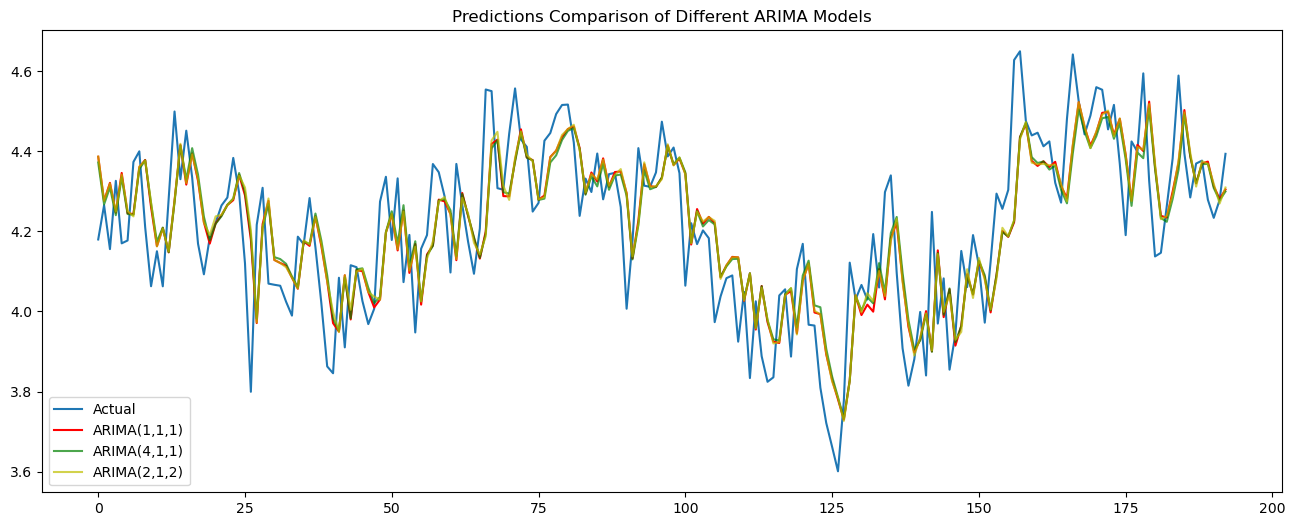

In [46]:
plt.figure(figsize=(16,6))
plt.plot(result['actual'],'',label='Actual')
plt.plot(result['prediction'],'r',label='ARIMA(1,1,1)')
plt.plot(results411['prediction'],c='g',label='ARIMA(4,1,1)',alpha=0.7)
plt.plot(results212['prediction'],c='y',label='ARIMA(2,1,2)',alpha=0.7)
plt.title('Predictions Comparison of Different ARIMA Models')
plt.legend()
plt.show()